In [0]:
!pip install torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import gym
from gym import wrappers
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import cv2
import math

## Environment - Breakout
## Algorithm - DDQN

1. Replay memory size - 5000 (had to decrease due to GPU memory error)
2. Batch size - Number of random samples taken for each training
3. Gamma - discount factor
4. USE_CUDA - using GPU when available
5. episodes - numer of training episodes 
6. Transition - Tuple definition of how it will be stored in the replay memory

In [0]:
num_frames=4
TOTAL_STEPS = 0
BATCH_SIZE = 32
GAMMA = 0.99
MIN_REPLAY_MEMORY = 5000
MAX_REPLAY_MEMORY = 10000
TARGET_UPDATE_FREQUENCY = 1000
TRAIN_EVERY = 4
USE_CUDA = torch.cuda.is_available()
path = '/drive/My Drive/Breakout-DDQN.model'
episodes = 3501
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

## Replay Memory

Experience Reply, where the transitions are stored and randomly retrieved in batches

In [0]:
class ReplayMemory(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.memory = []
        self.pos = 0

    def add(self, *args):
        if len(self.memory) < self.maxlen:
            self.memory.append(None)
        self.memory[self.pos] = Transition(*args)
        self.pos = (self.pos + 1) % self.maxlen

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


## DQN Network
The main neural network used for training. This one is implemented in PyTorch with 3 convolutions and 2 fully connected layers

In [0]:
class DQN(nn.Module):

    def __init__(self, num_frames,num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(3136, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)

*** Images have to be preprocessed in order to make it easier for the network to train. Otherise, the memory requirement and time taken for training can be very demanding ***

In [0]:
resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])

def get_preprocessed_state():
    state = env.render(mode='rgb_array')
    state =  cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)[34:194,:]
    state = np.ascontiguousarray(state, dtype=np.float32) / 255
    state = torch.from_numpy(state).unsqueeze(0)
    return resize(state).unsqueeze(0)

*** As the number of steps here is more, normal decay would reach the minimum at a very faster rate, so epsilon should be decayed exponentially ***

In [0]:
#Helper Functions for GPU functionalities
def get_variable(x):
    if USE_CUDA:
        return x.cuda()
    return x

# Reference: hhttps://towardsdatascience.com/why-going-from-implementing-q-learning-to-deep-q-learning-can-be-difficult-36e7ea1648af
def decay_epsilon(steps):
    return MIN_EPSILON + (EPSILON - MIN_EPSILON) * math.exp(-1. * steps / DECAY)


*** Here, the agent class is declared where the models, replay memory and optimizer are declared. Training  and optimizations for the models happen in this class ***

In [0]:
class Agent:
    def __init__(self, num_frames, n_actions):
        self.model = DQN(num_frames, n_actions)
        self.target_model = DQN(num_frames, n_actions)
        self.memory = ReplayMemory(MAX_REPLAY_MEMORY)
        self.optimizer = optim.RMSprop(self.model.parameters(),lr=0.0001)
        self.target_model.load_state_dict(self.model.state_dict())
        if USE_CUDA:
          self.model = self.model.cuda()
          self.target_model = self.target_model.cuda()


    
    def train(self):
        if len(self.memory.memory) < MIN_REPLAY_MEMORY:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        

        current_states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)

        next_states = torch.cat([s for s in batch.next_state if s is not None])
        not_none_states = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),  dtype=torch.bool)

        current_state_action_values = self.model(current_states).gather(1, actions)

        
        main_next_state_action_values = self.model(next_states).max(1)[1].view(-1,1).detach() #
        target_next_state_values = get_variable(torch.zeros(BATCH_SIZE))
        #actions are estimated in target model using the main model
        target_next_state_values[not_none_states] = self.target_model(next_states).gather(1, main_next_state_action_values).view(-1).detach()

        expected_state_action_values = (target_next_state_values * GAMMA) + rewards

        loss = nn.MSELoss()(current_state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

*** This is the main function where the environment is decalred and Training actually starts. ***

Episode:  0
Steps:  1  epsilon:  1.0


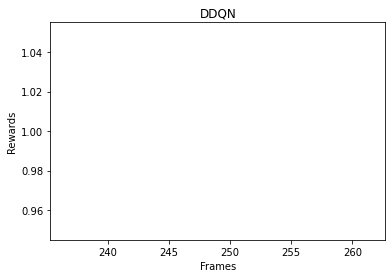

Episode:  1
Steps:  63  epsilon:  0.9969976560375187
Episode:  2
Steps:  110  epsilon:  0.9947278795777406
Episode:  3
Steps:  219  epsilon:  0.9894844140562512
Episode:  4
Steps:  301  epsilon:  0.9855585814149708
Episode:  5
Steps:  402  epsilon:  0.9807451746603684
Episode:  6
Steps:  464  epsilon:  0.9778024282325334
Episode:  7
Steps:  527  epsilon:  0.9748215479348847
Episode:  8
Steps:  589  epsilon:  0.9718971363162614
Episode:  9
Steps:  651  epsilon:  0.9689817763363668
Episode:  10
Steps:  705  epsilon:  0.9664499450505818


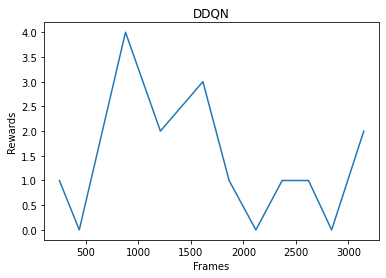

Episode:  11
Steps:  781  epsilon:  0.9628981878719758
Episode:  12
Steps:  838  epsilon:  0.960243213172573
Episode:  13
Steps:  893  epsilon:  0.9576885585963552
Episode:  14
Steps:  979  epsilon:  0.9537080619953628
Episode:  15
Steps:  1046  epsilon:  0.9506188173615269
Episode:  16
Steps:  1100  epsilon:  0.9481364991921875
Episode:  17
Steps:  1156  epsilon:  0.9455693127327208
Episode:  18
Steps:  1196  epsilon:  0.9437400040257319
Episode:  19
Steps:  1258  epsilon:  0.9409117960006139
Episode:  20
Steps:  1306  epsilon:  0.9387282290187029


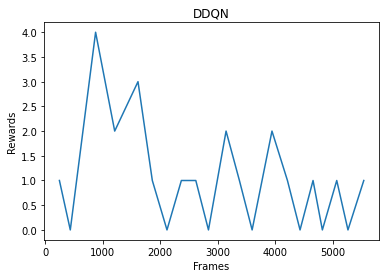

Episode:  21
Steps:  1374  epsilon:  0.9356437995414837
Episode:  22
Steps:  1432  epsilon:  0.9330212370763667
Episode:  23
Steps:  1495  epsilon:  0.930181195593271
Episode:  24
Steps:  1609  epsilon:  0.9250647584769169
Episode:  25
Steps:  1702  epsilon:  0.9209123691372978
Episode:  26
Steps:  1774  epsilon:  0.9177108507990513
Episode:  27
Steps:  1830  epsilon:  0.9152287369977833
Episode:  28
Steps:  1892  epsilon:  0.9124887770452674
Episode:  29
Steps:  1957  epsilon:  0.9096253441187929
Episode:  30
Steps:  2010  epsilon:  0.9072974228149245


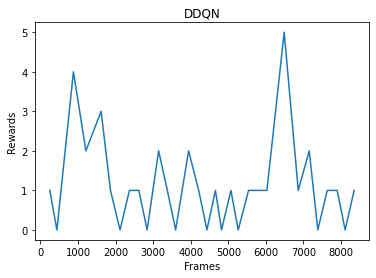

Episode:  31
Steps:  2069  epsilon:  0.9047132090070802
Episode:  32
Steps:  2126  epsilon:  0.9022238254180257
Episode:  33
Steps:  2184  epsilon:  0.8996980404826238
Episode:  34
Steps:  2248  epsilon:  0.8969194548611331
Episode:  35
Steps:  2331  epsilon:  0.8933291940673772
Episode:  36
Steps:  2434  epsilon:  0.8888944779136683
Episode:  37
Steps:  2548  epsilon:  0.8840127056578806
Episode:  38
Steps:  2643  epsilon:  0.8799657644005816
Episode:  39
Steps:  2712  epsilon:  0.8770384350600561
Episode:  40
Steps:  2770  epsilon:  0.8745855819544262


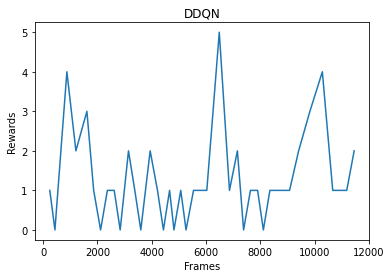

Episode:  41
Steps:  2838  epsilon:  0.8717188671525458
Episode:  42
Steps:  2912  epsilon:  0.868610261810364
Episode:  43
Steps:  2990  epsilon:  0.8653460511375017
Episode:  44
Steps:  3099  epsilon:  0.860805798585073
Episode:  45
Steps:  3164  epsilon:  0.8581100626833207
Episode:  46
Steps:  3222  epsilon:  0.8557120223406623
Episode:  47
Steps:  3291  epsilon:  0.8528682242360093
Episode:  48
Steps:  3361  epsilon:  0.849993219644119
Episode:  49
Steps:  3444  epsilon:  0.8465972991913873
Episode:  50
Steps:  3511  epsilon:  0.8438662752582599


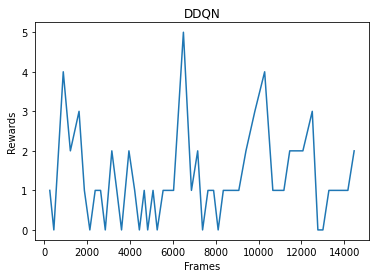

Episode:  51
Steps:  3584  epsilon:  0.8409010781303117
Episode:  52
Steps:  3703  epsilon:  0.8360905422517497
Episode:  53
Steps:  3792  epsilon:  0.8325114088169356
Episode:  54
Steps:  3866  epsilon:  0.8295476030262335
Episode:  55
Steps:  3923  epsilon:  0.8272721364377036
Episode:  56
Steps:  3975  epsilon:  0.8252019213288282
Episode:  57
Steps:  4065  epsilon:  0.8216315520387473
Episode:  58
Steps:  4127  epsilon:  0.8191812940894965
Episode:  59
Steps:  4224  epsilon:  0.8153630315843244
Episode:  60
Steps:  4319  epsilon:  0.8116414030495035


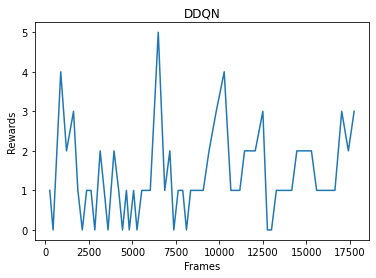

Episode:  61
Steps:  4402  epsilon:  0.8084043128349409
Episode:  62
Steps:  4535  epsilon:  0.8032450975581528
Episode:  63
Steps:  4605  epsilon:  0.8005434703222727
Episode:  64
Steps:  4694  epsilon:  0.7971221699185934
Episode:  65
Steps:  4756  epsilon:  0.7947477734079328
Episode:  66
Steps:  4835  epsilon:  0.7917329778440714
Episode:  67
Steps:  4915  epsilon:  0.7886921316794848
Episode:  68
Steps:  4996  epsilon:  0.7856256423785236
Episode:  69
Steps:  5072  epsilon:  0.7827597136507348
Episode:  70
Steps:  5155  epsilon:  0.7796422340834179


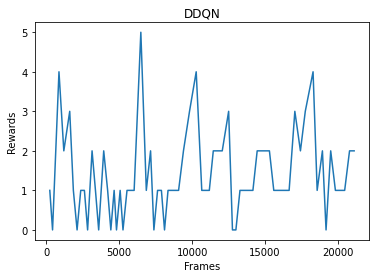

Episode:  71
Steps:  5233  epsilon:  0.7767243229955652
Episode:  72
Steps:  5278  epsilon:  0.7750460819979554
Episode:  73
Steps:  5339  epsilon:  0.772777153322983
Episode:  74
Steps:  5407  epsilon:  0.7702559993920786
Episode:  75
Steps:  5500  epsilon:  0.7668217996971923
Episode:  76
Steps:  5572  epsilon:  0.7641740100991711
Episode:  77
Steps:  5619  epsilon:  0.7624507268263528
Episode:  78
Steps:  5670  epsilon:  0.7605853568304877
Episode:  79
Steps:  5734  epsilon:  0.7582512202988768
Episode:  80
Steps:  5818  epsilon:  0.7551989793663727


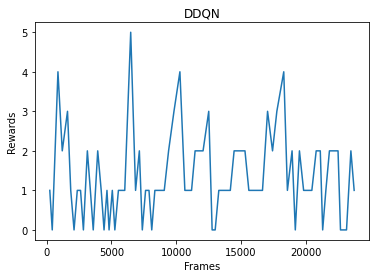

Episode:  81
Steps:  5880  epsilon:  0.7529543435134878
Episode:  82
Steps:  5954  epsilon:  0.7502843549673095
Episode:  83
Steps:  6030  epsilon:  0.7475524682904893
Episode:  84
Steps:  6125  epsilon:  0.7441521761531907
Episode:  85
Steps:  6184  epsilon:  0.7420485316347837
Episode:  86
Steps:  6240  epsilon:  0.7400575843731247
Episode:  87
Steps:  6353  epsilon:  0.7360570711135679
Episode:  88
Steps:  6426  epsilon:  0.7334846603096319
Episode:  89
Steps:  6501  epsilon:  0.73085153303281
Episode:  90
Steps:  6596  epsilon:  0.7275303822285174


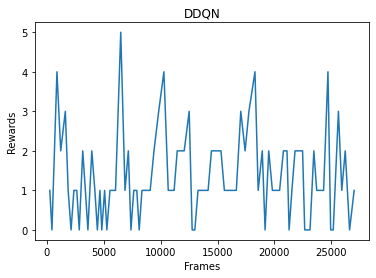

Episode:  91
Steps:  6696  epsilon:  0.7240514349334164
Episode:  92
Steps:  6784  epsilon:  0.7210043171947494
Episode:  93
Steps:  6835  epsilon:  0.7192445009052724
Episode:  94
Steps:  6917  epsilon:  0.7164243836424626
Episode:  95
Steps:  6981  epsilon:  0.7142313363618558
Episode:  96
Steps:  7040  epsilon:  0.712215828255708
Episode:  97
Steps:  7152  epsilon:  0.7084060968215844
Episode:  98
Steps:  7245  epsilon:  0.705258831534134
Episode:  99
Steps:  7299  epsilon:  0.7034380917937406
Episode:  100
Steps:  7381  epsilon:  0.7006826481367993


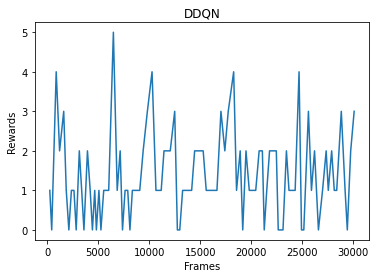

Episode:  101
Steps:  7465  epsilon:  0.6978716881626803
Episode:  102
Steps:  7519  epsilon:  0.6960708668074694
Episode:  103
Steps:  7599  epsilon:  0.6934119048095172
Episode:  104
Steps:  7664  epsilon:  0.6912593159704761
Episode:  105
Steps:  7718  epsilon:  0.6894763239397647
Episode:  106
Steps:  7802  epsilon:  0.6867123318257243
Episode:  107
Steps:  7868  epsilon:  0.6845487529992107
Episode:  108
Steps:  7922  epsilon:  0.682783855050519
Episode:  109
Steps:  7966  epsilon:  0.6813493091485001
Episode:  110
Steps:  8036  epsilon:  0.6790735714306351


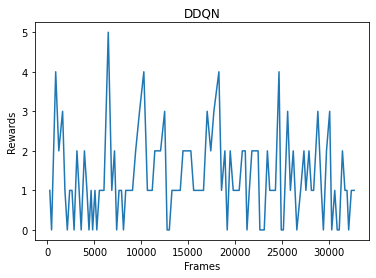

Episode:  111
Steps:  8111  epsilon:  0.6766441036369153
Episode:  112
Steps:  8196  epsilon:  0.6739016979364626
Episode:  113
Steps:  8268  epsilon:  0.6715878193044174
Episode:  114
Steps:  8325  epsilon:  0.6697618971943275
Episode:  115
Steps:  8369  epsilon:  0.6683559681095513
Episode:  116
Steps:  8435  epsilon:  0.6662528654427553
Episode:  117
Steps:  8486  epsilon:  0.6646324874958008
Episode:  118
Steps:  8582  epsilon:  0.6615935508385545
Episode:  119
Steps:  8643  epsilon:  0.659670125223615
Episode:  120
Steps:  8718  epsilon:  0.6573132840930689


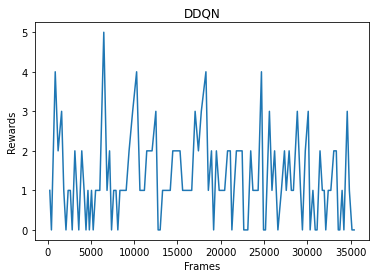

Episode:  121
Steps:  8780  epsilon:  0.6553716240404077
Episode:  122
Steps:  8842  epsilon:  0.6534359738138666
Episode:  123
Steps:  8910  epsilon:  0.6513198908823759
Episode:  124
Steps:  8990  epsilon:  0.6488395752571834
Episode:  125
Steps:  9052  epsilon:  0.6469241430277833
Episode:  126
Steps:  9147  epsilon:  0.6440007020174771
Episode:  127
Steps:  9211  epsilon:  0.6420390401040338
Episode:  128
Steps:  9290  epsilon:  0.6396262542847394
Episode:  129
Steps:  9364  epsilon:  0.6373748048937871
Episode:  130
Steps:  9426  epsilon:  0.6354948584211724


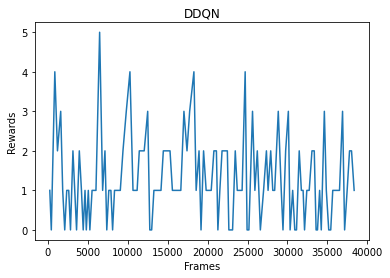

Episode:  131
Steps:  9508  epsilon:  0.6330174117378353
Episode:  132
Steps:  9591  epsilon:  0.630520075036975
Episode:  133
Steps:  9703  epsilon:  0.6271665612193023
Episode:  134
Steps:  9787  epsilon:  0.6246637213051744
Episode:  135
Steps:  9885  epsilon:  0.6217569963627579
Episode:  136
Steps:  9962  epsilon:  0.6194831119629512
Episode:  137
Steps:  10017  epsilon:  0.6178642603462396
Episode:  138
Steps:  10080  epsilon:  0.6160154014077521
Episode:  139
Steps:  10157  epsilon:  0.613763579650683
Episode:  140
Steps:  10220  epsilon:  0.6119276175332291


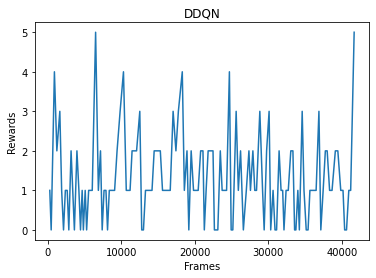

Episode:  141
Steps:  10338  epsilon:  0.6085043531500273
Episode:  142
Steps:  10452  epsilon:  0.6052162583098785
Episode:  143
Steps:  10522  epsilon:  0.6032065204985707
Episode:  144
Steps:  10589  epsilon:  0.6012894914713423
Episode:  145
Steps:  10643  epsilon:  0.5997490903217152
Episode:  146
Steps:  10710  epsilon:  0.59784362430672
Episode:  147
Steps:  10801  epsilon:  0.5952658048027699
Episode:  148
Steps:  10905  epsilon:  0.5923340517818638
Episode:  149
Steps:  10957  epsilon:  0.5908738822901322
Episode:  150
Steps:  11049  epsilon:  0.5882997873888564


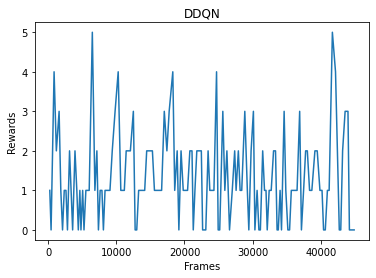

Episode:  151
Steps:  11130  epsilon:  0.5860432458309954
Episode:  152
Steps:  11225  epsilon:  0.5834083033559155
Episode:  153
Steps:  11305  epsilon:  0.5811990915117952
Episode:  154
Steps:  11403  epsilon:  0.578504822313704
Episode:  155
Steps:  11472  epsilon:  0.5766157412153484
Episode:  156
Steps:  11575  epsilon:  0.5738079065283054
Episode:  157
Steps:  11647  epsilon:  0.5718537177151904
Episode:  158
Steps:  11721  epsilon:  0.5698525633781509
Episode:  159
Steps:  11832  epsilon:  0.5668646806953643
Episode:  160
Steps:  11894  epsilon:  0.5652029771564414


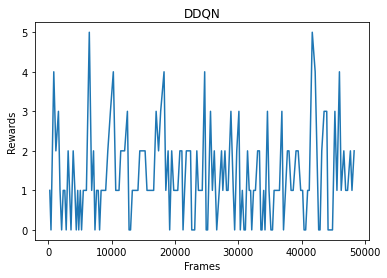

Episode:  161
Steps:  11980  epsilon:  0.5629065452217461
Episode:  162
Steps:  12048  epsilon:  0.5610977396798955
Episode:  163
Steps:  12134  epsilon:  0.5588189223677698
Episode:  164
Steps:  12209  epsilon:  0.5568395650234701
Episode:  165
Steps:  12253  epsilon:  0.5556817919977152
Episode:  166
Steps:  12351  epsilon:  0.5531122517317976
Episode:  167
Steps:  12419  epsilon:  0.5513366902409013
Episode:  168
Steps:  12469  epsilon:  0.5500349763356566
Episode:  169
Steps:  12525  epsilon:  0.5485809150377203
Episode:  170
Steps:  12589  epsilon:  0.5469241084140056


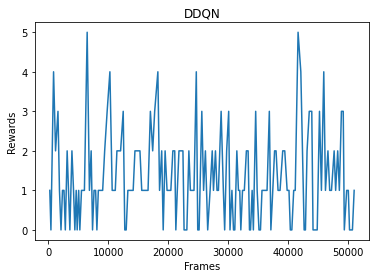

Episode:  171
Steps:  12660  epsilon:  0.5450922812461586
Episode:  172
Steps:  12755  epsilon:  0.5426513946053848
Episode:  173
Steps:  12815  epsilon:  0.5411157450476423
Episode:  174
Steps:  12878  epsilon:  0.5395082635632662
Episode:  175
Steps:  12931  epsilon:  0.5381598540964675
Episode:  176
Steps:  12973  epsilon:  0.5370938381114101
Episode:  177
Steps:  13047  epsilon:  0.5352210576907058
Episode:  178
Steps:  13137  epsilon:  0.5329526706298865
Episode:  179
Steps:  13194  epsilon:  0.531521296196021
Episode:  180
Steps:  13246  epsilon:  0.5302190344997239


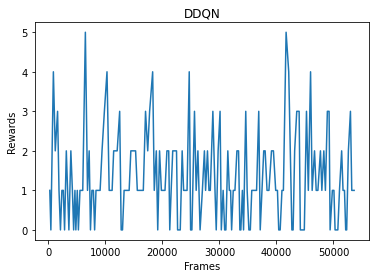

Episode:  181
Steps:  13298  epsilon:  0.5289201542860047
Episode:  182
Steps:  13397  epsilon:  0.526456601844845
Episode:  183
Steps:  13441  epsilon:  0.5253655978652022
Episode:  184
Steps:  13510  epsilon:  0.5236595312097524
Episode:  185
Steps:  13552  epsilon:  0.5226239339519146
Episode:  186
Steps:  13612  epsilon:  0.5211482767426157
Episode:  187
Steps:  13670  epsilon:  0.5197260100235764
Episode:  188
Steps:  13728  epsilon:  0.518307861903168
Episode:  189
Steps:  13793  epsilon:  0.5167234374363646
Episode:  190
Steps:  13923  epsilon:  0.5135699948840611


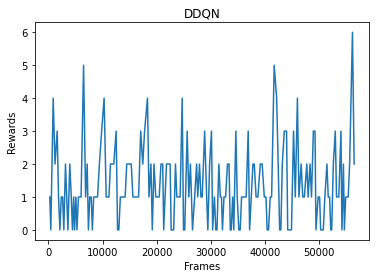

Episode:  191
Steps:  14001  epsilon:  0.5116877446776672
Episode:  192
Steps:  14058  epsilon:  0.5103168890025707
Episode:  193
Steps:  14111  epsilon:  0.5090457342706239
Episode:  194
Steps:  14163  epsilon:  0.5078018331337292
Episode:  195
Steps:  14245  epsilon:  0.5058468560594794
Episode:  196
Steps:  14314  epsilon:  0.5042080130358171
Episode:  197
Steps:  14363  epsilon:  0.5030476254590963
Episode:  198
Steps:  14404  epsilon:  0.5020788711393487
Episode:  199
Steps:  14445  epsilon:  0.5011121007317518
Episode:  200
Steps:  14488  epsilon:  0.5001002977930926


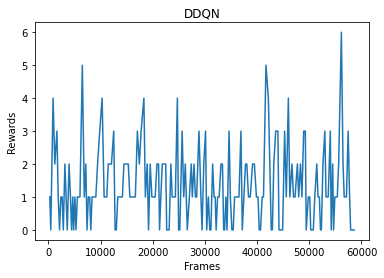

Episode:  201
Steps:  14529  epsilon:  0.4991375793062177
Episode:  202
Steps:  14578  epsilon:  0.4979895990869154
Episode:  203
Steps:  14647  epsilon:  0.4963778168930362
Episode:  204
Steps:  14702  epsilon:  0.4950970397722777
Episode:  205
Steps:  14836  epsilon:  0.49199130543386294
Episode:  206
Steps:  14893  epsilon:  0.49067650469438573
Episode:  207
Steps:  15009  epsilon:  0.4880123145870783
Episode:  208
Steps:  15051  epsilon:  0.48705149793702807
Episode:  209
Steps:  15101  epsilon:  0.4859102962886218
Episode:  210
Steps:  15185  epsilon:  0.4839994885493486


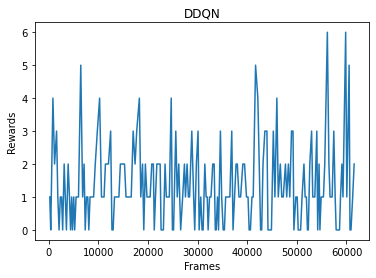

Episode:  211
Steps:  15259  epsilon:  0.48232279423901847
Episode:  212
Steps:  15312  epsilon:  0.4811257256506991
Episode:  213
Steps:  15373  epsilon:  0.47975188835435134
Episode:  214
Steps:  15432  epsilon:  0.478427075343662
Episode:  215
Steps:  15485  epsilon:  0.4772403167436473
Episode:  216
Steps:  15615  epsilon:  0.4743426821991642
Episode:  217
Steps:  15700  epsilon:  0.47245823309066104
Episode:  218
Steps:  15766  epsilon:  0.4710005274586223
Episode:  219
Steps:  15824  epsilon:  0.4697234785449155
Episode:  220
Steps:  15889  epsilon:  0.4682966970154946


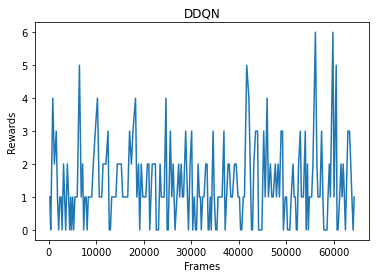

Episode:  221
Steps:  15942  epsilon:  0.4671367483791582
Episode:  222
Steps:  16008  epsilon:  0.46569657470302994
Episode:  223
Steps:  16087  epsilon:  0.4639789677399514
Episode:  224
Steps:  16166  epsilon:  0.4622681319425209
Episode:  225
Steps:  16266  epsilon:  0.46011218564011724
Episode:  226
Steps:  16310  epsilon:  0.4591669789403121
Episode:  227
Steps:  16398  epsilon:  0.45728279248300063
Episode:  228
Steps:  16469  epsilon:  0.4557686278021825
Episode:  229
Steps:  16515  epsilon:  0.4547904852533664
Episode:  230
Steps:  16654  epsilon:  0.4518484268761048


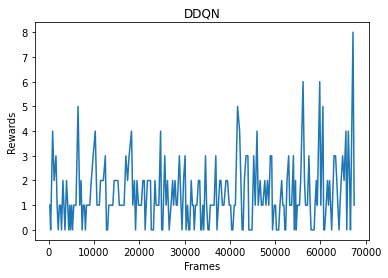

Episode:  231
Steps:  16717  epsilon:  0.45052169503114214
Episode:  232
Steps:  16767  epsilon:  0.4494717038294368
Episode:  233
Steps:  16821  epsilon:  0.44834065782830923
Episode:  234
Steps:  16883  epsilon:  0.44704580984038
Episode:  235
Steps:  16950  epsilon:  0.44565104391473664
Episode:  236
Steps:  17025  epsilon:  0.44409527139669824
Episode:  237
Steps:  17101  epsilon:  0.4425246953498059
Episode:  238
Steps:  17189  epsilon:  0.4407135740790039
Episode:  239
Steps:  17277  epsilon:  0.4389104042358244
Episode:  240
Steps:  17319  epsilon:  0.4380525934035484


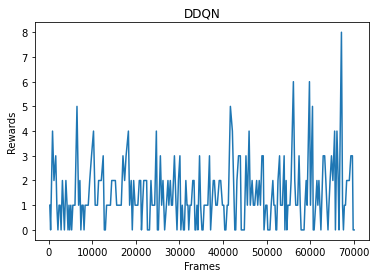

Episode:  241
Steps:  17376  epsilon:  0.43689129914272096
Episode:  242
Steps:  17466  epsilon:  0.4350644018982668
Episode:  243
Steps:  17521  epsilon:  0.4339520050397686
Episode:  244
Steps:  17609  epsilon:  0.4321785207442642
Episode:  245
Steps:  17698  epsilon:  0.43039280249685885
Episode:  246
Steps:  17835  epsilon:  0.42765948410309007
Episode:  247
Steps:  17910  epsilon:  0.4261710535891712
Episode:  248
Steps:  17999  epsilon:  0.4244120091773045
Episode:  249
Steps:  18072  epsilon:  0.4229750294271979
Episode:  250
Steps:  18171  epsilon:  0.421034609532865


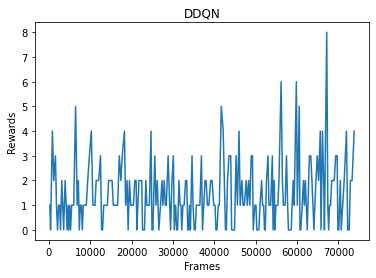

Episode:  251
Steps:  18296  epsilon:  0.41859826473159334
Episode:  252
Steps:  18408  epsilon:  0.41642819631178096
Episode:  253
Steps:  18487  epsilon:  0.41490481559397885
Episode:  254
Steps:  18615  epsilon:  0.4124492908349252
Episode:  255
Steps:  18714  epsilon:  0.4105608446056793
Episode:  256
Steps:  18798  epsilon:  0.4089658409107495
Episode:  257
Steps:  18900  epsilon:  0.407038035205171
Episode:  258
Steps:  19032  epsilon:  0.40455777802483894
Episode:  259
Steps:  19119  epsilon:  0.40293199034230365
Episode:  260
Steps:  19205  epsilon:  0.40133182560360625


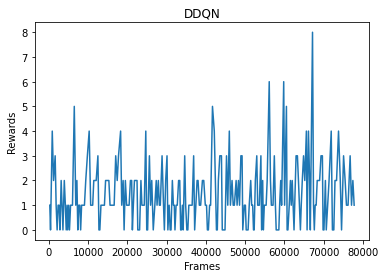

Episode:  261
Steps:  19286  epsilon:  0.3998309729879358
Episode:  262
Steps:  19337  epsilon:  0.39888910539836764
Episode:  263
Steps:  19409  epsilon:  0.39756349215443465
Episode:  264
Steps:  19467  epsilon:  0.39649910213866946
Episode:  265
Steps:  19528  epsilon:  0.3953829828243258
Episode:  266
Steps:  19607  epsilon:  0.3939425667367832
Episode:  267
Steps:  19733  epsilon:  0.39165693586331196
Episode:  268
Steps:  19853  epsilon:  0.38949349107283393
Episode:  269
Steps:  20014  epsilon:  0.38661118531540606
Episode:  270
Steps:  20171  epsilon:  0.3838227464524172


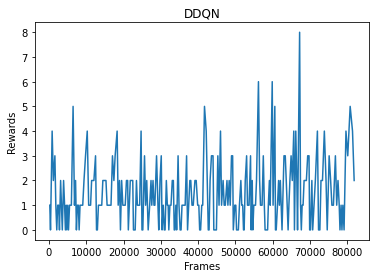

Episode:  271
Steps:  20280  epsilon:  0.38189965766125056
Episode:  272
Steps:  20352  epsilon:  0.38063509646954086
Episode:  273
Steps:  20500  epsilon:  0.3780499735073932
Episode:  274
Steps:  20585  epsilon:  0.37657389999799173
Episode:  275
Steps:  20676  epsilon:  0.3750005707912659
Episode:  276
Steps:  20777  epsilon:  0.37326270970133735
Episode:  277
Steps:  20874  epsilon:  0.37160191623893213
Episode:  278
Steps:  20925  epsilon:  0.3707319410423162
Episode:  279
Steps:  21026  epsilon:  0.36901558219376374
Episode:  280
Steps:  21124  epsilon:  0.3673584690837397


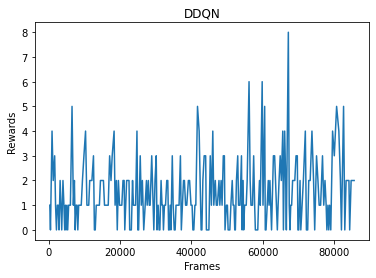

Episode:  281
Steps:  21238  epsilon:  0.36544099580037603
Episode:  282
Steps:  21331  epsilon:  0.36388481609176715
Episode:  283
Steps:  21432  epsilon:  0.36220294806159836
Episode:  284
Steps:  21578  epsilon:  0.3597866965887849
Episode:  285
Steps:  21685  epsilon:  0.35802704901641513
Episode:  286
Steps:  21757  epsilon:  0.35684827470678937
Episode:  287
Steps:  21849  epsilon:  0.3553482254016259
Episode:  288
Steps:  21995  epsilon:  0.35298183120376925
Episode:  289
Steps:  22083  epsilon:  0.3515638330301575
Episode:  290
Steps:  22186  epsilon:  0.34991203631740075


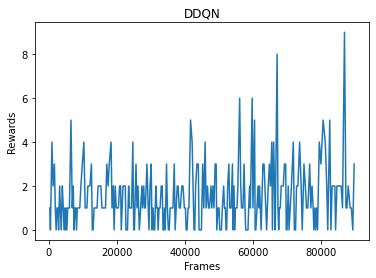

Episode:  291
Steps:  22286  epsilon:  0.3483164683797564
Episode:  292
Steps:  22387  epsilon:  0.3467130223233864
Episode:  293
Steps:  22446  epsilon:  0.3457800956509405
Episode:  294
Steps:  22555  epsilon:  0.3440637753507092
Episode:  295
Steps:  22687  epsilon:  0.3419977797185393
Episode:  296
Steps:  22792  epsilon:  0.3403640835797753
Episode:  297
Steps:  22912  epsilon:  0.3385074744754336
Episode:  298
Steps:  23004  epsilon:  0.3370915991028629
Episode:  299
Steps:  23143  epsilon:  0.3349647119829965
Episode:  300
Steps:  23257  epsilon:  0.33323135787694924


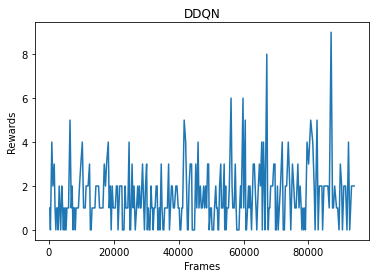

Episode:  301
Steps:  23345  epsilon:  0.33190007088148976
Episode:  302
Steps:  23500  epsilon:  0.3295693883923434
Episode:  303
Steps:  23679  epsilon:  0.3269002047802291
Episode:  304
Steps:  23843  epsilon:  0.3244755776582101
Episode:  305
Steps:  23952  epsilon:  0.3228750511563252
Episode:  306
Steps:  24053  epsilon:  0.3213997603924633
Episode:  307
Steps:  24154  epsilon:  0.31993190106678426
Episode:  308
Steps:  24265  epsilon:  0.31832723608017377
Episode:  309
Steps:  24379  epsilon:  0.31668844582376976
Episode:  310
Steps:  24517  epsilon:  0.3147171044964555


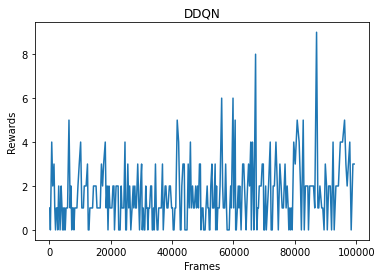

Episode:  311
Steps:  24619  epsilon:  0.313268743722817
Episode:  312
Steps:  24743  epsilon:  0.3115179107025964
Episode:  313
Steps:  24913  epsilon:  0.30913514954274424
Episode:  314
Steps:  25026  epsilon:  0.3075624829146707
Episode:  315
Steps:  25158  epsilon:  0.30573660256054336
Episode:  316
Steps:  25247  epsilon:  0.304512300770983
Episode:  317
Steps:  25363  epsilon:  0.3029247378095651
Episode:  318
Steps:  25505  epsilon:  0.3009938349875295
Episode:  319
Steps:  25562  epsilon:  0.300222602086727
Episode:  320
Steps:  25688  epsilon:  0.2985255510174415


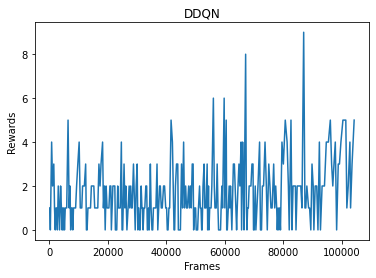

Episode:  321
Steps:  25867  epsilon:  0.2961329701063672
Steps:  26067  epsilon:  0.2934849028089812
Episode:  322
Steps:  26096  epsilon:  0.2931031265545829
Episode:  323
Steps:  26217  epsilon:  0.29151615805920783
Episode:  324
Steps:  26387  epsilon:  0.2893026912764298
Episode:  325
Steps:  26521  epsilon:  0.28757117031741697
Episode:  326
Steps:  26583  epsilon:  0.2867739360410131
Episode:  327
Steps:  26661  epsilon:  0.2857744679201144
Episode:  328
Steps:  26803  epsilon:  0.2839649007629731
Episode:  329
Steps:  26869  epsilon:  0.2831281979094713
Episode:  330
Steps:  26960  epsilon:  0.2819790808327983


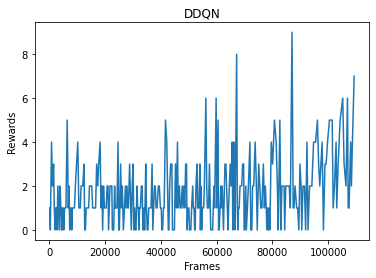

Episode:  331
Steps:  27114  epsilon:  0.2800462926942936
Episode:  332
Steps:  27235  epsilon:  0.2785380795685599
Episode:  333
Steps:  27390  epsilon:  0.27661935411664074
Episode:  334
Steps:  27459  epsilon:  0.27576998335197683
Episode:  335
Steps:  27572  epsilon:  0.27438529836467584
Episode:  336
Steps:  27641  epsilon:  0.2735436218122085
Episode:  337
Steps:  27757  epsilon:  0.272135157301173
Episode:  338
Steps:  27816  epsilon:  0.2714219111424706
Episode:  339
Steps:  27887  epsilon:  0.27056638281917145
Episode:  340
Steps:  27969  epsilon:  0.26958207984954463


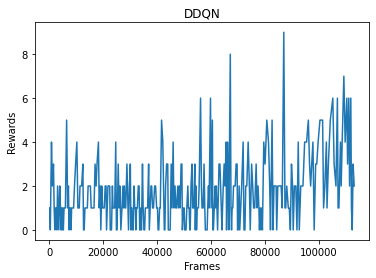

Episode:  341
Steps:  28064  epsilon:  0.2684467634812645
Episode:  342
Steps:  28125  epsilon:  0.26772060880145443
Episode:  343
Steps:  28210  epsilon:  0.2667124400900634
Episode:  344
Steps:  28315  epsilon:  0.26547295627155226
Episode:  345
Steps:  28392  epsilon:  0.2645681283014001
Episode:  346
Steps:  28469  epsilon:  0.26366677722162435
Episode:  347
Steps:  28556  epsilon:  0.26265253431835867
Episode:  348
Steps:  28617  epsilon:  0.26194402511446574
Episode:  349
Steps:  28728  epsilon:  0.2606603014035349
Episode:  350
Steps:  28805  epsilon:  0.2597739665325659


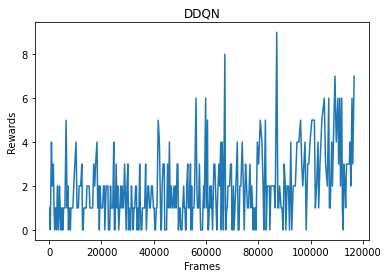

Episode:  351
Steps:  28934  epsilon:  0.25829669377459175
Episode:  352
Steps:  29053  epsilon:  0.25694236158047024
Episode:  353
Steps:  29111  epsilon:  0.2562851821027028
Episode:  354
Steps:  29192  epsilon:  0.2553705804337124
Episode:  355
Steps:  29303  epsilon:  0.2541232382885279
Episode:  356
Steps:  29378  epsilon:  0.25328435004347727
Episode:  357
Steps:  29447  epsilon:  0.2525153463299885
Episode:  358
Steps:  29524  epsilon:  0.2516603092491473
Episode:  359
Steps:  29677  epsilon:  0.2499710774332515
Episode:  360
Steps:  29832  epsilon:  0.24827289055705967


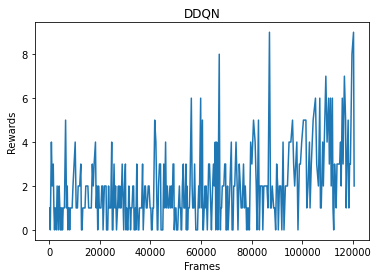

Episode:  361
Steps:  29893  epsilon:  0.24760817245126693
Episode:  362
Steps:  29955  epsilon:  0.2469346316443126
Episode:  363
Steps:  30041  epsilon:  0.24600381541736221
Episode:  364
Steps:  30156  epsilon:  0.24476535745755465
Episode:  365
Steps:  30223  epsilon:  0.24404709726761276
Episode:  366
Steps:  30293  epsilon:  0.24329924193743943
Episode:  367
Steps:  30368  epsilon:  0.24250086766752474
Episode:  368
Steps:  30481  epsilon:  0.2413036231658386
Episode:  369
Steps:  30623  epsilon:  0.2398086807668761
Episode:  370
Steps:  30749  epsilon:  0.23849104100139662


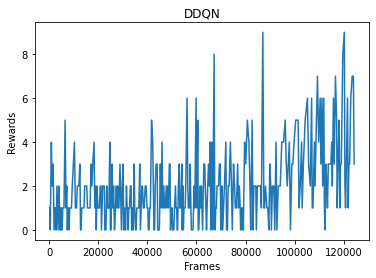

Episode:  371
Steps:  30825  epsilon:  0.2377002784459973
Episode:  372
Steps:  30901  epsilon:  0.23691251508622777
Episode:  373
Steps:  31028  epsilon:  0.23560278341445642
Episode:  374
Steps:  31156  epsilon:  0.23429112737703983
Episode:  375
Steps:  31218  epsilon:  0.23365880548748416
Episode:  376
Steps:  31268  epsilon:  0.23315029437750245
Episode:  377
Steps:  31385  epsilon:  0.23196533454226756
Episode:  378
Steps:  31461  epsilon:  0.23119932261543538
Episode:  379
Steps:  31554  epsilon:  0.23026591761378098
Episode:  380
Steps:  31631  epsilon:  0.22949637614883175


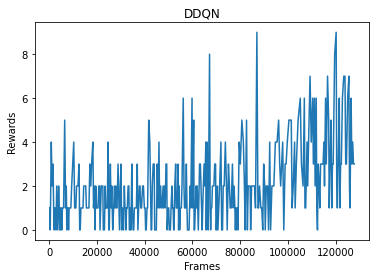

Episode:  381
Steps:  31703  epsilon:  0.22877948038132473
Episode:  382
Steps:  31774  epsilon:  0.22807506430429123
Episode:  383
Steps:  31889  epsilon:  0.2269394008459719
Episode:  384
Steps:  31990  epsilon:  0.22594736387334
Episode:  385
Steps:  32064  epsilon:  0.22522369823402305
Episode:  386
Steps:  32179  epsilon:  0.22410438308417796
Episode:  387
Steps:  32240  epsilon:  0.22351326662660737
Episode:  388
Steps:  32337  epsilon:  0.22257699956636715
Episode:  389
Steps:  32470  epsilon:  0.22130061121427505
Episode:  390
Steps:  32545  epsilon:  0.2205845773248662


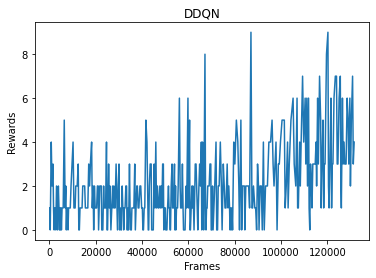

Episode:  391
Steps:  32639  epsilon:  0.21969093152412347
Episode:  392
Steps:  32681  epsilon:  0.2192929985437925
Episode:  393
Steps:  32755  epsilon:  0.21859390856318955
Episode:  394
Steps:  32873  epsilon:  0.2174844805336179
Episode:  395
Steps:  32966  epsilon:  0.2166147015026162
Episode:  396
Steps:  33033  epsilon:  0.2159905882259966
Episode:  397
Steps:  33148  epsilon:  0.21492421111597787
Episode:  398
Steps:  33304  epsilon:  0.21348741306622604
Episode:  399
Steps:  33421  epsilon:  0.21241714528531594
Episode:  400
Steps:  33555  epsilon:  0.2111990356359714


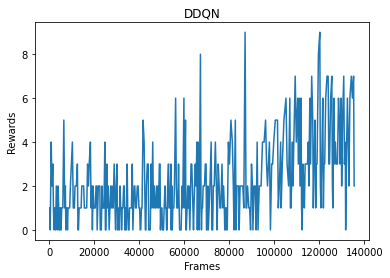

Episode:  401
Steps:  33617  epsilon:  0.2106381883878795
Episode:  402
Steps:  33688  epsilon:  0.2099980597197568
Steps:  33888  epsilon:  0.20820704910071805
Episode:  403
Steps:  33916  epsilon:  0.20795773379341362
Episode:  404
Steps:  34012  epsilon:  0.20710558346811397
Episode:  405
Steps:  34131  epsilon:  0.20605493402819539
Episode:  406
Steps:  34241  epsilon:  0.20508928984676605
Episode:  407
Steps:  34335  epsilon:  0.2042683010195333
Episode:  408
Steps:  34424  epsilon:  0.20349452999740356
Episode:  409
Steps:  34501  epsilon:  0.20282786021971144
Episode:  410
Steps:  34570  epsilon:  0.202232631461953


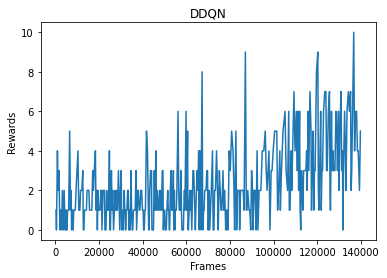

Episode:  411
Steps:  34677  epsilon:  0.20131364735807694
Episode:  412
Steps:  34739  epsilon:  0.20078339736340042
Episode:  413
Steps:  34860  epsilon:  0.1997532770653331
Episode:  414
Steps:  34941  epsilon:  0.1990671666047282
Episode:  415
Steps:  35023  epsilon:  0.19837541029112674
Episode:  416
Steps:  35089  epsilon:  0.197820687233622
Episode:  417
Steps:  35192  epsilon:  0.1969586323909088
Episode:  418
Steps:  35266  epsilon:  0.19634202687471136
Episode:  419
Steps:  35338  epsilon:  0.19574427218198423
Episode:  420
Steps:  35462  epsilon:  0.1947198367259757


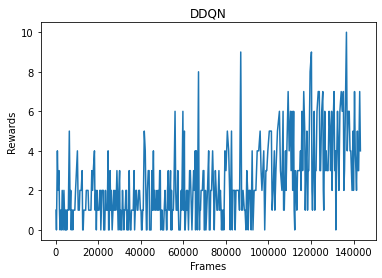

Episode:  421
Steps:  35545  epsilon:  0.19403766588711055
Episode:  422
Steps:  35681  epsilon:  0.19292599372805905
Episode:  423
Steps:  35752  epsilon:  0.19234863187396556
Episode:  424
Steps:  35887  epsilon:  0.19125646880597427
Episode:  425
Steps:  35952  epsilon:  0.1907332359962245
Episode:  426
Steps:  36023  epsilon:  0.19016364463130012
Episode:  427
Steps:  36184  epsilon:  0.1888795028971236
Episode:  428
Steps:  36329  epsilon:  0.18773179198040107
Episode:  429
Steps:  36393  epsilon:  0.18722785697210154
Episode:  430
Steps:  36453  epsilon:  0.1867568802195466


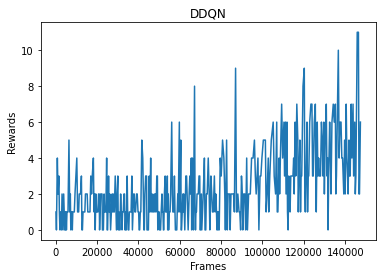

Episode:  431
Steps:  36565  epsilon:  0.18588149505644586
Episode:  432
Steps:  36679  epsilon:  0.18499549802499937
Episode:  433
Steps:  36791  epsilon:  0.1841299490351977
Episode:  434
Steps:  36916  epsilon:  0.18316964094251817
Episode:  435
Steps:  37010  epsilon:  0.18245143274146197
Episode:  436
Steps:  37103  epsilon:  0.1817441792180381
Episode:  437
Steps:  37253  epsilon:  0.18061035502940606
Episode:  438
Steps:  37393  epsilon:  0.17955976390305275
Episode:  439
Steps:  37515  epsilon:  0.1786502262533985
Episode:  440
Steps:  37645  epsilon:  0.17768713322597812


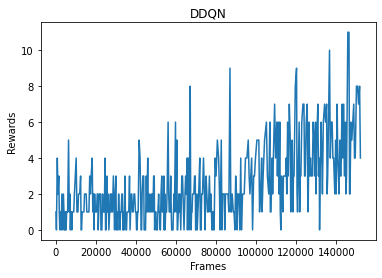

Episode:  441
Steps:  37743  epsilon:  0.1769652363648753
Episode:  442
Steps:  37832  epsilon:  0.1763126940465403
Episode:  443
Steps:  37967  epsilon:  0.17532840906075736
Episode:  444
Steps:  38047  epsilon:  0.17474825650316606
Episode:  445
Steps:  38162  epsilon:  0.17391834231814002
Episode:  446
Steps:  38282  epsilon:  0.17305741762109486
Steps:  38482  epsilon:  0.17163397253235027
Episode:  447
Steps:  38496  epsilon:  0.17153486344380559
Episode:  448
Steps:  38627  epsilon:  0.17061083957001083
Episode:  449
Steps:  38697  epsilon:  0.17011956186900506
Episode:  450
Steps:  38869  epsilon:  0.16891970043622945


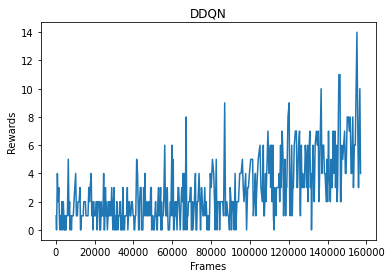

Episode:  451
Steps:  38956  epsilon:  0.16831671218960503
Episode:  452
Steps:  39040  epsilon:  0.16773700024566726
Episode:  453
Steps:  39120  epsilon:  0.1671871526729599
Episode:  454
Steps:  39234  epsilon:  0.16640741027969624
Episode:  455
Steps:  39325  epsilon:  0.1657881664110491
Episode:  456
Steps:  39447  epsilon:  0.16496237980571302
Episode:  457
Steps:  39591  epsilon:  0.1639941405153473
Episode:  458
Steps:  39677  epsilon:  0.16341920271328883
Episode:  459
Steps:  39749  epsilon:  0.1629397571034199
Episode:  460
Steps:  39930  epsilon:  0.16174207996506978


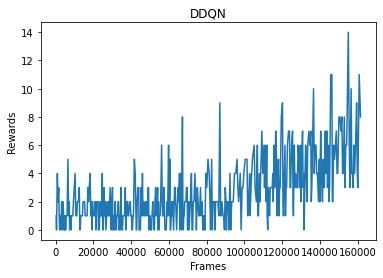

Episode:  461
Steps:  40106  epsilon:  0.16058783578448457
Episode:  462
Steps:  40233  epsilon:  0.15976123027730324
Episode:  463
Steps:  40365  epsilon:  0.15890762614967494
Episode:  464
Steps:  40501  epsilon:  0.1580340278921953
Episode:  465
Steps:  40610  epsilon:  0.1573381404559122
Episode:  466
Steps:  40780  epsilon:  0.1562603533464211
Episode:  467
Steps:  40935  epsilon:  0.1552856175878016
Episode:  468
Steps:  41054  epsilon:  0.15454238148326524
Episode:  469
Steps:  41183  epsilon:  0.15374166819901083
Episode:  470
Steps:  41283  epsilon:  0.15312450405413608


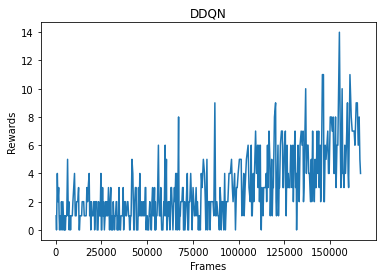

Episode:  471
Steps:  41370  epsilon:  0.15259007568592792
Episode:  472
Steps:  41550  epsilon:  0.1514917150415785
Episode:  473
Steps:  41661  epsilon:  0.15081930369059166
Episode:  474
Steps:  41790  epsilon:  0.15004252697966602
Episode:  475
Steps:  41937  epsilon:  0.1491634489755264
Episode:  476
Steps:  42023  epsilon:  0.1486521462336587
Episode:  477
Steps:  42098  epsilon:  0.14820803391632154
Episode:  478
Steps:  42163  epsilon:  0.14782448141651172
Episode:  479
Steps:  42261  epsilon:  0.1472485536329755
Episode:  480
Steps:  42395  epsilon:  0.14646561409991443


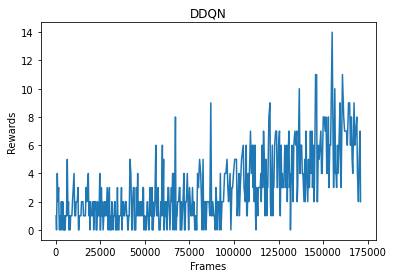

Episode:  481
Steps:  42455  epsilon:  0.1461167408291757
Episode:  482
Steps:  42545  epsilon:  0.14559538941590447
Episode:  483
Steps:  42627  epsilon:  0.14512241857208225
Episode:  484
Steps:  42705  epsilon:  0.14467431550859539
Episode:  485
Steps:  42873  epsilon:  0.14371508566393562
Episode:  486
Steps:  43002  epsilon:  0.14298398369987475
Episode:  487
Steps:  43112  epsilon:  0.14236427754363024
Episode:  488
Steps:  43173  epsilon:  0.1420220886005281
Episode:  489
Steps:  43291  epsilon:  0.14136310419338885
Episode:  490
Steps:  43419  epsilon:  0.14065265618517164


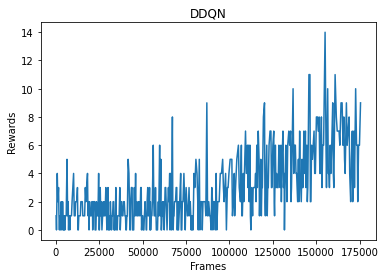

Episode:  491
Steps:  43572  epsilon:  0.13980939295967793
Episode:  492
Steps:  43676  epsilon:  0.1392398661692758
Episode:  493
Steps:  43754  epsilon:  0.13881466038145004
Episode:  494
Steps:  43892  epsilon:  0.13806642361030552
Episode:  495
Steps:  44021  epsilon:  0.13737163826947552
Episode:  496
Steps:  44165  epsilon:  0.13660133887942993
Episode:  497
Steps:  44267  epsilon:  0.13605905604776314
Episode:  498
Steps:  44392  epsilon:  0.13539825410458362
Episode:  499
Steps:  44526  epsilon:  0.13469444619141818
Episode:  500
Steps:  44634  epsilon:  0.13413061988311414


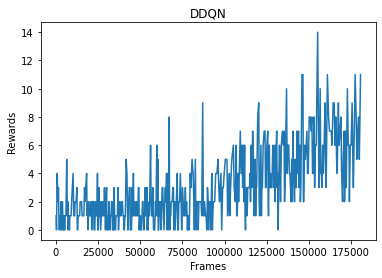

Episode:  501
Steps:  44811  epsilon:  0.13321312977919386
Episode:  502
Steps:  44878  epsilon:  0.1328679443029266
Episode:  503
Steps:  45000  epsilon:  0.13224235981519833
Episode:  504
Steps:  45129  epsilon:  0.13158501879808804
Episode:  505
Steps:  45248  epsilon:  0.1309823825569582
Episode:  506
Steps:  45311  epsilon:  0.13066478852511448
Episode:  507
Steps:  45401  epsilon:  0.1302128146806072
Episode:  508
Steps:  45523  epsilon:  0.12960337718517945
Episode:  509
Steps:  45705  epsilon:  0.12870109804933177
Steps:  45905  epsilon:  0.12771900571460126
Episode:  510
Steps:  45929  epsilon:  0.1276018132372932


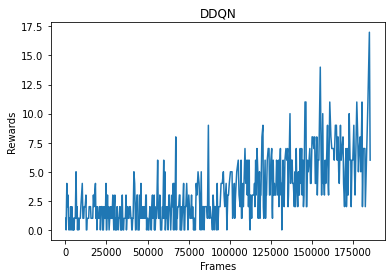

Episode:  511
Steps:  46045  epsilon:  0.12703736121373155
Episode:  512
Steps:  46182  epsilon:  0.12637492671782083
Episode:  513
Steps:  46352  epsilon:  0.1255592115414979
Episode:  514
Steps:  46526  epsilon:  0.12473145237454751
Episode:  515
Steps:  46588  epsilon:  0.12443823958682194
Episode:  516
Steps:  46727  epsilon:  0.12378416934853839
Episode:  517
Steps:  46888  epsilon:  0.12303223737207289
Steps:  47088  epsilon:  0.12210655114353387
Episode:  518
Steps:  47094  epsilon:  0.12207892332257118
Episode:  519
Steps:  47287  epsilon:  0.12119463526463681
Episode:  520
Steps:  47374  epsilon:  0.12079880016675579


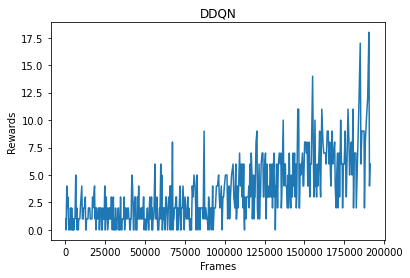

Episode:  521
Steps:  47480  epsilon:  0.1203188395450269
Episode:  522
Steps:  47585  epsilon:  0.11984590816854251
Episode:  523
Steps:  47678  epsilon:  0.11942909453829492
Episode:  524
Steps:  47796  epsilon:  0.11890301633727628
Episode:  525
Steps:  47922  epsilon:  0.11834468791554992
Episode:  526
Steps:  48057  epsilon:  0.11775036935381736
Episode:  527
Steps:  48157  epsilon:  0.1173127125608154
Steps:  48357  epsilon:  0.11644393655502415
Episode:  528
Steps:  48369  epsilon:  0.11639208574988821
Episode:  529
Steps:  48545  epsilon:  0.11563517070610065
Episode:  530
Steps:  48677  epsilon:  0.115071839616925


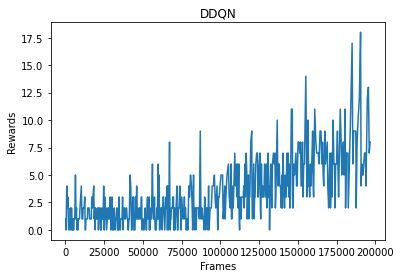

Episode:  531
Steps:  48825  epsilon:  0.11444463153581684
Episode:  532
Steps:  48940  epsilon:  0.11396046820802336
Episode:  533
Steps:  49090  epsilon:  0.11333312019221355
Episode:  534
Steps:  49185  epsilon:  0.11293822648633416
Steps:  49385  epsilon:  0.112112977344246
Episode:  535
Steps:  49438  epsilon:  0.11189566601896213
Episode:  536
Steps:  49519  epsilon:  0.11156465931261034
Episode:  537
Steps:  49611  epsilon:  0.11119032351219185
Episode:  538
Steps:  49761  epsilon:  0.11058367386569234
Episode:  539
Steps:  49937  epsilon:  0.1098776486030404
Episode:  540
Steps:  50104  epsilon:  0.1092134471374682


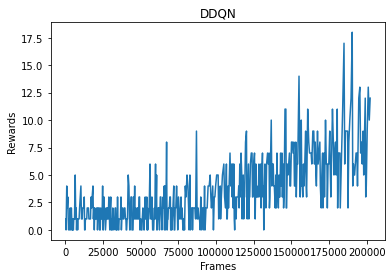

Episode:  541
Steps:  50250  epsilon:  0.10863729448912673
Episode:  542
Steps:  50404  epsilon:  0.10803411255223594
Episode:  543
Steps:  50525  epsilon:  0.10756343141740247
Episode:  544
Steps:  50649  epsilon:  0.107084025835613
Episode:  545
Steps:  50794  epsilon:  0.10652718762588032
Episode:  546
Steps:  50929  epsilon:  0.10601236857839297
Episode:  547
Steps:  51050  epsilon:  0.10555388206866416
Episode:  548
Steps:  51182  epsilon:  0.10505686839628813
Episode:  549
Steps:  51264  epsilon:  0.1047497652275595
Episode:  550
Steps:  51383  epsilon:  0.10430632466836036
Steps:  51583  epsilon:  0.1035669643844219


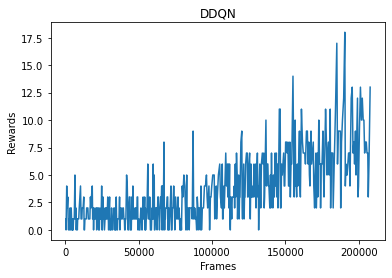

Episode:  551
Steps:  51584  epsilon:  0.10356328612815985
Episode:  552
Steps:  51775  epsilon:  0.10286410067014502
Episode:  553
Steps:  51929  epsilon:  0.1023052016177609
Episode:  554
Steps:  52009  epsilon:  0.10201655848241796
Episode:  555
Steps:  52157  epsilon:  0.10148560290819773
Episode:  556
Steps:  52292  epsilon:  0.10100469996193803
Episode:  557
Steps:  52455  epsilon:  0.10042836341880082
Episode:  558
Steps:  52587  epsilon:  0.09996506678090734
Episode:  559
Steps:  52714  epsilon:  0.09952219620905062
Episode:  560
Steps:  52838  epsilon:  0.09909249205192637


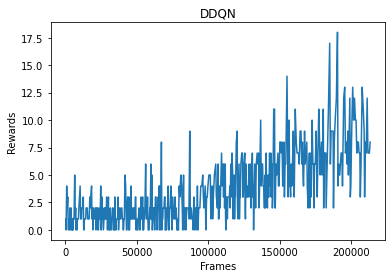

Episode:  561
Steps:  52976  epsilon:  0.09861739482714033
Episode:  562
Steps:  53134  epsilon:  0.09807745298642136
Episode:  563
Steps:  53300  epsilon:  0.09751474858030793
Episode:  564
Steps:  53411  epsilon:  0.09714107961622359
Episode:  565
Steps:  53558  epsilon:  0.09664940181045059
Episode:  566
Steps:  53699  epsilon:  0.09618117596313006
Episode:  567
Steps:  53823  epsilon:  0.0957721220496257
Steps:  54023  epsilon:  0.09511767850056192
Episode:  568
Steps:  54025  epsilon:  0.09511116705828938
Episode:  569
Steps:  54190  epsilon:  0.09457620966351997
Episode:  570
Steps:  54316  epsilon:  0.0941706583705726


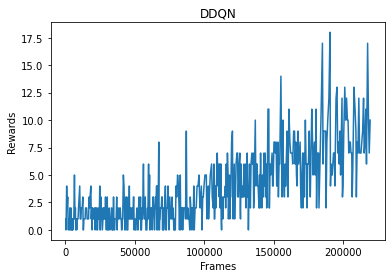

Episode:  571
Steps:  54482  epsilon:  0.09364024616176796
Episode:  572
Steps:  54638  epsilon:  0.09314578315435997
Steps:  54838  epsilon:  0.09251747211393511
Episode:  573
Steps:  54867  epsilon:  0.09242688746910858
Episode:  574
Steps:  55012  epsilon:  0.09197592923384965
Episode:  575
Steps:  55120  epsilon:  0.09164216120073221
Episode:  576
Steps:  55284  epsilon:  0.0911387622353533
Episode:  577
Steps:  55445  epsilon:  0.09064857086674996
Episode:  578
Steps:  55565  epsilon:  0.09028576893574763
Episode:  579
Steps:  55718  epsilon:  0.08982634235064105
Episode:  580
Steps:  55903  epsilon:  0.0892755002561977


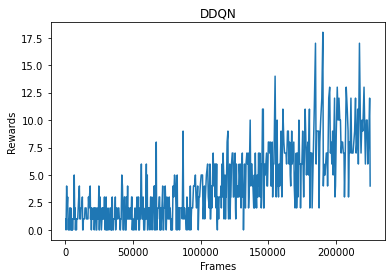

Episode:  581
Steps:  55996  epsilon:  0.08900050903010669
Episode:  582
Steps:  56156  epsilon:  0.08853038794949802
Episode:  583
Steps:  56300  epsilon:  0.08811048262940338
Episode:  584
Steps:  56365  epsilon:  0.08792193012464351
Episode:  585
Steps:  56515  epsilon:  0.0874891406379825
Steps:  56715  epsilon:  0.0869171141310171
Episode:  586
Steps:  56745  epsilon:  0.08683180245957009
Episode:  587
Steps:  56864  epsilon:  0.08649465723662199
Episode:  588
Steps:  56942  epsilon:  0.08627475715727717
Steps:  57142  epsilon:  0.08571481396783706
Episode:  589
Steps:  57176  epsilon:  0.08562017924639614
Episode:  590
Steps:  57326  epsilon:  0.0852045883161174


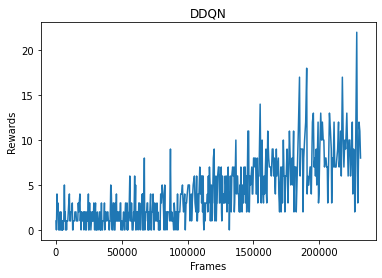

Episode:  591
Steps:  57460  epsilon:  0.0848359538787635
Episode:  592
Steps:  57576  epsilon:  0.08451882590640143
Episode:  593
Steps:  57760  epsilon:  0.08401955288549279
Episode:  594
Steps:  57892  epsilon:  0.08366419779817472
Episode:  595
Steps:  58041  epsilon:  0.08326588508172468
Episode:  596
Steps:  58170  epsilon:  0.08292342574158242
Episode:  597
Steps:  58264  epsilon:  0.0826752692651312
Episode:  598
Steps:  58416  epsilon:  0.08227645463394063
Episode:  599
Steps:  58553  epsilon:  0.08191958459501655
Episode:  600
Steps:  58701  epsilon:  0.08153679772720682


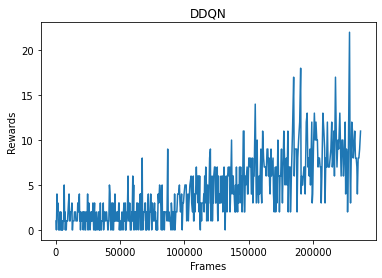

Episode:  601
Steps:  58876  epsilon:  0.08108781789842585
Steps:  59076  epsilon:  0.08057948561694431
Episode:  602
Steps:  59107  epsilon:  0.08050114814146536
Episode:  603
Steps:  59246  epsilon:  0.08015138200707958
Episode:  604
Steps:  59366  epsilon:  0.0798513746371684
Episode:  605
Steps:  59532  epsilon:  0.0794393206173927
Episode:  606
Steps:  59656  epsilon:  0.07913374509255153
Episode:  607
Steps:  59780  epsilon:  0.07883005827492184
Episode:  608
Steps:  59920  epsilon:  0.07848944141685166
Episode:  609
Steps:  60031  epsilon:  0.07822107043533624
Episode:  610
Steps:  60182  epsilon:  0.0778583722620439


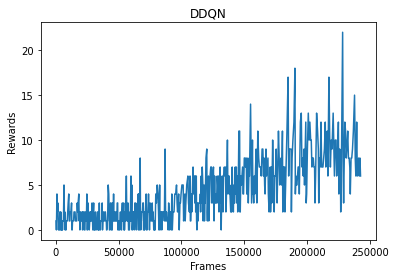

Episode:  611
Steps:  60294  epsilon:  0.07759111439782976
Episode:  612
Steps:  60411  epsilon:  0.07731351913640863
Episode:  613
Steps:  60511  epsilon:  0.07707754197524838
Episode:  614
Steps:  60585  epsilon:  0.07690367691864569
Episode:  615
Steps:  60766  epsilon:  0.07648111362551195
Episode:  616
Steps:  60843  epsilon:  0.07630250537954555
Episode:  617
Steps:  61008  epsilon:  0.07592208111795976
Episode:  618
Steps:  61204  epsilon:  0.0754742427153707
Episode:  619
Steps:  61295  epsilon:  0.07526780491316389
Episode:  620
Steps:  61372  epsilon:  0.07509385892513465


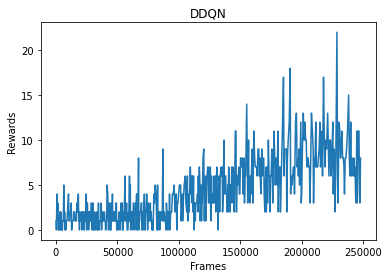

Episode:  621
Steps:  61513  epsilon:  0.07477706522960798
Episode:  622
Steps:  61644  epsilon:  0.07448473388266003
Episode:  623
Steps:  61782  epsilon:  0.07417884574654948
Episode:  624
Steps:  61977  epsilon:  0.07375019506828884
Episode:  625
Steps:  62105  epsilon:  0.07347108791542606
Episode:  626
Steps:  62278  epsilon:  0.07309668463363095
Episode:  627
Steps:  62465  epsilon:  0.0726956085847533
Episode:  628
Steps:  62648  epsilon:  0.07230672561895538
Episode:  629
Steps:  62774  epsilon:  0.07204103106418765
Episode:  630
Steps:  62883  epsilon:  0.07181253067403678


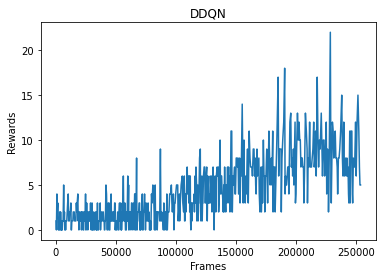

Episode:  631
Steps:  63001  epsilon:  0.07156656306102899
Episode:  632
Steps:  63149  epsilon:  0.07126010578476497
Episode:  633
Steps:  63326  epsilon:  0.07089656488981286
Steps:  63526  epsilon:  0.07048963727007126
Episode:  634
Steps:  63553  epsilon:  0.07043501313934095
Episode:  635
Steps:  63692  epsilon:  0.07015496409570399
Episode:  636
Steps:  63833  epsilon:  0.06987286715894064
Episode:  637
Steps:  64023  epsilon:  0.069495868499901
Episode:  638
Steps:  64124  epsilon:  0.06929691713897573
Episode:  639
Steps:  64271  epsilon:  0.06900914366105468
Episode:  640
Steps:  64427  epsilon:  0.06870605591934442


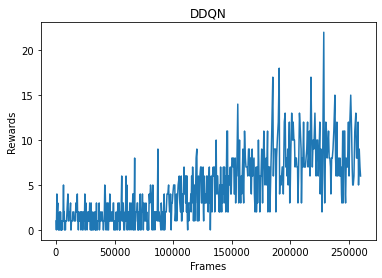

Episode:  641
Steps:  64547  epsilon:  0.0684745149015045
Episode:  642
Steps:  64656  epsilon:  0.06826539915330992
Episode:  643
Steps:  64791  epsilon:  0.06800797748455428
Episode:  644
Steps:  64968  epsilon:  0.06767309094252422
Episode:  645
Steps:  65066  epsilon:  0.06748894432456638
Episode:  646
Steps:  65189  epsilon:  0.06725909482862674
Episode:  647
Steps:  65385  epsilon:  0.06689573905067092
Episode:  648
Steps:  65543  epsilon:  0.06660541101784642
Episode:  649
Steps:  65688  epsilon:  0.06634098150321294
Episode:  650
Steps:  65872  epsilon:  0.0660081777181673


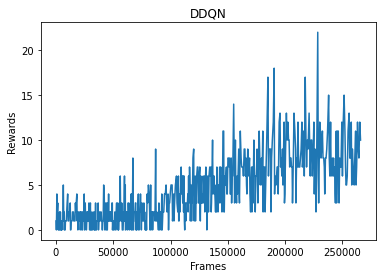

Episode:  651
Steps:  66036  epsilon:  0.06571411795362597
Episode:  652
Steps:  66204  epsilon:  0.06541537583630984
Episode:  653
Steps:  66367  epsilon:  0.06512791352333133
Episode:  654
Steps:  66530  epsilon:  0.06484278450710407
Episode:  655
Steps:  66668  epsilon:  0.06460319682208177
Episode:  656
Steps:  66847  epsilon:  0.06429487998644
Episode:  657
Steps:  66985  epsilon:  0.06405905982969007
Episode:  658
Steps:  67136  epsilon:  0.06380288221536587
Episode:  659
Steps:  67200  epsilon:  0.06369488587857242
Episode:  660
Steps:  67396  epsilon:  0.06336628875274708


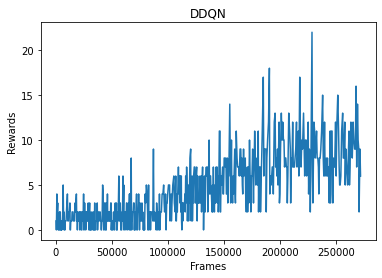

Episode:  661
Steps:  67522  epsilon:  0.06315674189926898
Episode:  662
Steps:  67669  epsilon:  0.06291393326114761
Episode:  663
Steps:  67836  epsilon:  0.06264024615227384
Episode:  664
Steps:  67956  epsilon:  0.062444991026502555
Episode:  665
Steps:  68083  epsilon:  0.062239618082676314
Episode:  666
Steps:  68245  epsilon:  0.061979531947075214
Episode:  667
Steps:  68407  epsilon:  0.06172154400003697
Episode:  668
Steps:  68533  epsilon:  0.061522326466977424
Episode:  669
Steps:  68648  epsilon:  0.06134159319590418
Episode:  670
Steps:  68768  epsilon:  0.06115410665879935


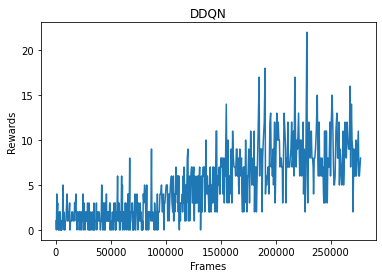

Episode:  671
Steps:  68907  epsilon:  0.06093833628807894
Episode:  672
Steps:  69091  epsilon:  0.06065500889861983
Episode:  673
Steps:  69230  epsilon:  0.06044269523137415
Episode:  674
Steps:  69365  epsilon:  0.06023789900341682
Episode:  675
Steps:  69489  epsilon:  0.060051004002784195
Steps:  69689  epsilon:  0.05975199151695208
Episode:  676
Steps:  69692  epsilon:  0.059747529052917706
Episode:  677
Steps:  69810  epsilon:  0.059572535370495845
Episode:  678
Steps:  69933  epsilon:  0.05939122238686746
Episode:  679
Steps:  70102  epsilon:  0.059143912911771845
Episode:  680
Steps:  70255  epsilon:  0.0589218125948634
Steps:  70455  epsilon:  0.058634035751269103


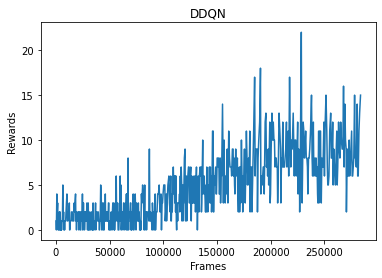

Episode:  681
Steps:  70467  epsilon:  0.05861686048291411
Steps:  70667  epsilon:  0.05833211796353224
Episode:  682
Steps:  70705  epsilon:  0.0582783380465015
Steps:  70905  epsilon:  0.05799696388164159
Episode:  683
Steps:  70906  epsilon:  0.05799556406844314
Episode:  684
Steps:  71041  epsilon:  0.05780723035235198
Episode:  685
Steps:  71164  epsilon:  0.057636740678793014
Steps:  71364  epsilon:  0.05736175051440789
Episode:  686
Steps:  71381  epsilon:  0.05733850290810302
Episode:  687
Steps:  71516  epsilon:  0.05715458941979237
Episode:  688
Steps:  71653  epsilon:  0.05696921611069814
Episode:  689
Steps:  71846  epsilon:  0.05671021486613541
Episode:  690
Steps:  72031  epsilon:  0.05646428455982217


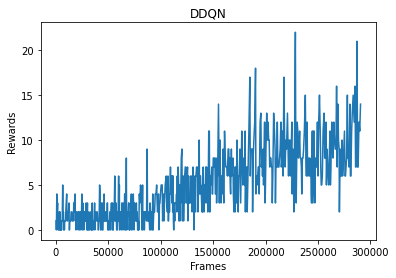

Episode:  691
Steps:  72218  epsilon:  0.056217996689238645
Episode:  692
Steps:  72412  epsilon:  0.055964911568583346
Episode:  693
Steps:  72556  epsilon:  0.055778635603475415
Episode:  694
Steps:  72631  epsilon:  0.055682146749636174
Episode:  695
Steps:  72741  epsilon:  0.05554128267381636
Episode:  696
Steps:  72831  epsilon:  0.05542660511979903
Episode:  697
Steps:  72973  epsilon:  0.05524671558697529
Episode:  698
Steps:  73139  epsilon:  0.055038035069748595
Episode:  699
Steps:  73255  epsilon:  0.05489323479306962
Episode:  700
Steps:  73406  epsilon:  0.054705998576509665


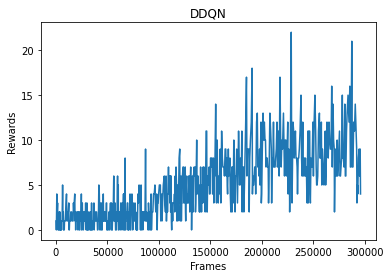

Episode:  701
Steps:  73490  epsilon:  0.05460245098464614
Episode:  702
Steps:  73657  epsilon:  0.05439787580890608
Episode:  703
Steps:  73781  epsilon:  0.05424707693844802
Episode:  704
Steps:  73939  epsilon:  0.05405627967213995
Episode:  705
Steps:  74115  epsilon:  0.0538455131438943
Episode:  706
Steps:  74239  epsilon:  0.053698128327455505
Steps:  74439  epsilon:  0.05346232801076377
Episode:  707
Steps:  74465  epsilon:  0.05343184680142862
Episode:  708
Steps:  74592  epsilon:  0.05328352599120051
Episode:  709
Steps:  74782  epsilon:  0.053063379844162525
Episode:  710
Steps:  74912  epsilon:  0.05291395403515773


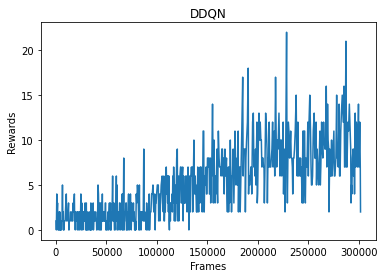

Episode:  711
Steps:  74973  epsilon:  0.052844172945606935
Episode:  712
Steps:  75124  epsilon:  0.052672348891869746
Episode:  713
Steps:  75243  epsilon:  0.05253784895009252
Episode:  714
Steps:  75391  epsilon:  0.052371684434831686
Episode:  715
Steps:  75509  epsilon:  0.05224008011118293
Episode:  716
Steps:  75654  epsilon:  0.05207942261750412
Episode:  717
Steps:  75845  epsilon:  0.05186956778327842
Episode:  718
Steps:  75943  epsilon:  0.05176266901700425
Episode:  719
Steps:  76135  epsilon:  0.051554747016880106
Steps:  76335  epsilon:  0.051340273700567526
Episode:  720
Steps:  76397  epsilon:  0.051274221286234954


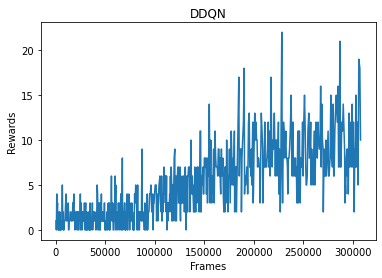

Episode:  721
Steps:  76569  epsilon:  0.05109204745345098
Steps:  76769  epsilon:  0.050882178074718704
Episode:  722
Steps:  76775  epsilon:  0.050875914360900346
Episode:  723
Steps:  76901  epsilon:  0.05074480951432238
Episode:  724
Steps:  77014  epsilon:  0.05062793183094083
Steps:  77214  epsilon:  0.05042268047981214
Episode:  725
Steps:  77218  epsilon:  0.05041859635214256
Episode:  726
Steps:  77330  epsilon:  0.05030457177935842
Episode:  727
Steps:  77445  epsilon:  0.05018815550915485
Episode:  728
Steps:  77599  epsilon:  0.05003330365646365
Episode:  729
Steps:  77714  epsilon:  0.04991844270214832
Episode:  730
Steps:  77826  epsilon:  0.049807211162013615


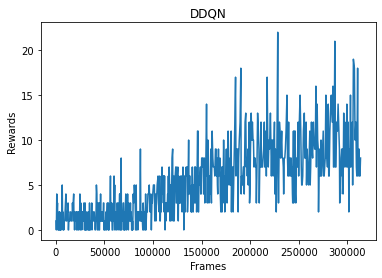

Episode:  731
Steps:  77965  epsilon:  0.04967002830704775
Episode:  732
Steps:  78102  epsilon:  0.04953574904467757
Episode:  733
Steps:  78259  epsilon:  0.04938299376358453
Steps:  78459  epsilon:  0.04919012975319803
Episode:  734
Steps:  78567  epsilon:  0.04908678234167595
Episode:  735
Steps:  78722  epsilon:  0.04893943150055822
Episode:  736
Steps:  78847  epsilon:  0.04882142919500641
Episode:  737
Steps:  79037  epsilon:  0.048643472251517925
Episode:  738
Steps:  79166  epsilon:  0.048523608830579365
Episode:  739
Steps:  79272  epsilon:  0.04842569340884846
Steps:  79472  epsilon:  0.04824235469614356
Episode:  740
Steps:  79481  epsilon:  0.048234147483291676


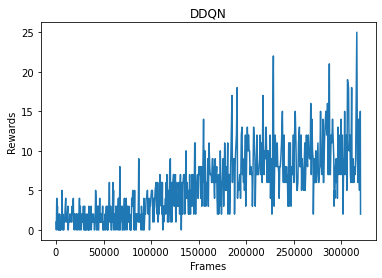

Episode:  741
Steps:  79539  epsilon:  0.04818134505611524
Episode:  742
Steps:  79712  epsilon:  0.04802475465125345
Episode:  743
Steps:  79887  epsilon:  0.04786772605005912
Episode:  744
Steps:  80052  epsilon:  0.047720923702473536
Episode:  745
Steps:  80192  epsilon:  0.04759731038791115
Steps:  80392  epsilon:  0.04742221422398395
Episode:  746
Steps:  80458  epsilon:  0.04736481567673692
Episode:  747
Steps:  80610  epsilon:  0.04723334330542445
Episode:  748
Steps:  80766  epsilon:  0.04709944610557966
Episode:  749
Steps:  80925  epsilon:  0.046964044443788794
Episode:  750
Steps:  81115  epsilon:  0.04680364910573335


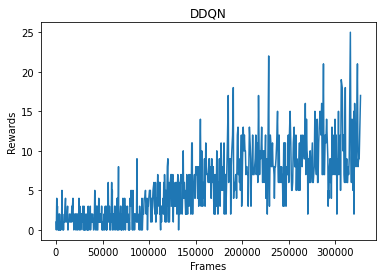

Episode:  751
Steps:  81285  epsilon:  0.0466614234038837
Episode:  752
Steps:  81445  epsilon:  0.04652866376326576
Episode:  753
Steps:  81602  epsilon:  0.046399421691539926
Episode:  754
Steps:  81770  epsilon:  0.04626224350432409
Episode:  755
Steps:  81864  epsilon:  0.046185990295264455
Steps:  82064  epsilon:  0.04602493700089221
Episode:  756
Steps:  82098  epsilon:  0.04599771775090849
Episode:  757
Steps:  82269  epsilon:  0.04586152033777596
Episode:  758
Steps:  82461  epsilon:  0.04570997830811668
Episode:  759
Steps:  82610  epsilon:  0.04559337386060755
Steps:  82810  epsilon:  0.04543821719828312
Episode:  760
Steps:  82884  epsilon:  0.04538120133903467


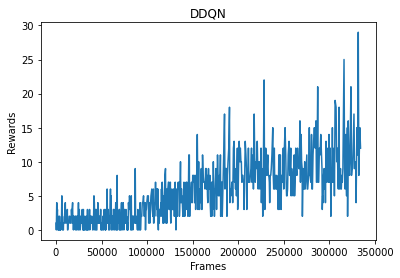

Episode:  761
Steps:  83080  epsilon:  0.04523120176432289
Episode:  762
Steps:  83252  epsilon:  0.045100775067806936
Episode:  763
Steps:  83390  epsilon:  0.04499693836842372
Episode:  764
Steps:  83573  epsilon:  0.044860342262549646
Episode:  765
Steps:  83771  epsilon:  0.04471395070799651
Steps:  83971  epsilon:  0.0445675444522454
Episode:  766
Steps:  84021  epsilon:  0.04453117107677859
Steps:  84221  epsilon:  0.04438658350874536
Episode:  767
Steps:  84307  epsilon:  0.04432485401318804
Episode:  768
Steps:  84462  epsilon:  0.04421426547867517
Episode:  769
Steps:  84549  epsilon:  0.044152567713771226
Episode:  770
Steps:  84740  epsilon:  0.04401805401733576


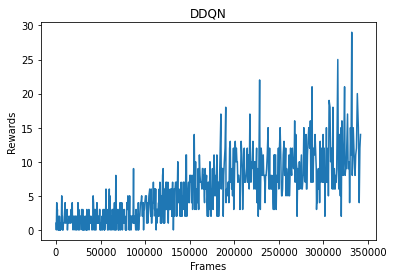

Episode:  771
Steps:  84918  epsilon:  0.04389384687822008
Episode:  772
Steps:  85046  epsilon:  0.043805210198122106
Steps:  85246  epsilon:  0.043667846061523116
Episode:  773
Steps:  85260  epsilon:  0.04365828191712112
Episode:  774
Steps:  85410  epsilon:  0.04355622798337164
Episode:  775
Steps:  85527  epsilon:  0.043477155562005945
Episode:  776
Steps:  85649  epsilon:  0.04339519514649046
Steps:  85849  epsilon:  0.04326191072782055
Episode:  777
Steps:  85851  epsilon:  0.043260584603055104
Steps:  86051  epsilon:  0.043128639581671485
Episode:  778
Steps:  86056  epsilon:  0.04312535783201187
Episode:  779
Steps:  86171  epsilon:  0.04305010358777099
Episode:  780
Steps:  86349  epsilon:  0.042934472985278256


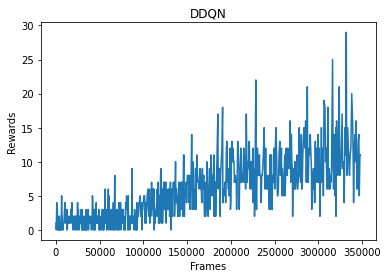

Episode:  781
Steps:  86523  epsilon:  0.042822431158953775
Steps:  86723  epsilon:  0.04269484583718234
Episode:  782
Steps:  86729  epsilon:  0.042691037954642116
Episode:  783
Steps:  86811  epsilon:  0.042639111221571574
Episode:  784
Steps:  86979  epsilon:  0.04253338734922983
Episode:  785
Steps:  87074  epsilon:  0.04247399492799152
Steps:  87274  epsilon:  0.042349876604645974
Episode:  786
Steps:  87291  epsilon:  0.042339383669661154
Episode:  787
Steps:  87461  epsilon:  0.04223494340839605
Episode:  788
Steps:  87629  epsilon:  0.042132600326486164
Episode:  789
Steps:  87803  epsilon:  0.042027504533237246
Episode:  790
Steps:  87980  epsilon:  0.04192153074381307


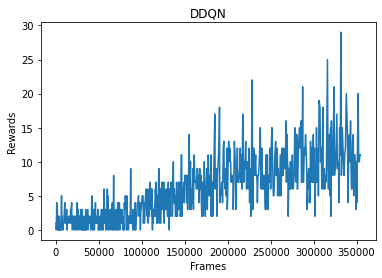

Episode:  791
Steps:  88157  epsilon:  0.0418164906845749
Episode:  792
Steps:  88326  epsilon:  0.04171706201603541
Episode:  793
Steps:  88495  epsilon:  0.041618469979994646
Episode:  794
Steps:  88602  epsilon:  0.041556477144302904
Episode:  795
Steps:  88719  epsilon:  0.0414890691137373
Episode:  796
Steps:  88807  epsilon:  0.04143862826089101
Steps:  89007  epsilon:  0.04132481200801367
Episode:  797
Steps:  89016  epsilon:  0.0413197169890753
Episode:  798
Steps:  89190  epsilon:  0.041221662606312603
Episode:  799
Steps:  89341  epsilon:  0.04113725808165423
Episode:  800
Steps:  89461  epsilon:  0.04107063460346917


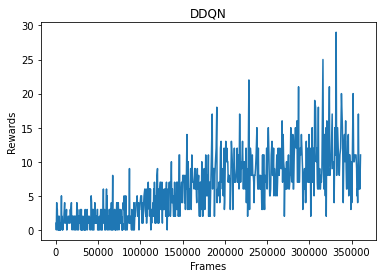

Episode:  801
Steps:  89650  epsilon:  0.040966509870710766
Episode:  802
Steps:  89809  epsilon:  0.04087967175610917
Episode:  803
Steps:  89913  epsilon:  0.04082324430150917
Episode:  804
Steps:  90081  epsilon:  0.040732709826513565
Episode:  805
Steps:  90206  epsilon:  0.04066583957730308
Episode:  806
Steps:  90351  epsilon:  0.04058879187577038
Episode:  807
Steps:  90479  epsilon:  0.04052124000433095
Episode:  808
Steps:  90595  epsilon:  0.04046039343792153
Steps:  90795  epsilon:  0.0403563107841651
Episode:  809
Steps:  90827  epsilon:  0.040339753935921166
Episode:  810
Steps:  90965  epsilon:  0.040268655206463916


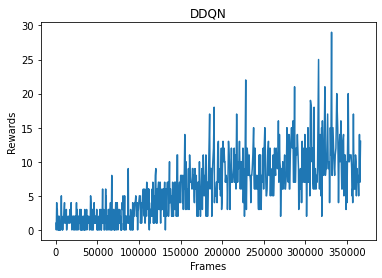

Episode:  811
Steps:  91150  epsilon:  0.04017410810030969
Episode:  812
Steps:  91274  epsilon:  0.04011122377294195
Episode:  813
Steps:  91418  epsilon:  0.04003868441682852
Episode:  814
Steps:  91544  epsilon:  0.039975639504995684
Episode:  815
Steps:  91693  epsilon:  0.03990159714095057
Episode:  816
Steps:  91868  epsilon:  0.039815336108347546
Episode:  817
Steps:  92043  epsilon:  0.039729826567209976
Episode:  818
Steps:  92165  epsilon:  0.03967065528105296
Episode:  819
Steps:  92307  epsilon:  0.039602236801574014
Steps:  92507  epsilon:  0.0395066929490185
Episode:  820
Steps:  92509  epsilon:  0.03950574232725548


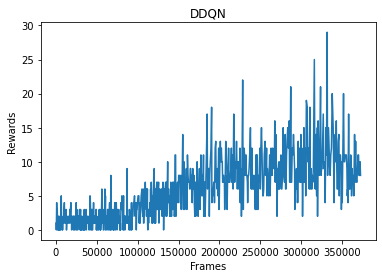

Episode:  821
Steps:  92645  epsilon:  0.03944132255488686
Episode:  822
Steps:  92835  epsilon:  0.039352054684368164
Episode:  823
Steps:  93006  epsilon:  0.039272435473970954
Episode:  824
Steps:  93162  epsilon:  0.039200391812813484
Episode:  825
Steps:  93349  epsilon:  0.03911476905951404
Episode:  826
Steps:  93498  epsilon:  0.039047116349273894
Episode:  827
Steps:  93593  epsilon:  0.03900424444798847
Episode:  828
Steps:  93706  epsilon:  0.03895351391556515
Episode:  829
Steps:  93834  epsilon:  0.03889639440391063
Steps:  94034  epsilon:  0.038807873800558744
Episode:  830
Steps:  94163  epsilon:  0.038751245836052606


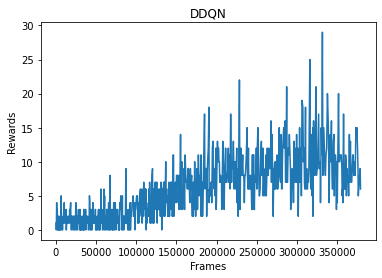

Episode:  831
Steps:  94285  epsilon:  0.03869802572282463
Episode:  832
Steps:  94423  epsilon:  0.03863821592642988
Episode:  833
Steps:  94548  epsilon:  0.03858439544110312
Episode:  834
Steps:  94729  epsilon:  0.038507057145995754
Episode:  835
Steps:  94875  epsilon:  0.03844518174880781
Episode:  836
Steps:  94978  epsilon:  0.03840180086445939
Episode:  837
Steps:  95160  epsilon:  0.0383256913003283
Episode:  838
Steps:  95337  epsilon:  0.03825233401709191
Episode:  839
Steps:  95474  epsilon:  0.03819599869782597
Episode:  840
Steps:  95632  epsilon:  0.03813150539208939
Steps:  95832  epsilon:  0.03805059556156857


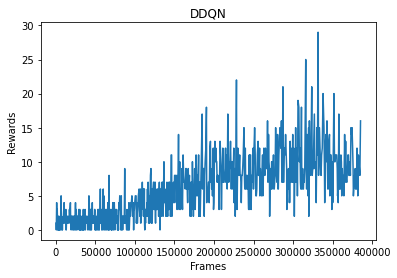

Episode:  841
Steps:  95841  epsilon:  0.03804697360856641
Episode:  842
Steps:  96001  epsilon:  0.037982854637549426
Episode:  843
Steps:  96152  epsilon:  0.03792281103485545
Episode:  844
Steps:  96315  epsilon:  0.03785850253800657
Steps:  96515  epsilon:  0.03778030913127082
Episode:  845
Steps:  96619  epsilon:  0.0377399565314755
Episode:  846
Steps:  96792  epsilon:  0.0376732946358272
Episode:  847
Steps:  96961  epsilon:  0.03760872847237671
Episode:  848
Steps:  97121  epsilon:  0.03754810147592713
Episode:  849
Steps:  97281  epsilon:  0.03748795756054843
Episode:  850
Steps:  97396  epsilon:  0.03744502535295921


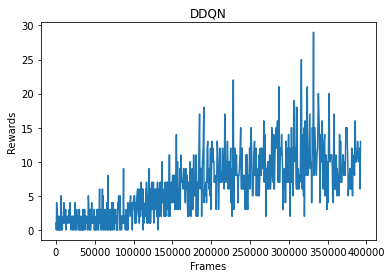

Episode:  851
Steps:  97554  epsilon:  0.037386441364112025
Steps:  97754  epsilon:  0.03731294504453709
Episode:  852
Steps:  97788  epsilon:  0.03730052359918142
Episode:  853
Steps:  97976  epsilon:  0.03723222020623587
Steps:  98176  epsilon:  0.037160258412821195
Episode:  854
Steps:  98236  epsilon:  0.03713880982654858
Steps:  98436  epsilon:  0.037067777481941344
Episode:  855
Steps:  98453  epsilon:  0.03706177242359305
Episode:  856
Steps:  98593  epsilon:  0.037012512627059777
Steps:  98793  epsilon:  0.03694273696058446
Episode:  857
Steps:  98819  epsilon:  0.03693371726660707
Episode:  858
Steps:  98980  epsilon:  0.0368781249020881
Steps:  99180  epsilon:  0.03680968641581833
Episode:  859
Steps:  99184  epsilon:  0.03680832461471981
Episode:  860
Steps:  99302  epsilon:  0.036768273765678414


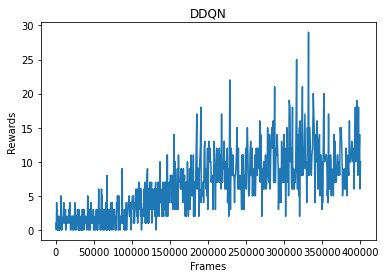

Episode:  861
Steps:  99482  epsilon:  0.03670763259637651
Episode:  862
Steps:  99629  epsilon:  0.03665851223525379
Episode:  863
Steps:  99802  epsilon:  0.036601164490987485
Episode:  864
Steps:  99935  epsilon:  0.03655741238411329
Episode:  865
Steps:  100111  epsilon:  0.03649996031499409
Steps:  100311  epsilon:  0.036435284629236085
Episode:  866
Steps:  100398  epsilon:  0.03640735193874707
Steps:  100598  epsilon:  0.036343597721728946
Episode:  867
Steps:  100634  epsilon:  0.03633218951629494
Episode:  868
Steps:  100749  epsilon:  0.036295883905237504
Episode:  869
Steps:  100869  epsilon:  0.03625822170140412
Episode:  870
Steps:  100982  epsilon:  0.03622296244997338
Steps:  101182  epsilon:  0.03616104293902346


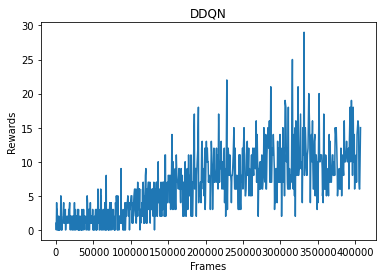

Episode:  871
Steps:  101266  epsilon:  0.03613522082308154
Episode:  872
Steps:  101410  epsilon:  0.03609120587710527
Episode:  873
Steps:  101610  epsilon:  0.03603059736596003
Steps:  101810  epsilon:  0.0359705919195769
Episode:  874
Steps:  101816  epsilon:  0.035968801010650794
Steps:  102016  epsilon:  0.03590941044827669
Episode:  875
Steps:  102061  epsilon:  0.03589612922175092
Episode:  876
Steps:  102179  epsilon:  0.03586144447994551
Episode:  877
Steps:  102334  epsilon:  0.035816193857875024
Steps:  102534  epsilon:  0.0357583217620421
Steps:  102734  epsilon:  0.03570102550318399
Episode:  878
Steps:  102777  epsilon:  0.03568878146540926
Episode:  879
Steps:  102898  epsilon:  0.03565446823971369
Episode:  880
Steps:  103071  epsilon:  0.0356057680215394


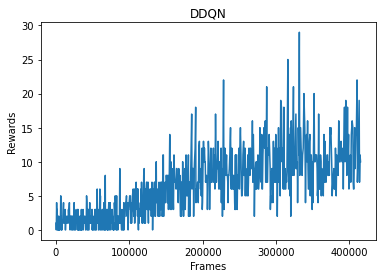

Episode:  881
Steps:  103243  epsilon:  0.03555776512486734
Steps:  103443  epsilon:  0.03550246443789183
Episode:  882
Steps:  103542  epsilon:  0.03547529453989931
Episode:  883
Steps:  103728  epsilon:  0.03542461034747879
Steps:  103928  epsilon:  0.0353706345726754
Episode:  884
Steps:  103989  epsilon:  0.03535427909201565
Episode:  885
Steps:  104182  epsilon:  0.03530285880071477
Episode:  886
Steps:  104314  epsilon:  0.03526797517522165
Episode:  887
Steps:  104489  epsilon:  0.03522208147020892
Steps:  104689  epsilon:  0.035170120891404956
Episode:  888
Steps:  104691  epsilon:  0.035169603905165554
Episode:  889
Steps:  104841  epsilon:  0.03513097690817939
Episode:  890
Steps:  104958  epsilon:  0.03510104831974027
Steps:  105158  epsilon:  0.035050292040905325


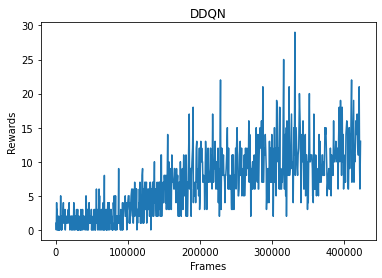

Episode:  891
Steps:  105159  epsilon:  0.03505003953261604
Steps:  105359  epsilon:  0.03499979079969324
Episode:  892
Steps:  105370  epsilon:  0.034997041670833146
Steps:  105570  epsilon:  0.03494732027544602
Episode:  893
Steps:  105598  epsilon:  0.03494039887317248
Episode:  894
Steps:  105752  epsilon:  0.034902503884786974
Episode:  895
Steps:  105869  epsilon:  0.03487390796168799
Episode:  896
Steps:  105998  epsilon:  0.03484257242108985
Episode:  897
Steps:  106187  epsilon:  0.034797025659113696
Episode:  898
Steps:  106293  epsilon:  0.034771668678475524
Episode:  899
Steps:  106479  epsilon:  0.034727497872374696
Episode:  900
Steps:  106587  epsilon:  0.03470203818688171


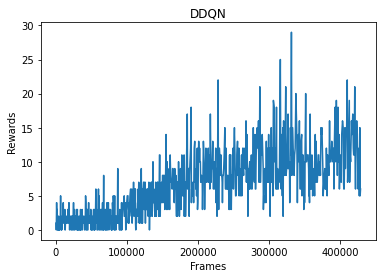

Episode:  901
Steps:  106717  epsilon:  0.034671574054356745
Episode:  902
Steps:  106909  epsilon:  0.0346269415223658
Episode:  903
Steps:  107086  epsilon:  0.03458617375335651
Steps:  107286  epsilon:  0.03454054056205541
Episode:  904
Steps:  107326  epsilon:  0.0345314685559614
Episode:  905
Steps:  107438  epsilon:  0.03450616325302738
Episode:  906
Steps:  107609  epsilon:  0.03446779979470344
Episode:  907
Steps:  107755  epsilon:  0.03443530361158051
Episode:  908
Steps:  107945  epsilon:  0.03439336773806195
Episode:  909
Steps:  108121  epsilon:  0.03435487571526883
Episode:  910
Steps:  108270  epsilon:  0.03432255244487402


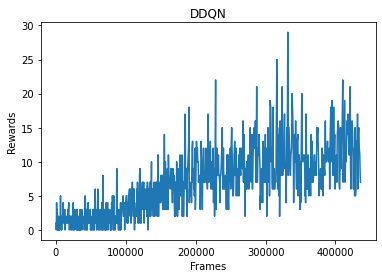

Episode:  911
Steps:  108392  epsilon:  0.034296265132774714
Steps:  108592  epsilon:  0.03425351658044595
Episode:  912
Steps:  108649  epsilon:  0.03424141131638671
Episode:  913
Steps:  108816  epsilon:  0.034206142982106634
Episode:  914
Steps:  108961  epsilon:  0.03417575872152026
Episode:  915
Steps:  109077  epsilon:  0.0341516094216037
Steps:  109277  epsilon:  0.03411030021765023
Episode:  916
Steps:  109284  epsilon:  0.034108861864300566
Episode:  917
Steps:  109445  epsilon:  0.03407591830203298
Episode:  918
Steps:  109569  epsilon:  0.03405072578605987
Episode:  919
Steps:  109696  epsilon:  0.034025085172424425
Episode:  920
Steps:  109836  epsilon:  0.033997007961105594


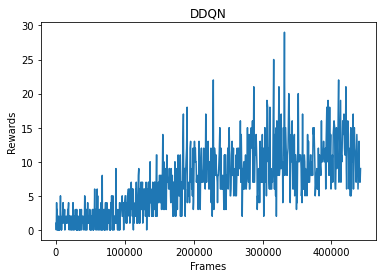

Episode:  921
Steps:  109981  epsilon:  0.03396813444635046
Steps:  110181  epsilon:  0.03392865084890362
Episode:  922
Steps:  110212  epsilon:  0.033922566156942294
Episode:  923
Steps:  110409  epsilon:  0.03388411854563853
Steps:  110609  epsilon:  0.03384547092037149
Episode:  924
Steps:  110613  epsilon:  0.0338447019030917
Episode:  925
Steps:  110802  epsilon:  0.03380854060136563
Episode:  926
Steps:  110907  epsilon:  0.033788598157927764
Episode:  927
Steps:  111065  epsilon:  0.03375878614497843
Episode:  928
Steps:  111195  epsilon:  0.033734433267629815
Episode:  929
Steps:  111364  epsilon:  0.033703010255716925
Episode:  930
Steps:  111502  epsilon:  0.033677547432715504


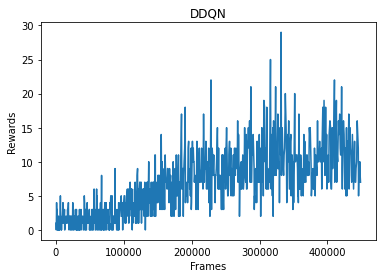

Episode:  931
Steps:  111631  epsilon:  0.033653903585153085
Episode:  932
Steps:  111773  epsilon:  0.03362805274876265
Episode:  933
Steps:  111955  epsilon:  0.033595187233641834
Episode:  934
Steps:  112128  epsilon:  0.03356422297754679
Episode:  935
Steps:  112248  epsilon:  0.033542901667575314
Episode:  936
Steps:  112432  epsilon:  0.0335104564490853
Episode:  937
Steps:  112581  epsilon:  0.03348440072661883
Steps:  112781  epsilon:  0.03344973036010446
Episode:  938
Steps:  112817  epsilon:  0.03344352643066782
Episode:  939
Steps:  113000  epsilon:  0.03341216187549341
Episode:  940
Steps:  113129  epsilon:  0.033390224256273394
Steps:  113329  epsilon:  0.033356490961295865


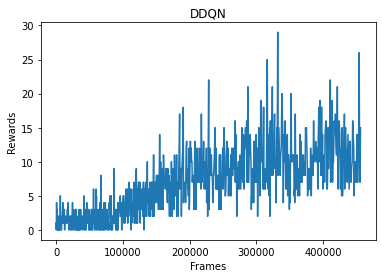

Episode:  941
Steps:  113331  epsilon:  0.03335615532898163
Episode:  942
Steps:  113496  epsilon:  0.033328580948236375
Episode:  943
Steps:  113567  epsilon:  0.03331678543529335
Steps:  113767  epsilon:  0.03328378286879385
Episode:  944
Steps:  113771  epsilon:  0.033283126177891365
Episode:  945
Steps:  113919  epsilon:  0.033258920714845736
Episode:  946
Steps:  114035  epsilon:  0.03324007368392378
Episode:  947
Steps:  114137  epsilon:  0.033223591373752095
Episode:  948
Steps:  114295  epsilon:  0.033198225329697906
Episode:  949
Steps:  114456  epsilon:  0.03317258296478657
Steps:  114656  epsilon:  0.03314101523684238
Episode:  950
Steps:  114671  epsilon:  0.03313866035860447


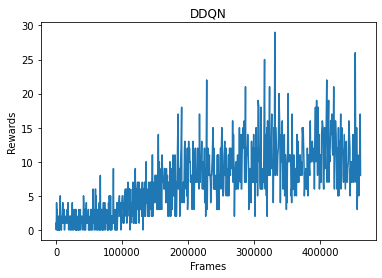

Episode:  951
Steps:  114811  epsilon:  0.033116766454159834
Steps:  115011  epsilon:  0.03308575410977593
Episode:  952
Steps:  115024  epsilon:  0.03308374902132891
Steps:  115224  epsilon:  0.03305306520589085
Episode:  953
Steps:  115270  epsilon:  0.03304605122508723
Episode:  954
Steps:  115399  epsilon:  0.033026467420350245
Episode:  955
Steps:  115589  epsilon:  0.03299785211775484
Episode:  956
Steps:  115722  epsilon:  0.03297798254073883
Episode:  957
Steps:  115878  epsilon:  0.03295484463207394
Episode:  958
Steps:  116001  epsilon:  0.03293672810301454
Episode:  959
Steps:  116154  epsilon:  0.03291434784665267
Episode:  960
Steps:  116290  epsilon:  0.03289459750854956


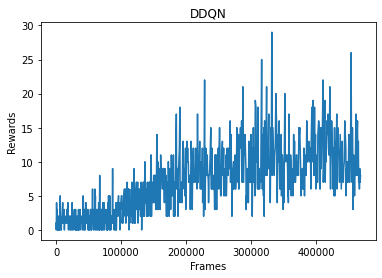

Episode:  961
Steps:  116430  epsilon:  0.03287440607844336
Steps:  116630  epsilon:  0.03284580526009044
Episode:  962
Steps:  116639  epsilon:  0.032844524935817965
Episode:  963
Steps:  116779  epsilon:  0.03282468278980034
Steps:  116979  epsilon:  0.032796576726435954
Episode:  964
Steps:  116995  epsilon:  0.032794340359720765
Episode:  965
Steps:  117156  epsilon:  0.03277193621748442
Steps:  117356  epsilon:  0.032744354991283746
Episode:  966
Steps:  117364  epsilon:  0.03274325746880637
Steps:  117564  epsilon:  0.0327159616009229
Episode:  967
Steps:  117614  epsilon:  0.0327091801772322
Steps:  117814  epsilon:  0.03268222338406528
Episode:  968
Steps:  117828  epsilon:  0.03268034648468786
Episode:  969
Steps:  117980  epsilon:  0.03266005306408144
Episode:  970
Steps:  118161  epsilon:  0.03263608818847865


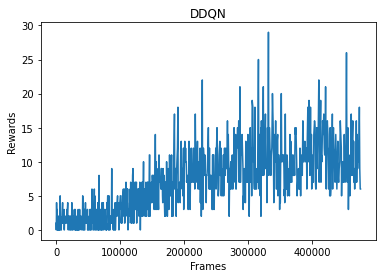

Episode:  971
Steps:  118280  epsilon:  0.03262045003340434
Episode:  972
Steps:  118465  epsilon:  0.032596322631860644
Steps:  118665  epsilon:  0.03257048879003283
Episode:  973
Steps:  118691  epsilon:  0.03256714932572789
Episode:  974
Steps:  118857  epsilon:  0.032545930167645905
Steps:  119057  epsilon:  0.03252059773921482
Steps:  119257  epsilon:  0.032495517372658156
Episode:  975
Steps:  119384  epsilon:  0.03247972104376494
Episode:  976
Steps:  119572  epsilon:  0.03245652087756499
Episode:  977
Steps:  119695  epsilon:  0.0324414596349601
Episode:  978
Steps:  119771  epsilon:  0.03243219969337905
Episode:  979
Steps:  119921  epsilon:  0.03241402643060121
Episode:  980
Steps:  120070  epsilon:  0.03239610875988952


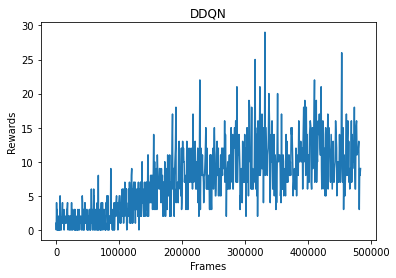

Episode:  981
Steps:  120264  epsilon:  0.032372978866260047
Steps:  120464  epsilon:  0.03234936733203105
Episode:  982
Steps:  120489  epsilon:  0.03234643245754471
Episode:  983
Steps:  120600  epsilon:  0.03233344582863559
Episode:  984
Steps:  120725  epsilon:  0.03231890727252048
Steps:  120925  epsilon:  0.03229583375963864
Episode:  985
Steps:  121013  epsilon:  0.03228575428220813
Episode:  986
Steps:  121142  epsilon:  0.0322710586115737
Episode:  987
Steps:  121334  epsilon:  0.03224936076520437
Episode:  988
Steps:  121452  epsilon:  0.032236128609931976
Steps:  121652  epsilon:  0.032213878758504906
Episode:  989
Steps:  121669  epsilon:  0.03221199776109733
Episode:  990
Steps:  121813  epsilon:  0.03219612857484277


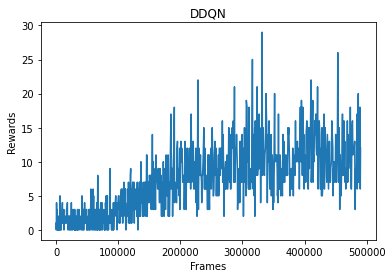

Episode:  991
Steps:  121915  epsilon:  0.03218495683127192
Steps:  122115  epsilon:  0.032163216147549877
Episode:  992
Steps:  122179  epsilon:  0.03215630491973979
Episode:  993
Steps:  122340  epsilon:  0.03213901634501097
Episode:  994
Steps:  122489  epsilon:  0.03212313988648053
Steps:  122689  epsilon:  0.032102014291636276
Episode:  995
Steps:  122724  epsilon:  0.032098338983458534
Episode:  996
Steps:  122894  epsilon:  0.03208057869027679
Steps:  123094  epsilon:  0.0320598765864106
Episode:  997
Steps:  123114  epsilon:  0.032057817739419264
Episode:  998
Steps:  123245  epsilon:  0.03204438307976809
Steps:  123445  epsilon:  0.032024041128244016
Episode:  999
Steps:  123617  epsilon:  0.03200670900947532
Episode:  1000
Steps:  123743  epsilon:  0.03199410648235887
Steps:  123943  epsilon:  0.03197426479133753


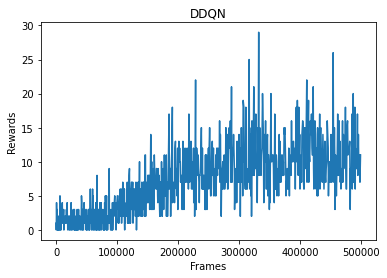

Episode:  1001
Steps:  123982  epsilon:  0.03197041872612673
Episode:  1002
Steps:  124160  epsilon:  0.03195295980689803
Steps:  124360  epsilon:  0.031933527532138205
Episode:  1003
Steps:  124373  epsilon:  0.03193227114761152
Steps:  124573  epsilon:  0.0319130447284511
Episode:  1004
Steps:  124574  epsilon:  0.031912949078605944
Episode:  1005
Steps:  124702  epsilon:  0.03190074529825553
Episode:  1006
Steps:  124883  epsilon:  0.031883621156921525
Episode:  1007
Steps:  125041  epsilon:  0.031868799173702146
Episode:  1008
Steps:  125194  epsilon:  0.03185455740424675
Episode:  1009
Steps:  125391  epsilon:  0.03183637968604745
Steps:  125591  epsilon:  0.03181810740287164
Episode:  1010
Steps:  125641  epsilon:  0.03181356781121839


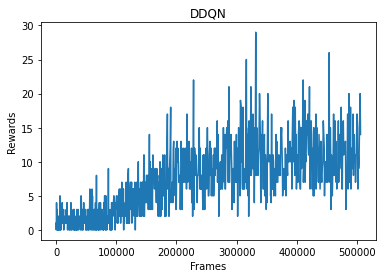

Episode:  1011
Steps:  125813  epsilon:  0.0317980380019371
Steps:  126013  epsilon:  0.03178014722489251
Episode:  1012
Steps:  126041  epsilon:  0.03177765676250811
Episode:  1013
Steps:  126207  epsilon:  0.031762963273710566
Steps:  126407  epsilon:  0.031745421496043036
Episode:  1014
Steps:  126420  epsilon:  0.031744287340711025
Steps:  126620  epsilon:  0.03172693139168173
Episode:  1015
Steps:  126644  epsilon:  0.03172486031690511
Episode:  1016
Steps:  126784  epsilon:  0.03171282845533233
Episode:  1017
Steps:  126928  epsilon:  0.03170054038060739
Steps:  127128  epsilon:  0.03168361972110409
Episode:  1018
Steps:  127162  epsilon:  0.031680759999030694
Steps:  127362  epsilon:  0.03166403615761259
Episode:  1019
Steps:  127389  epsilon:  0.03166179122447063
Steps:  127589  epsilon:  0.03164525612551298
Episode:  1020
Steps:  127594  epsilon:  0.03164484486289157


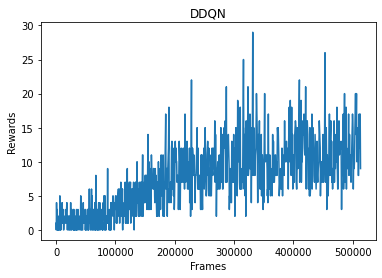

Episode:  1021
Steps:  127740  epsilon:  0.03163288121583274
Episode:  1022
Steps:  127929  epsilon:  0.031617523169404985
Episode:  1023
Steps:  128078  epsilon:  0.03160551739881749
Episode:  1024
Steps:  128205  epsilon:  0.0315953546641664
Episode:  1025
Steps:  128394  epsilon:  0.03158034957331017
Episode:  1026
Steps:  128573  epsilon:  0.03156626855119663
Episode:  1027
Steps:  128674  epsilon:  0.031558378833318024
Episode:  1028
Steps:  128788  epsilon:  0.03154952134180058
Steps:  128988  epsilon:  0.03153410334684045
Episode:  1029
Steps:  129004  epsilon:  0.03153287655494517
Episode:  1030
Steps:  129121  epsilon:  0.03152393540546


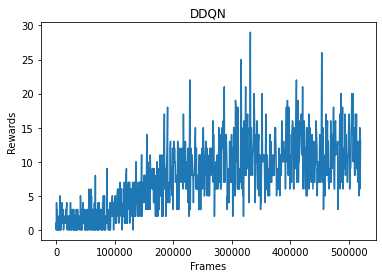

Episode:  1031
Steps:  129317  epsilon:  0.03150907377939657
Episode:  1032
Steps:  129452  epsilon:  0.03149892183275121
Episode:  1033
Steps:  129612  epsilon:  0.03148697829593526
Episode:  1034
Steps:  129787  epsilon:  0.031474023993569716
Episode:  1035
Steps:  129936  epsilon:  0.03146308331943164
Episode:  1036
Steps:  130130  epsilon:  0.031448960019973785
Episode:  1037
Steps:  130303  epsilon:  0.03143648056724595
Episode:  1038
Steps:  130466  epsilon:  0.0314248208285969
Episode:  1039
Steps:  130615  epsilon:  0.0314142453559731
Episode:  1040
Steps:  130736  epsilon:  0.03140571500190984


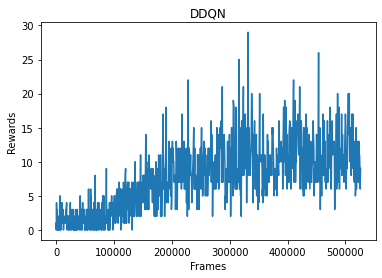

Episode:  1041
Steps:  130876  epsilon:  0.03139590935669441
Steps:  131076  epsilon:  0.031382019826524214
Episode:  1042
Steps:  131086  epsilon:  0.03138132898933464
Steps:  131286  epsilon:  0.031367584536243664
Episode:  1043
Steps:  131468  epsilon:  0.031355195970429614
Steps:  131668  epsilon:  0.031341711545221376
Episode:  1044
Steps:  131708  epsilon:  0.031339030803765974
Steps:  131908  epsilon:  0.03132570722465352
Episode:  1045
Steps:  131939  epsilon:  0.03132365397013863
Episode:  1046
Steps:  132085  epsilon:  0.031314026479252396
Episode:  1047
Steps:  132262  epsilon:  0.03130244865236193
Episode:  1048
Steps:  132411  epsilon:  0.0312927814648879
Episode:  1049
Steps:  132529  epsilon:  0.03128517651091995
Steps:  132729  epsilon:  0.03127238879097463
Episode:  1050
Steps:  132771  epsilon:  0.03126971957816797
Steps:  132971  epsilon:  0.03125708565727326


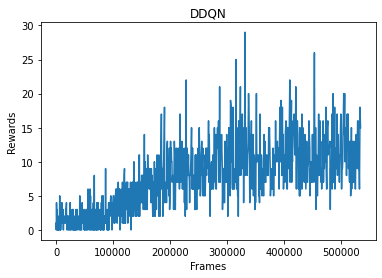

Episode:  1051
Steps:  132993  epsilon:  0.0312557036233083
Steps:  133193  epsilon:  0.031243209163494608
Episode:  1052
Steps:  133216  epsilon:  0.03124178029471361
Episode:  1053
Steps:  133415  epsilon:  0.031229485847089726
Episode:  1054
Steps:  133573  epsilon:  0.031219811174172052
Episode:  1055
Steps:  133755  epsilon:  0.031208761245914266
Episode:  1056
Steps:  133935  epsilon:  0.031197931202996857
Episode:  1057
Steps:  134072  epsilon:  0.031189753415156514
Episode:  1058
Steps:  134247  epsilon:  0.031179388485471592
Episode:  1059
Steps:  134434  epsilon:  0.031168412595380137
Episode:  1060
Steps:  134560  epsilon:  0.031161074734560784


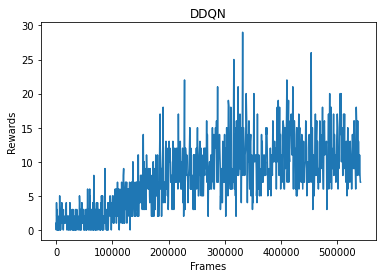

Episode:  1061
Steps:  134667  epsilon:  0.031154879571568633
Episode:  1062
Steps:  134834  epsilon:  0.031145276475866516
Episode:  1063
Steps:  134979  epsilon:  0.031137003248105546
Episode:  1064
Steps:  135093  epsilon:  0.031130540765164888
Episode:  1065
Steps:  135263  epsilon:  0.031120971893976047
Episode:  1066
Steps:  135446  epsilon:  0.03111076178363554
Episode:  1067
Steps:  135597  epsilon:  0.031102407110745647
Episode:  1068
Steps:  135768  epsilon:  0.031093021709712808
Episode:  1069
Steps:  135929  epsilon:  0.031084258205379262
Episode:  1070
Steps:  136123  epsilon:  0.031073791745184667


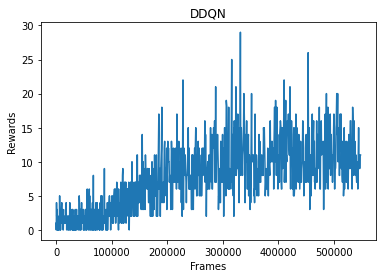

Episode:  1071
Steps:  136304  epsilon:  0.031064117770652308
Episode:  1072
Steps:  136470  epsilon:  0.031055322145494457
Episode:  1073
Steps:  136651  epsilon:  0.03104581456676261
Steps:  136851  epsilon:  0.03103540853795578
Episode:  1074
Steps:  136866  epsilon:  0.031034632272688177
Episode:  1075
Steps:  136966  epsilon:  0.031029472022700223
Episode:  1076
Steps:  137138  epsilon:  0.031020656524280994
Steps:  137338  epsilon:  0.0310105008221794
Episode:  1077
Steps:  137349  epsilon:  0.031009945199537436
Episode:  1078
Steps:  137491  epsilon:  0.031002799984151175
Steps:  137691  epsilon:  0.030992821957592537
Episode:  1079
Steps:  137767  epsilon:  0.03098905639325715
Steps:  137967  epsilon:  0.030979215117712795
Steps:  138167  epsilon:  0.030969471764496225
Episode:  1080
Steps:  138277  epsilon:  0.03096415430620621


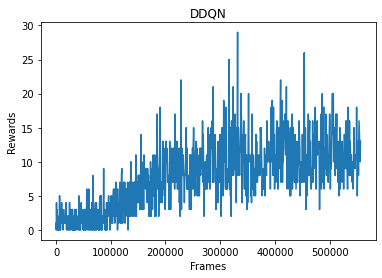

Episode:  1081
Steps:  138435  epsilon:  0.030956567494550922
Episode:  1082
Steps:  138571  epsilon:  0.030950084901384317
Steps:  138771  epsilon:  0.030940631398663137
Episode:  1083
Steps:  138778  epsilon:  0.030940302235280555
Episode:  1084
Steps:  138960  epsilon:  0.030931784300324325
Episode:  1085
Steps:  139127  epsilon:  0.030924036294358997
Episode:  1086
Steps:  139268  epsilon:  0.03091754474807158
Episode:  1087
Steps:  139444  epsilon:  0.030909505777636553
Steps:  139644  epsilon:  0.030900456043942977
Episode:  1088
Steps:  139652  epsilon:  0.03090009593355228
Episode:  1089
Steps:  139813  epsilon:  0.03089287924742043
Episode:  1090
Steps:  140000  epsilon:  0.030884569733968883
Steps:  140200  epsilon:  0.03087576811805544
Steps:  140400  epsilon:  0.030867054079683612


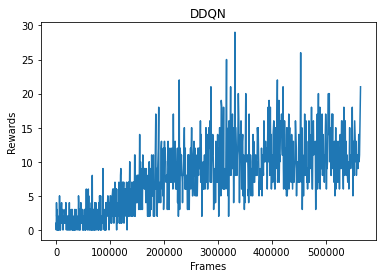

Episode:  1091
Steps:  140474  epsilon:  0.030863851907260906
Steps:  140674  epsilon:  0.030855256437167564
Episode:  1092
Steps:  140686  epsilon:  0.030854743437220635
Episode:  1093
Steps:  140858  epsilon:  0.030847424161656544
Episode:  1094
Steps:  140992  epsilon:  0.030841765397800838
Episode:  1095
Steps:  141191  epsilon:  0.030833431362674885
Steps:  141391  epsilon:  0.030825138582057612
Episode:  1096
Steps:  141424  epsilon:  0.030823778225999594
Episode:  1097
Steps:  141514  epsilon:  0.030820079552240066
Episode:  1098
Steps:  141654  epsilon:  0.03081435904052413
Episode:  1099
Steps:  141817  epsilon:  0.030807748986900356
Episode:  1100
Steps:  141968  epsilon:  0.030801673446075928
Steps:  142168  epsilon:  0.030793696662008596


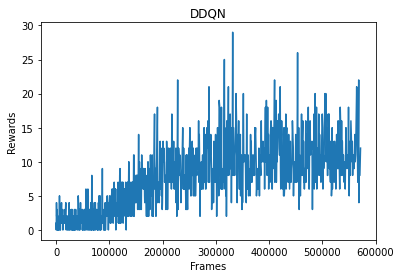

Episode:  1101
Steps:  142275  epsilon:  0.03078946172342876
Steps:  142475  epsilon:  0.030781606448031972
Episode:  1102
Steps:  142505  epsilon:  0.03078043491722769
Episode:  1103
Steps:  142639  epsilon:  0.03077522348108843
Episode:  1104
Steps:  142816  epsilon:  0.03076839302264092
Episode:  1105
Steps:  142991  epsilon:  0.03076169891313167
Steps:  143191  epsilon:  0.030754119882312934
Episode:  1106
Steps:  143199  epsilon:  0.030753818294681556
Episode:  1107
Steps:  143376  epsilon:  0.030747176436347275
Episode:  1108
Steps:  143510  epsilon:  0.030742187087207676
Steps:  143710  epsilon:  0.030734802202300737
Steps:  143910  epsilon:  0.03072749079822637
Steps:  144110  epsilon:  0.030720252143838066
Episode:  1109
Steps:  144158  epsilon:  0.030718525611360563
Episode:  1110
Steps:  144280  epsilon:  0.030714155946159723
Steps:  144480  epsilon:  0.030707049975766412


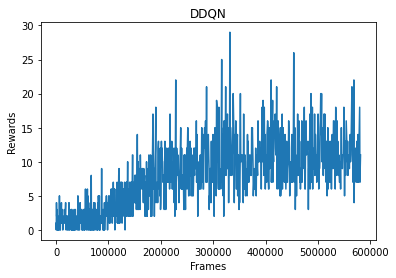

Episode:  1111
Steps:  144571  epsilon:  0.030703840206140094
Episode:  1112
Steps:  144653  epsilon:  0.030700960368995237
Episode:  1113
Steps:  144813  epsilon:  0.030695375057079238
Episode:  1114
Steps:  144989  epsilon:  0.030689282602692828
Steps:  145189  epsilon:  0.03068242412620223
Episode:  1115
Steps:  145243  epsilon:  0.03068058406626024
Episode:  1116
Steps:  145388  epsilon:  0.03067566767523213
Episode:  1117
Steps:  145536  epsilon:  0.03067068618866786
Steps:  145736  epsilon:  0.03066401274958848
Episode:  1118
Steps:  145760  epsilon:  0.030663216412186976
Episode:  1119
Steps:  145866  epsilon:  0.030659710663642398
Episode:  1120
Steps:  146025  epsilon:  0.03065448675641132
Steps:  146225  epsilon:  0.03064797450437606


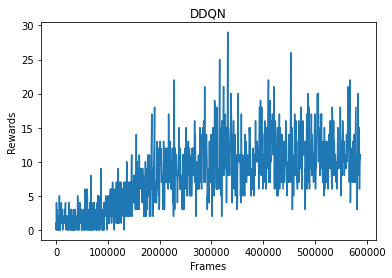

Episode:  1121
Steps:  146382  epsilon:  0.03064290781728202
Steps:  146582  epsilon:  0.030636510777616106
Episode:  1122
Steps:  146590  epsilon:  0.03063625622421913
Episode:  1123
Steps:  146747  epsilon:  0.03063128116551237
Episode:  1124
Steps:  146929  epsilon:  0.03062556256599705
Steps:  147129  epsilon:  0.030619338114465083
Episode:  1125
Steps:  147153  epsilon:  0.030618595354472852
Episode:  1126
Steps:  147341  epsilon:  0.03061280780225186
Episode:  1127
Steps:  147459  epsilon:  0.030609202881192968
Steps:  147659  epsilon:  0.03060314121124461
Episode:  1128
Steps:  147687  epsilon:  0.030602297404351515
Episode:  1129
Steps:  147831  epsilon:  0.030597976437188534
Episode:  1130
Steps:  148028  epsilon:  0.03059211528285589
Steps:  148228  epsilon:  0.030586223637351816


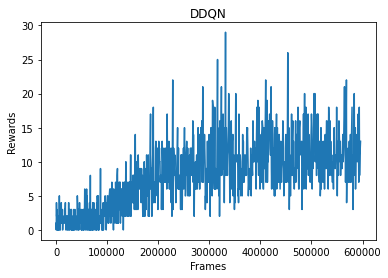

Episode:  1131
Steps:  148304  epsilon:  0.03058400021470842
Episode:  1132
Steps:  148472  epsilon:  0.030579115158863513
Steps:  148672  epsilon:  0.030573352866754444
Episode:  1133
Steps:  148781  epsilon:  0.03057023659318952
Episode:  1134
Steps:  148911  epsilon:  0.03056654207552397
Episode:  1135
Steps:  149092  epsilon:  0.03056143800051622
Episode:  1136
Steps:  149220  epsilon:  0.03055785627107276
Steps:  149420  epsilon:  0.030552305508431517
Episode:  1137
Steps:  149430  epsilon:  0.030552029424703985
Steps:  149630  epsilon:  0.03054653664015283
Episode:  1138
Steps:  149636  epsilon:  0.030546372703752475
Episode:  1139
Steps:  149803  epsilon:  0.030541829486007237
Episode:  1140
Steps:  149927  epsilon:  0.030538480535667843
Steps:  150127  epsilon:  0.03053312256481511


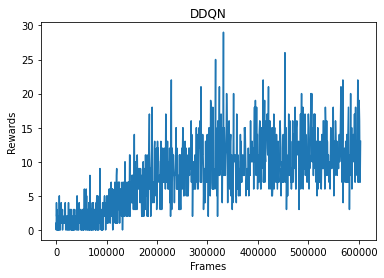

Episode:  1141
Steps:  150132  epsilon:  0.0305329893008326
Steps:  150332  epsilon:  0.0305276859686794
Episode:  1142
Steps:  150364  epsilon:  0.030526842346207464
Episode:  1143
Steps:  150529  epsilon:  0.030522513776751335
Episode:  1144
Steps:  150688  epsilon:  0.030518376260644443
Steps:  150888  epsilon:  0.030513218330670548
Episode:  1145
Steps:  150914  epsilon:  0.030512551580322303
Steps:  151114  epsilon:  0.03050745160688597
Episode:  1146
Steps:  151135  epsilon:  0.030506919062333555
Steps:  151335  epsilon:  0.03050187513338762
Steps:  151535  epsilon:  0.030496881392373255
Episode:  1147
Steps:  151553  epsilon:  0.030496434400296726
Episode:  1148
Steps:  151652  epsilon:  0.030493983121934406
Steps:  151852  epsilon:  0.030489067907746054
Episode:  1149
Steps:  151894  epsilon:  0.030488041942780042
Steps:  152094  epsilon:  0.030483185844312
Episode:  1150
Steps:  152100  epsilon:  0.030483040910299897


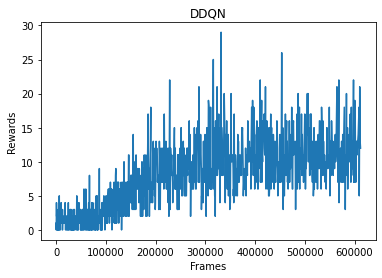

Episode:  1151
Steps:  152296  epsilon:  0.030478330229416376
Episode:  1152
Steps:  152461  epsilon:  0.030474400238526506
Episode:  1153
Steps:  152589  epsilon:  0.030471373772023077
Episode:  1154
Steps:  152770  epsilon:  0.030467127084631205
Steps:  152970  epsilon:  0.03046247909247886
Steps:  153170  epsilon:  0.030457877348621158
Episode:  1155
Steps:  153341  epsilon:  0.030453979185684096
Episode:  1156
Steps:  153512  epsilon:  0.030450114209962627
Episode:  1157
Steps:  153682  epsilon:  0.030446304453580448
Episode:  1158
Steps:  153871  epsilon:  0.030442106741920508
Episode:  1159
Steps:  154064  epsilon:  0.030437860930847726
Steps:  154264  epsilon:  0.030433504141791048
Episode:  1160
Steps:  154269  epsilon:  0.030433395779301476


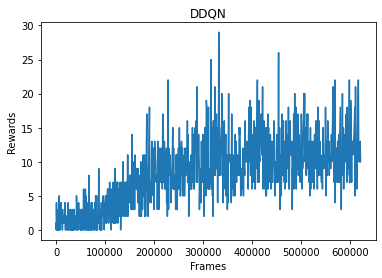

Episode:  1161
Steps:  154442  epsilon:  0.030429663073039275
Steps:  154642  epsilon:  0.03042538785403069
Episode:  1162
Steps:  154705  epsilon:  0.03042404999053175
Episode:  1163
Steps:  154894  epsilon:  0.030420061592980763
Steps:  155094  epsilon:  0.03041588191029502
Episode:  1164
Steps:  155132  epsilon:  0.030415092484857107
Episode:  1165
Steps:  155245  epsilon:  0.030412753825252367
Episode:  1166
Steps:  155401  epsilon:  0.030409546868804798
Episode:  1167
Steps:  155562  epsilon:  0.030406263250805567
Episode:  1168
Steps:  155689  epsilon:  0.030403691652628264
Episode:  1169
Steps:  155859  epsilon:  0.030400274815710008
Episode:  1170
Steps:  156036  epsilon:  0.030396748012713207
Steps:  156236  epsilon:  0.030392800304027023


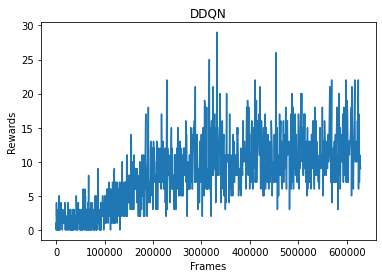

Episode:  1171
Steps:  156276  epsilon:  0.030392015488496106
Steps:  156476  epsilon:  0.030388114869212668
Episode:  1172
Steps:  156564  epsilon:  0.030386410915235928
Episode:  1173
Steps:  156755  epsilon:  0.03038273825585689
Episode:  1174
Steps:  156918  epsilon:  0.030379631615825665
Steps:  157118  epsilon:  0.03037585421813413
Episode:  1175
Steps:  157242  epsilon:  0.03037353113099345
Episode:  1176
Steps:  157382  epsilon:  0.030370925543272993
Episode:  1177
Steps:  157507  epsilon:  0.03036861448819761
Episode:  1178
Steps:  157647  epsilon:  0.03036604319679955
Episode:  1179
Steps:  157789  epsilon:  0.030363453494424604
Episode:  1180
Steps:  157931  epsilon:  0.030360882113817277


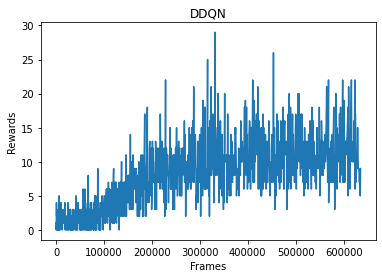

Episode:  1181
Steps:  158080  epsilon:  0.030358203532174943
Episode:  1182
Steps:  158240  epsilon:  0.030355349335924906
Episode:  1183
Steps:  158435  epsilon:  0.030351901515338158
Episode:  1184
Steps:  158587  epsilon:  0.030349237201040144
Episode:  1185
Steps:  158699  epsilon:  0.030347286938545985
Episode:  1186
Steps:  158863  epsilon:  0.03034445082958828
Steps:  159063  epsilon:  0.03034102348656864
Episode:  1187
Steps:  159082  epsilon:  0.03034069966809453
Episode:  1188
Steps:  159221  epsilon:  0.030338340014694924
Steps:  159421  epsilon:  0.0303349734752994
Episode:  1189
Steps:  159423  epsilon:  0.030334939979626684
Episode:  1190
Steps:  159588  epsilon:  0.030332188091939816


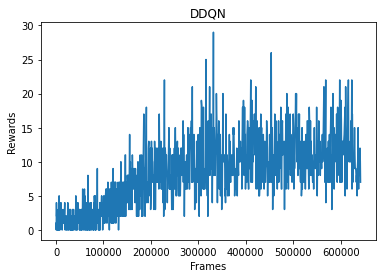

Episode:  1191
Steps:  159713  epsilon:  0.03033011839091819
Episode:  1192
Steps:  159853  epsilon:  0.030327815631243548
Steps:  160053  epsilon:  0.030324553811213056
Episode:  1193
Steps:  160060  epsilon:  0.030324440237255734
Episode:  1194
Steps:  160194  epsilon:  0.03032227375349118
Episode:  1195
Steps:  160386  epsilon:  0.03031919472842486
Episode:  1196
Steps:  160552  epsilon:  0.0303165563764858
Episode:  1197
Steps:  160728  epsilon:  0.030313782901560532
Episode:  1198
Steps:  160889  epsilon:  0.030311267088934685
Episode:  1199
Steps:  161084  epsilon:  0.0303082469817649
Episode:  1200
Steps:  161263  epsilon:  0.030305500480206023


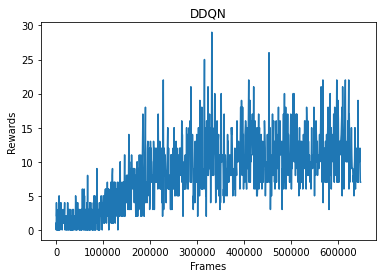

Episode:  1201
Steps:  161392  epsilon:  0.03030353634325976
Episode:  1202
Steps:  161574  epsilon:  0.03030078669242226
Episode:  1203
Steps:  161697  epsilon:  0.03029894253087319
Episode:  1204
Steps:  161856  epsilon:  0.030296575359725644
Episode:  1205
Steps:  161995  epsilon:  0.030294521307076487
Episode:  1206
Steps:  162188  epsilon:  0.03029169284573857
Episode:  1207
Steps:  162287  epsilon:  0.030290252533864987
Steps:  162487  epsilon:  0.030287364472898308
Episode:  1208
Steps:  162492  epsilon:  0.030287292640759474
Episode:  1209
Steps:  162636  epsilon:  0.030285231562531476
Episode:  1210
Steps:  162809  epsilon:  0.03028277494968362
Steps:  163009  epsilon:  0.030279961291922695


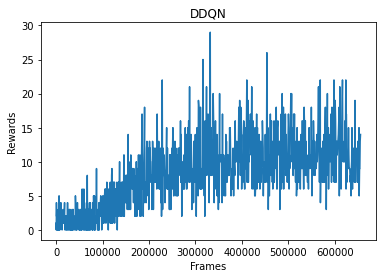

Episode:  1211
Steps:  163012  epsilon:  0.030279919300878314
Episode:  1212
Steps:  163202  epsilon:  0.03027727265897394
Episode:  1213
Steps:  163383  epsilon:  0.03027477466189633
Steps:  163583  epsilon:  0.030272040608328946
Episode:  1214
Steps:  163684  epsilon:  0.03027067026628281
Steps:  163884  epsilon:  0.03026797705213414
Episode:  1215
Steps:  163973  epsilon:  0.030266787203628565
Episode:  1216
Steps:  164103  epsilon:  0.0302650587104934
Episode:  1217
Steps:  164223  epsilon:  0.030263473119759413
Steps:  164423  epsilon:  0.03026085151841518
Episode:  1218
Steps:  164434  epsilon:  0.030260708089526613
Episode:  1219
Steps:  164539  epsilon:  0.030259342958660652
Steps:  164739  epsilon:  0.030256762453105997
Episode:  1220
Steps:  164743  epsilon:  0.030256711105750282


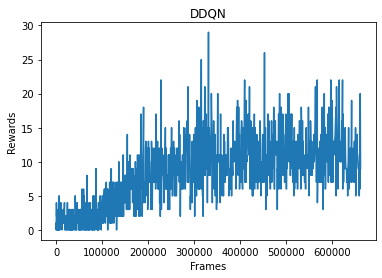

Episode:  1221
Steps:  164900  epsilon:  0.030254703812503995
Steps:  165100  epsilon:  0.03025216946722486
Episode:  1222
Steps:  165185  epsilon:  0.030251100021171755
Episode:  1223
Steps:  165364  epsilon:  0.030248862702916008
Episode:  1224
Steps:  165532  epsilon:  0.030246781011555555
Episode:  1225
Steps:  165681  epsilon:  0.03024494932452558
Episode:  1226
Steps:  165879  epsilon:  0.030242536290439926
Episode:  1227
Steps:  165987  epsilon:  0.030241230124294124
Episode:  1228
Steps:  166164  epsilon:  0.0302391046567606
Episode:  1229
Steps:  166329  epsilon:  0.03023714015804192
Episode:  1230
Steps:  166459  epsilon:  0.030235603745764


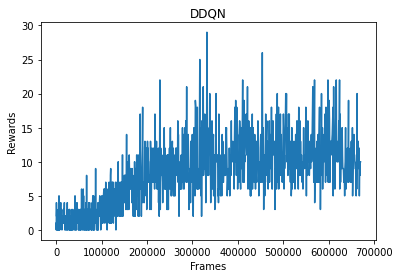

Episode:  1231
Steps:  166632  epsilon:  0.030233574562234272
Episode:  1232
Steps:  166809  epsilon:  0.030231516547506058
Episode:  1233
Steps:  166989  epsilon:  0.030229442246932595
Steps:  167189  epsilon:  0.030227159258430652
Episode:  1234
Steps:  167237  epsilon:  0.03022661472990602
Episode:  1235
Steps:  167370  epsilon:  0.030225112741598403
Steps:  167570  epsilon:  0.030222872832394318
Episode:  1236
Steps:  167639  epsilon:  0.03022210524597049
Episode:  1237
Steps:  167808  epsilon:  0.03022023636378948
Episode:  1238
Steps:  167983  epsilon:  0.030218317701993125
Steps:  168183  epsilon:  0.030216145404562793
Episode:  1239
Steps:  168190  epsilon:  0.03021606976690856
Episode:  1240
Steps:  168345  epsilon:  0.030214401698329785


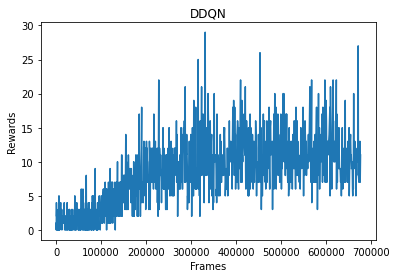

Episode:  1241
Steps:  168538  epsilon:  0.03021234267271792
Steps:  168738  epsilon:  0.030210229827822233
Episode:  1242
Steps:  168821  epsilon:  0.030209359181876665
Episode:  1243
Steps:  169005  epsilon:  0.03020744191037544
Episode:  1244
Steps:  169204  epsilon:  0.030205388098027985
Episode:  1245
Steps:  169349  epsilon:  0.030203904419152026
Episode:  1246
Steps:  169488  epsilon:  0.03020249219659678
Episode:  1247
Steps:  169669  epsilon:  0.030200667909567512
Episode:  1248
Steps:  169848  epsilon:  0.030198879944853995
Episode:  1249
Steps:  170043  epsilon:  0.0301969502877565
Episode:  1250
Steps:  170167  epsilon:  0.03019573297354592
Steps:  170367  epsilon:  0.03019378539791837


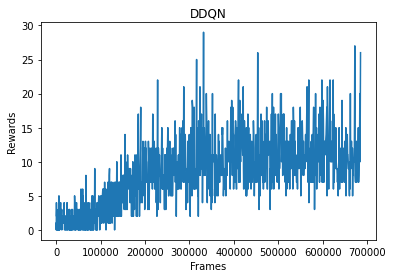

Episode:  1251
Steps:  170434  epsilon:  0.030193137303000436
Steps:  170634  epsilon:  0.03019121555472634
Steps:  170834  epsilon:  0.03018931292816707
Steps:  171034  epsilon:  0.030187429233058376
Episode:  1252
Steps:  171086  epsilon:  0.030186942550014546
Episode:  1253
Steps:  171256  epsilon:  0.030185360272545286
Episode:  1254
Steps:  171339  epsilon:  0.030184592621392104
Episode:  1255
Steps:  171486  epsilon:  0.03018324083950884
Episode:  1256
Steps:  171650  epsilon:  0.0301817444083775
Episode:  1257
Steps:  171819  epsilon:  0.030180215138391864
Steps:  172019  epsilon:  0.03017842196780395
Episode:  1258
Steps:  172028  epsilon:  0.03017834169598095
Steps:  172228  epsilon:  0.030176567166456485
Episode:  1259
Steps:  172238  epsilon:  0.030176478904940473
Episode:  1260
Steps:  172418  epsilon:  0.03017489772079763


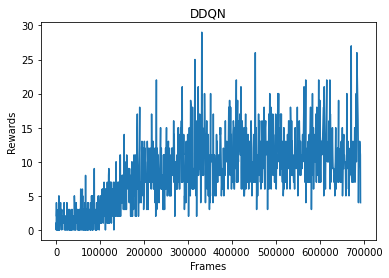

Episode:  1261
Steps:  172508  epsilon:  0.03017411244924019
Episode:  1262
Steps:  172689  epsilon:  0.030172543840236377
Episode:  1263
Steps:  172822  epsilon:  0.030171400230415896
Episode:  1264
Steps:  172966  epsilon:  0.030170170580807575
Episode:  1265
Steps:  173097  epsilon:  0.030169059605918012
Steps:  173297  epsilon:  0.03016737743473283
Episode:  1266
Steps:  173344  epsilon:  0.030166984559570325
Steps:  173544  epsilon:  0.03016532303544128
Steps:  173744  epsilon:  0.030163678043753545
Steps:  173944  epsilon:  0.03016204942000659
Episode:  1267
Steps:  174036  epsilon:  0.030161305704531568
Episode:  1268
Steps:  174219  epsilon:  0.030159836489245553
Episode:  1269
Steps:  174388  epsilon:  0.030158491561234867
Episode:  1270
Steps:  174571  epsilon:  0.030157047977914943


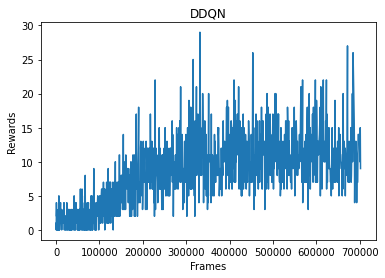

Episode:  1271
Steps:  174730  epsilon:  0.03015580439627731
Episode:  1272
Steps:  174884  epsilon:  0.030154609309415114
Steps:  175084  epsilon:  0.030153070921082506
Episode:  1273
Steps:  175107  epsilon:  0.03015289499070262
Episode:  1274
Steps:  175300  epsilon:  0.03015142665017997
Episode:  1275
Steps:  175468  epsilon:  0.03015015999372351
Steps:  175668  epsilon:  0.030148665876821735
Episode:  1276
Steps:  175677  epsilon:  0.030148598992227327
Steps:  175877  epsilon:  0.03014712040754996
Episode:  1277
Steps:  175890  epsilon:  0.030147024810357505
Episode:  1278
Steps:  176057  epsilon:  0.030145802264423534
Steps:  176257  epsilon:  0.03014435150765277
Episode:  1279
Steps:  176326  epsilon:  0.0301438543530362
Steps:  176526  epsilon:  0.030142422978307583
Episode:  1280
Steps:  176547  epsilon:  0.030142273512663555
Steps:  176747  epsilon:  0.030140857867559462


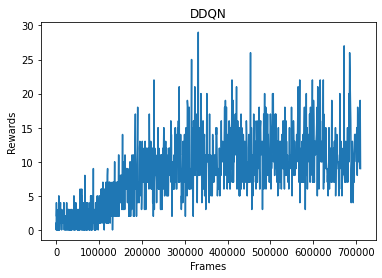

Episode:  1281
Steps:  176765  epsilon:  0.030140731152508985
Steps:  176965  epsilon:  0.030139330854144847
Episode:  1282
Steps:  177107  epsilon:  0.03013834510861799
Steps:  177307  epsilon:  0.03013696855178725
Steps:  177507  epsilon:  0.030135605691925832
Steps:  177707  epsilon:  0.03013425639274661
Episode:  1283
Steps:  177828  epsilon:  0.03013344659368272
Episode:  1284
Steps:  177951  epsilon:  0.030132628415607942
Steps:  178151  epsilon:  0.030131308740823058
Episode:  1285
Steps:  178153  epsilon:  0.0301312956106055
Episode:  1286
Steps:  178334  epsilon:  0.03013011274586575
Episode:  1287
Steps:  178500  epsilon:  0.03012903727943482
Steps:  178700  epsilon:  0.03012775333705189
Steps:  178900  epsilon:  0.030126482170109124
Episode:  1288
Steps:  179004  epsilon:  0.03012582616990328
Steps:  179204  epsilon:  0.030124574178594037
Episode:  1289
Steps:  179346  epsilon:  0.030123692834400282
Steps:  179546  epsilon:  0.030122462070133964
Episode:  1290
Steps:  179549

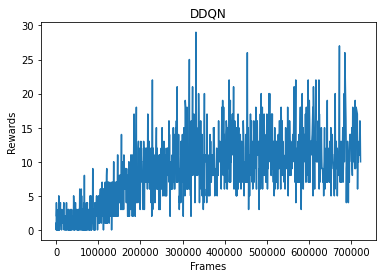

Episode:  1291
Steps:  179712  epsilon:  0.030121449841511664
Steps:  179912  epsilon:  0.030120241395397485
Episode:  1292
Steps:  179916  epsilon:  0.030120217349523075
Steps:  180116  epsilon:  0.030119021166909083
Episode:  1293
Steps:  180148  epsilon:  0.030118830885307906
Episode:  1294
Steps:  180287  epsilon:  0.030118007873932335
Episode:  1295
Steps:  180425  epsilon:  0.030117196422329663
Episode:  1296
Steps:  180537  epsilon:  0.030116541956579056
Episode:  1297
Steps:  180712  epsilon:  0.030115526662846843
Steps:  180912  epsilon:  0.030114377153345112
Episode:  1298
Steps:  180937  epsilon:  0.030114234271223363
Episode:  1299
Steps:  181077  epsilon:  0.030113437423545462
Episode:  1300
Steps:  181153  epsilon:  0.03011300717931775
Steps:  181353  epsilon:  0.030111882739096003


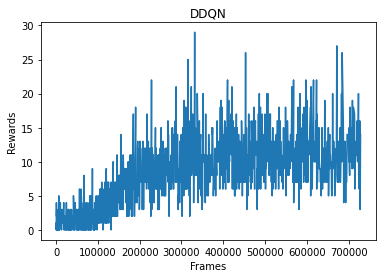

Episode:  1301
Steps:  181383  epsilon:  0.030111715040792526
Episode:  1302
Steps:  181513  epsilon:  0.030110991247902622
Episode:  1303
Steps:  181623  epsilon:  0.030110382471708313
Episode:  1304
Steps:  181809  epsilon:  0.030109360673447938
Episode:  1305
Steps:  181978  epsilon:  0.03010844046909609
Episode:  1306
Steps:  182136  epsilon:  0.030107587164381742
Episode:  1307
Steps:  182308  epsilon:  0.030106665881960634
Steps:  182508  epsilon:  0.030105604538701834
Episode:  1308
Steps:  182514  epsilon:  0.030105572862091954
Steps:  182714  epsilon:  0.03010452239456256
Episode:  1309
Steps:  182737  epsilon:  0.03010440226289776
Episode:  1310
Steps:  182895  epsilon:  0.030103580734331337


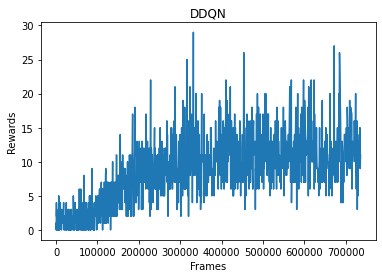

Episode:  1311
Steps:  183088  epsilon:  0.030102585987617364
Episode:  1312
Steps:  183225  epsilon:  0.03010188567491157
Episode:  1313
Steps:  183392  epsilon:  0.030101038471522627
Steps:  183592  epsilon:  0.030100033121933246
Episode:  1314
Steps:  183636  epsilon:  0.03009981329096772
Episode:  1315
Steps:  183823  epsilon:  0.03009888438609471
Episode:  1316
Steps:  184000  epsilon:  0.03009801312031548
Steps:  184200  epsilon:  0.03009703787347358
Episode:  1317
Steps:  184232  epsilon:  0.03009688273701828
Steps:  184432  epsilon:  0.030095918737678112
Episode:  1318
Steps:  184541  epsilon:  0.030095397402486578
Steps:  184741  epsilon:  0.03009444818247194
Episode:  1319
Steps:  184848  epsilon:  0.030093944233960005
Episode:  1320
Steps:  185009  epsilon:  0.03009319101863582
Steps:  185209  epsilon:  0.03009226375250731


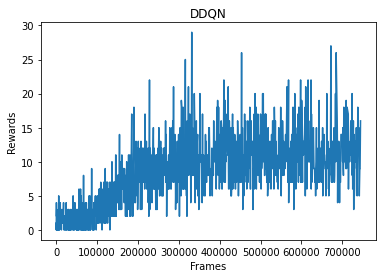

Episode:  1321
Steps:  185297  epsilon:  0.030091858683800942
Steps:  185497  epsilon:  0.03009094467462554
Episode:  1322
Steps:  185520  epsilon:  0.030090840148363843
Episode:  1323
Steps:  185688  epsilon:  0.03009008028700328
Episode:  1324
Steps:  185840  epsilon:  0.030089398271762734
Steps:  186040  epsilon:  0.030088508744096156
Episode:  1325
Steps:  186099  epsilon:  0.03008824802804632
Episode:  1326
Steps:  186286  epsilon:  0.030087426754421425
Episode:  1327
Steps:  186469  epsilon:  0.03008663044827481
Episode:  1328
Steps:  186646  epsilon:  0.03008586715137828
Episode:  1329
Steps:  186800  epsilon:  0.030085208513323396
Episode:  1330
Steps:  186925  epsilon:  0.03008467762088217


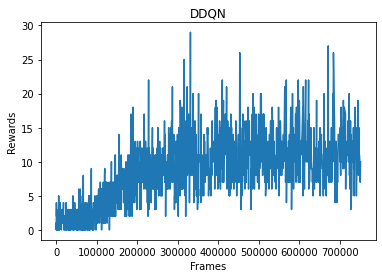

Episode:  1331
Steps:  187097  epsilon:  0.03008395251576365
Episode:  1332
Steps:  187226  epsilon:  0.03008341276460571
Episode:  1333
Steps:  187399  epsilon:  0.030082694355789422
Steps:  187599  epsilon:  0.030081871533201313
Episode:  1334
Steps:  187659  epsilon:  0.030081626286655463
Episode:  1335
Steps:  187792  epsilon:  0.030081085272714306
Steps:  187992  epsilon:  0.030080278460770302
Episode:  1336
Steps:  187993  epsilon:  0.03008027444694761
Episode:  1337
Steps:  188134  epsilon:  0.030079710502337167
Steps:  188334  epsilon:  0.030078917369586976
Episode:  1338
Steps:  188382  epsilon:  0.030078728195000275
Episode:  1339
Steps:  188540  epsilon:  0.03007810869251651
Steps:  188740  epsilon:  0.030077331498040337
Episode:  1340
Steps:  188812  epsilon:  0.03007705360515471


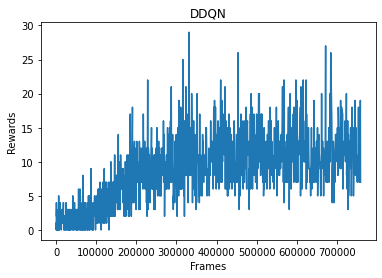

Episode:  1341
Steps:  188927  epsilon:  0.03007661181827955
Episode:  1342
Steps:  189116  epsilon:  0.030075891246660106
Episode:  1343
Steps:  189306  epsilon:  0.030075173693590505
Episode:  1344
Steps:  189397  epsilon:  0.030074832430247524
Episode:  1345
Steps:  189508  epsilon:  0.030074418260643422
Steps:  189708  epsilon:  0.03007367778657792
Episode:  1346
Steps:  189768  epsilon:  0.030073457084436928
Steps:  189968  epsilon:  0.03007272617423448
Steps:  190168  epsilon:  0.03007200253671006
Episode:  1347
Steps:  190214  epsilon:  0.03007183712117641
Episode:  1348
Steps:  190383  epsilon:  0.03007123265496889
Episode:  1349
Steps:  190553  epsilon:  0.030070629743405825
Steps:  190753  epsilon:  0.03006992696571668
Episode:  1350
Steps:  190783  epsilon:  0.030069822153896624


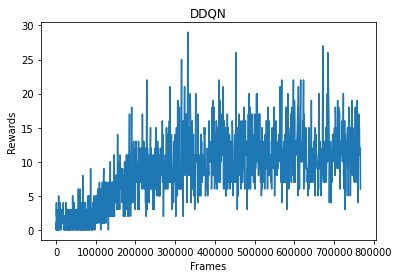

Episode:  1351
Steps:  190917  epsilon:  0.030069355909129628
Episode:  1352
Steps:  191091  epsilon:  0.030068755129899264
Steps:  191291  epsilon:  0.03006807100492617
Episode:  1353
Steps:  191422  epsilon:  0.030067626596869138
Episode:  1354
Steps:  191569  epsilon:  0.030067131363593912
Steps:  191769  epsilon:  0.03006646339536551
Episode:  1355
Steps:  191772  epsilon:  0.03006645342660388
Steps:  191972  epsilon:  0.030065792203961234
Episode:  1356
Steps:  192111  epsilon:  0.030065336533432956
Steps:  192311  epsilon:  0.030064686424063045
Episode:  1357
Steps:  192315  epsilon:  0.030064673488071875
Episode:  1358
Steps:  192427  epsilon:  0.03006431232872866
Episode:  1359
Steps:  192626  epsilon:  0.030063675594065944
Episode:  1360
Steps:  192785  epsilon:  0.030063171379999663


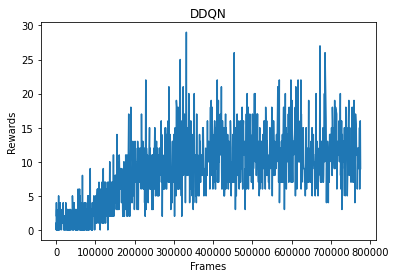

Episode:  1361
Steps:  192954  epsilon:  0.03006263983079687
Episode:  1362
Steps:  193113  epsilon:  0.030062143818403733
Steps:  193313  epsilon:  0.030061525477079153
Episode:  1363
Steps:  193319  epsilon:  0.0300615070222044
Episode:  1364
Steps:  193486  epsilon:  0.030060995576825053
Episode:  1365
Steps:  193675  epsilon:  0.03006042188359392
Episode:  1366
Steps:  193764  epsilon:  0.03006015360357768
Episode:  1367
Steps:  193963  epsilon:  0.030059558043049203
Episode:  1368
Steps:  194126  epsilon:  0.03005907461763278
Episode:  1369
Steps:  194303  epsilon:  0.03005855411389304
Steps:  194503  epsilon:  0.03005797149072513
Episode:  1370
Steps:  194581  epsilon:  0.030057745842211915


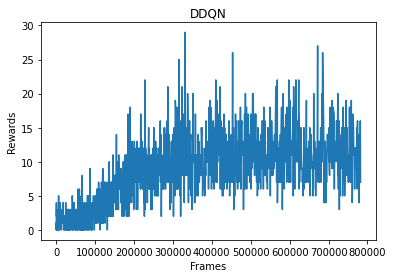

Episode:  1371
Steps:  194712  epsilon:  0.030057368842965806
Episode:  1372
Steps:  194847  epsilon:  0.030056982907274096
Steps:  195047  epsilon:  0.030056415917873263
Episode:  1373
Steps:  195087  epsilon:  0.030056303198794168
Steps:  195287  epsilon:  0.03005574297260571
Episode:  1374
Steps:  195335  epsilon:  0.030055609349882866
Episode:  1375
Steps:  195474  epsilon:  0.030055224204830523
Episode:  1376
Steps:  195638  epsilon:  0.030054773217924255
Episode:  1377
Steps:  195806  epsilon:  0.030054315049893445
Steps:  196006  epsilon:  0.030053774606117085
Episode:  1378
Steps:  196192  epsilon:  0.03005327682057077
Steps:  196392  epsilon:  0.030052746707348775
Episode:  1379
Steps:  196442  epsilon:  0.03005261500527659
Steps:  196642  epsilon:  0.0300520914772268
Episode:  1380
Steps:  196649  epsilon:  0.0300520732484


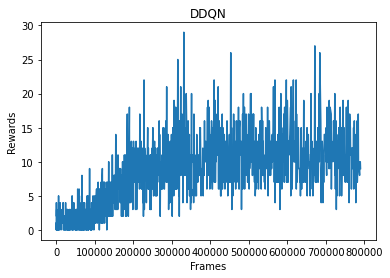

Episode:  1381
Steps:  196801  epsilon:  0.030051678991784982
Episode:  1382
Steps:  196988  epsilon:  0.030051198045141145
Episode:  1383
Steps:  197144  epsilon:  0.030050800253792104
Episode:  1384
Steps:  197249  epsilon:  0.03005053425132714
Episode:  1385
Steps:  197380  epsilon:  0.030050204333640893
Steps:  197580  epsilon:  0.030049704792174656
Steps:  197780  epsilon:  0.030049210221229056
Steps:  197980  epsilon:  0.030048720571346586
Episode:  1386
Steps:  197993  epsilon:  0.0300486889132652
Steps:  198193  epsilon:  0.03004820445048364
Episode:  1387
Steps:  198248  epsilon:  0.030048072070350918
Episode:  1388
Steps:  198371  epsilon:  0.0300477773343604
Episode:  1389
Steps:  198514  epsilon:  0.030047436944762668
Episode:  1390
Steps:  198666  epsilon:  0.030047077790497406


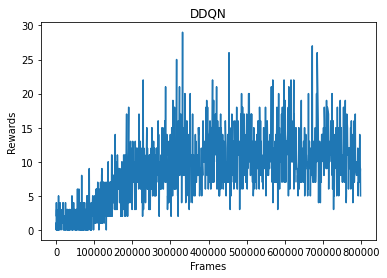

Episode:  1391
Steps:  198770  epsilon:  0.030046833621376726
Episode:  1392
Steps:  198963  epsilon:  0.03004638385056492
Episode:  1393
Steps:  199128  epsilon:  0.030046002757966234
Episode:  1394
Steps:  199279  epsilon:  0.030045656744986222
Steps:  199479  epsilon:  0.030045202452783137
Steps:  199679  epsilon:  0.030044752680863
Steps:  199879  epsilon:  0.030044307384248244
Episode:  1395
Steps:  199948  epsilon:  0.030044154787153932
Episode:  1396
Steps:  200103  epsilon:  0.030043813910158007
Steps:  200303  epsilon:  0.030043377954467834
Episode:  1397
Steps:  200426  epsilon:  0.030043111998700103
Episode:  1398
Steps:  200530  epsilon:  0.03004288839817208
Episode:  1399
Steps:  200679  epsilon:  0.030042570066862177
Steps:  200879  epsilon:  0.030042146487619586
Episode:  1400
Steps:  200900  epsilon:  0.03004210225703271
Steps:  201100  epsilon:  0.0300416833325757


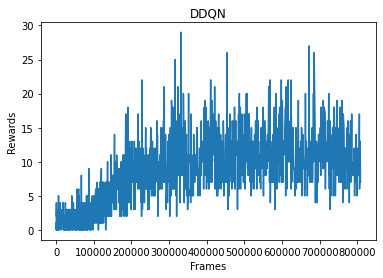

Episode:  1401
Steps:  201183  epsilon:  0.03004151070519508
Episode:  1402
Steps:  201355  epsilon:  0.0300411552438052
Episode:  1403
Steps:  201515  epsilon:  0.03004082731531766
Steps:  201715  epsilon:  0.030040421076742676
Episode:  1404
Steps:  201778  epsilon:  0.030040293950679604
Episode:  1405
Steps:  201919  epsilon:  0.03004001087733331
Steps:  202119  epsilon:  0.030039612762452
Episode:  1406
Steps:  202245  epsilon:  0.03003936398651558
Episode:  1407
Steps:  202352  epsilon:  0.03003915395153228
Episode:  1408
Steps:  202446  epsilon:  0.030038970359738754
Episode:  1409
Steps:  202632  epsilon:  0.030038609615454168
Steps:  202832  epsilon:  0.03003822544336152
Episode:  1410
Steps:  202844  epsilon:  0.030038202514974705


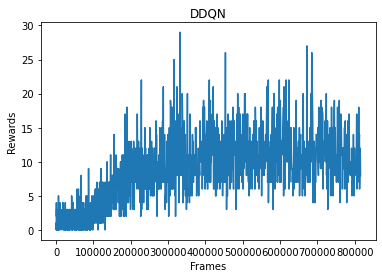

Episode:  1411
Steps:  202988  epsilon:  0.030037928444703845
Episode:  1412
Steps:  203153  epsilon:  0.03003761682224516
Episode:  1413
Steps:  203320  epsilon:  0.03003730402950649
Episode:  1414
Steps:  203447  epsilon:  0.030037067899425573
Steps:  203647  epsilon:  0.030036699067663722
Steps:  203847  epsilon:  0.030036333905839215
Steps:  204047  epsilon:  0.030035972377435573
Steps:  204247  epsilon:  0.030035614446299652
Episode:  1415
Steps:  204266  epsilon:  0.0300355806286416
Episode:  1416
Steps:  204413  epsilon:  0.03003532006974802
Episode:  1417
Steps:  204547  epsilon:  0.03003508421627214
Steps:  204747  epsilon:  0.03003473512248745
Episode:  1418
Steps:  204768  epsilon:  0.030034698669749876
Episode:  1419
Steps:  204899  epsilon:  0.03003447213617039
Steps:  205099  epsilon:  0.030034129132684474
Episode:  1420
Steps:  205148  epsilon:  0.030034045618655858


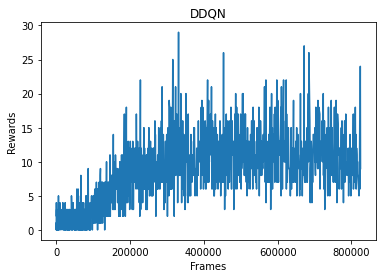

Episode:  1421
Steps:  205297  epsilon:  0.030033792921263434
Episode:  1422
Steps:  205400  epsilon:  0.030033619335086994
Episode:  1423
Steps:  205521  epsilon:  0.03003341655214664
Episode:  1424
Steps:  205620  epsilon:  0.030033251548933385
Steps:  205820  epsilon:  0.0300329206904934
Episode:  1425
Steps:  205860  epsilon:  0.03003285491490992
Episode:  1426
Steps:  206028  epsilon:  0.030032580089507342
Episode:  1427
Steps:  206216  epsilon:  0.03003227527155482
Episode:  1428
Steps:  206385  epsilon:  0.03003200369453901
Episode:  1429
Steps:  206552  epsilon:  0.030031737576279544
Episode:  1430
Steps:  206688  epsilon:  0.030031522492873212


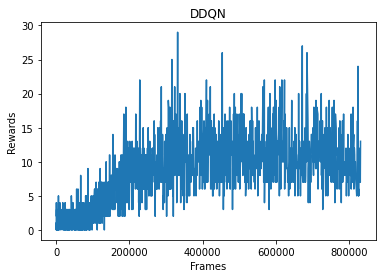

Episode:  1431
Steps:  206852  epsilon:  0.030031265065327044
Steps:  207052  epsilon:  0.030030953972729195
Episode:  1432
Steps:  207056  epsilon:  0.030030947782553687
Steps:  207256  epsilon:  0.030030639846972185
Steps:  207456  epsilon:  0.03003033497540091
Episode:  1433
Steps:  207530  epsilon:  0.030030222943378978
Episode:  1434
Steps:  207693  epsilon:  0.030029977627410883
Episode:  1435
Steps:  207883  epsilon:  0.030029694188417392
Episode:  1436
Steps:  208048  epsilon:  0.03002945021912006
Episode:  1437
Steps:  208221  epsilon:  0.030029196573324275
Episode:  1438
Steps:  208349  epsilon:  0.03002901031192724
Steps:  208549  epsilon:  0.030028721654500577
Episode:  1439
Steps:  208607  epsilon:  0.03002863848236042
Episode:  1440
Steps:  208723  epsilon:  0.030028472859932064


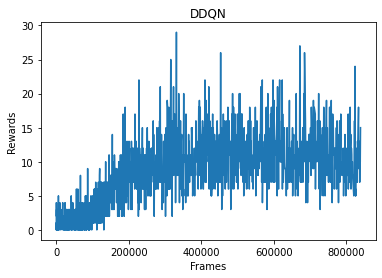

Episode:  1441
Steps:  208906  epsilon:  0.03002821352154617
Steps:  209106  epsilon:  0.030027932792316265
Episode:  1442
Steps:  209193  epsilon:  0.03002781154856603
Steps:  209393  epsilon:  0.030027534819034106
Episode:  1443
Steps:  209425  epsilon:  0.030027490798549432
Episode:  1444
Steps:  209552  epsilon:  0.030027316785056202
Steps:  209752  epsilon:  0.030027044978503455
Episode:  1445
Steps:  209790  epsilon:  0.030026993641829584
Episode:  1446
Steps:  209940  epsilon:  0.0300267919468176
Episode:  1447
Steps:  210101  epsilon:  0.030026577137413586
Episode:  1448
Steps:  210291  epsilon:  0.030026325850112723
Episode:  1449
Steps:  210465  epsilon:  0.030026097808635535
Episode:  1450
Steps:  210663  epsilon:  0.030025840715043137


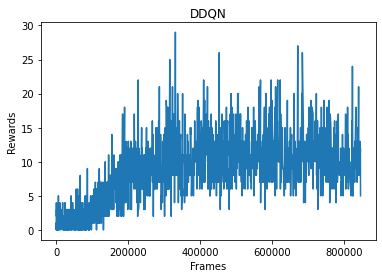

Episode:  1451
Steps:  210759  epsilon:  0.03002571697682024
Episode:  1452
Steps:  210938  epsilon:  0.030025487836808806
Episode:  1453
Steps:  211042  epsilon:  0.03002535564405643
Episode:  1454
Steps:  211203  epsilon:  0.030025152350476262
Episode:  1455
Steps:  211389  epsilon:  0.030024919517966143
Steps:  211589  epsilon:  0.03002467156461949
Episode:  1456
Steps:  211621  epsilon:  0.030024632121678867
Episode:  1457
Steps:  211747  epsilon:  0.030024477427111826
Episode:  1458
Steps:  211904  epsilon:  0.030024286031519555
Episode:  1459
Steps:  212072  epsilon:  0.03002408288327194
Episode:  1460
Steps:  212183  epsilon:  0.03002394959349106


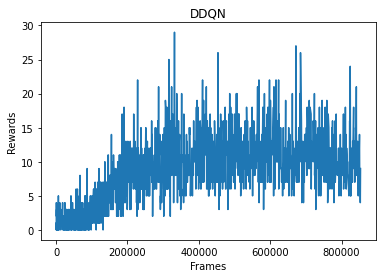

Episode:  1461
Steps:  212344  epsilon:  0.03002375757318215
Episode:  1462
Steps:  212488  epsilon:  0.03002358713297628
Episode:  1463
Steps:  212597  epsilon:  0.03002345893276446
Steps:  212797  epsilon:  0.030023225512483386
Episode:  1464
Steps:  212818  epsilon:  0.03002320113849386
Episode:  1465
Steps:  213000  epsilon:  0.030022990965869373
Episode:  1466
Steps:  213139  epsilon:  0.030022831732633024
Steps:  213339  epsilon:  0.03002260455309753
Episode:  1467
Steps:  213344  epsilon:  0.03002259890266559
Episode:  1468
Steps:  213540  epsilon:  0.030022378515082458
Steps:  213740  epsilon:  0.03002215584513694
Episode:  1469
Steps:  213810  epsilon:  0.03002207843522533
Episode:  1470
Steps:  213958  epsilon:  0.030021915657823854


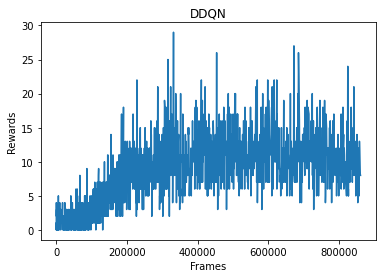

Episode:  1471
Steps:  214118  epsilon:  0.03002174103199591
Episode:  1472
Steps:  214244  epsilon:  0.030021604494040496
Episode:  1473
Steps:  214416  epsilon:  0.030021419492040576
Steps:  214616  epsilon:  0.030021206364533762
Episode:  1474
Steps:  214636  epsilon:  0.030021185168768876
Episode:  1475
Steps:  214766  epsilon:  0.03002104791174048
Episode:  1476
Steps:  214858  epsilon:  0.03002095131369232
Steps:  215058  epsilon:  0.030020742844637908
Episode:  1477
Steps:  215072  epsilon:  0.03002072832972747
Episode:  1478
Steps:  215199  epsilon:  0.03002059712185957
Episode:  1479
Steps:  215396  epsilon:  0.03002039523612876
Episode:  1480
Steps:  215551  epsilon:  0.030020237783963982


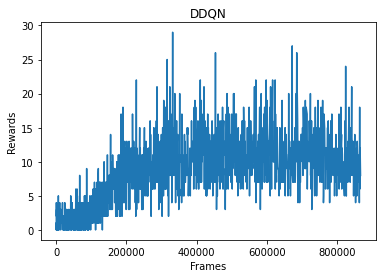

Episode:  1481
Steps:  215689  epsilon:  0.030020098623908937
Episode:  1482
Steps:  215855  epsilon:  0.030019932495716207
Episode:  1483
Steps:  215980  epsilon:  0.030019808306114747
Episode:  1484
Steps:  216136  epsilon:  0.030019654402332098
Steps:  216336  epsilon:  0.03001945883776133
Episode:  1485
Steps:  216364  epsilon:  0.03001943161444923
Episode:  1486
Steps:  216555  epsilon:  0.0300192469258231
Steps:  216755  epsilon:  0.030019055415711343
Episode:  1487
Steps:  216793  epsilon:  0.030019019244794744
Episode:  1488
Steps:  216905  epsilon:  0.03001891303468975
Episode:  1489
Steps:  217099  epsilon:  0.030018730465147036
Episode:  1490
Steps:  217254  epsilon:  0.030018585865091117


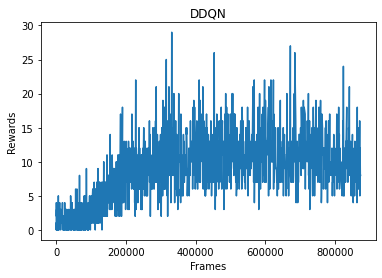

Episode:  1491
Steps:  217395  epsilon:  0.030018455295540692
Steps:  217595  epsilon:  0.030018271662281854
Episode:  1492
Steps:  217744  epsilon:  0.03001813604420246
Episode:  1493
Steps:  217917  epsilon:  0.030017979843960096
Episode:  1494
Steps:  217993  epsilon:  0.030017911650203247
Episode:  1495
Steps:  218166  epsilon:  0.030017757382598268
Episode:  1496
Steps:  218350  epsilon:  0.03001759476387151
Episode:  1497
Steps:  218498  epsilon:  0.03001746504317739
Episode:  1498
Steps:  218680  epsilon:  0.03001730683223604
Steps:  218880  epsilon:  0.03001713462637802
Episode:  1499
Steps:  219008  epsilon:  0.03001702531493892
Episode:  1500
Steps:  219161  epsilon:  0.030016895568193695


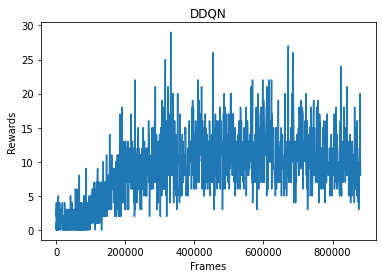

Episode:  1501
Steps:  219319  epsilon:  0.030016762619045546
Steps:  219519  epsilon:  0.030016595828199245
Episode:  1502
Steps:  219532  epsilon:  0.030016585044416025
Episode:  1503
Steps:  219695  epsilon:  0.030016450425620768
Episode:  1504
Steps:  219880  epsilon:  0.0300162989607886
Episode:  1505
Steps:  220080  epsilon:  0.030016136783419037
Episode:  1506
Steps:  220244  epsilon:  0.030016005002833808
Episode:  1507
Steps:  220388  epsilon:  0.03001589018066923
Episode:  1508
Steps:  220555  epsilon:  0.030015758050073584
Episode:  1509
Steps:  220740  epsilon:  0.030015612960185654
Episode:  1510
Steps:  220904  epsilon:  0.030015485457388042


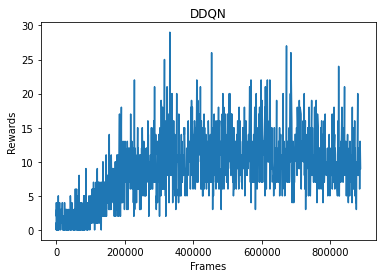

Episode:  1511
Steps:  221038  epsilon:  0.030015382051619688
Episode:  1512
Steps:  221154  epsilon:  0.030015293093946925
Episode:  1513
Steps:  221276  epsilon:  0.030015200090024202
Steps:  221476  epsilon:  0.030015048846601434
Episode:  1514
Steps:  221487  epsilon:  0.03001504057201152
Steps:  221687  epsilon:  0.0300148909158195
Episode:  1515
Steps:  221772  epsilon:  0.030014827763720536
Episode:  1516
Steps:  221861  epsilon:  0.030014761926767844
Episode:  1517
Steps:  222038  epsilon:  0.030014631860109837
Episode:  1518
Steps:  222231  epsilon:  0.030014491341751305
Steps:  222431  epsilon:  0.030014347150491685
Episode:  1519
Steps:  222610  epsilon:  0.030014219316405636
Episode:  1520
Steps:  222696  epsilon:  0.03001415830461445


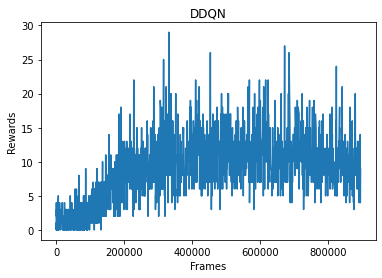

Episode:  1521
Steps:  222858  epsilon:  0.03001404408555874
Steps:  223058  epsilon:  0.030013904344572594
Episode:  1522
Steps:  223076  epsilon:  0.030013891836292047
Episode:  1523
Steps:  223224  epsilon:  0.03001378941612548
Episode:  1524
Steps:  223361  epsilon:  0.030013695281404525
Episode:  1525
Steps:  223559  epsilon:  0.030013560367046603
Episode:  1526
Steps:  223722  epsilon:  0.030013450299190933
Episode:  1527
Steps:  223859  epsilon:  0.03001335847948301
Episode:  1528
Steps:  223978  epsilon:  0.030013279232523584
Steps:  224178  epsilon:  0.03001314710195229
Episode:  1529
Steps:  224282  epsilon:  0.03001307891446326
Episode:  1530
Steps:  224467  epsilon:  0.030012958492315542


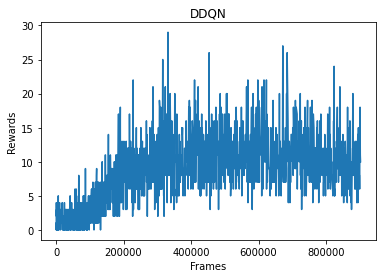

Episode:  1531
Steps:  224641  epsilon:  0.030012846242427425
Episode:  1532
Steps:  224758  epsilon:  0.030012771311296475
Steps:  224958  epsilon:  0.030012644234625834
Episode:  1533
Steps:  225014  epsilon:  0.030012608880288054
Episode:  1534
Steps:  225202  epsilon:  0.030012490912132317
Steps:  225402  epsilon:  0.030012366625479975
Episode:  1535
Steps:  225420  epsilon:  0.030012355500524023
Episode:  1536
Steps:  225545  epsilon:  0.030012278519462157
Steps:  225745  epsilon:  0.030012156346152195
Episode:  1537
Steps:  225749  epsilon:  0.030012153915126075
Steps:  225949  epsilon:  0.03001203298164997
Episode:  1538
Steps:  226007  epsilon:  0.030011998136552996
Episode:  1539
Steps:  226162  epsilon:  0.030011905510384726
Episode:  1540
Steps:  226299  epsilon:  0.03001182423632006
Steps:  226499  epsilon:  0.030011706583202888


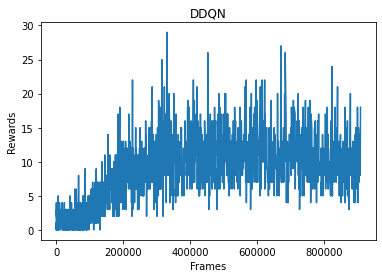

Episode:  1541
Steps:  226553  epsilon:  0.030011675018060357
Episode:  1542
Steps:  226732  epsilon:  0.030011570992855896
Episode:  1543
Steps:  226880  epsilon:  0.030011485683542515
Episode:  1544
Steps:  227045  epsilon:  0.030011391316452776
Episode:  1545
Steps:  227212  epsilon:  0.03001129659497292
Steps:  227412  epsilon:  0.030011184191974873
Episode:  1546
Steps:  227471  epsilon:  0.030011151247225944
Episode:  1547
Steps:  227621  epsilon:  0.030011067925717973
Episode:  1548
Steps:  227749  epsilon:  0.030010997317181706
Episode:  1549
Steps:  227930  epsilon:  0.030010898240459598
Episode:  1550
Steps:  228040  epsilon:  0.03001083846467117


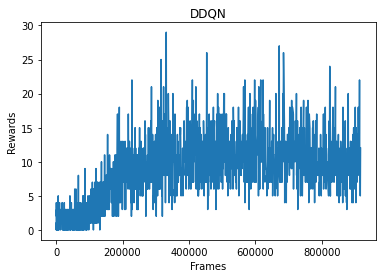

Episode:  1551
Steps:  228232  epsilon:  0.030010734913252412
Episode:  1552
Steps:  228399  epsilon:  0.030010645649919804
Episode:  1553
Steps:  228526  epsilon:  0.030010578264218844
Episode:  1554
Steps:  228689  epsilon:  0.030010492401730367
Steps:  228889  epsilon:  0.03001038800058878
Episode:  1555
Steps:  228971  epsilon:  0.03001034549697831
Episode:  1556
Steps:  229092  epsilon:  0.030010283095675865
Episode:  1557
Steps:  229255  epsilon:  0.030010199629034676
Steps:  229455  epsilon:  0.030010098141030086
Episode:  1558
Steps:  229470  epsilon:  0.030010090570263704
Episode:  1559
Steps:  229653  epsilon:  0.030009998662664284
Episode:  1560
Steps:  229832  epsilon:  0.030009909573900345


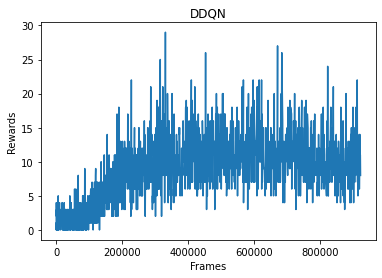

Episode:  1561
Steps:  229977  epsilon:  0.03000983798929731
Episode:  1562
Steps:  230165  epsilon:  0.030009745945481597
Episode:  1563
Steps:  230331  epsilon:  0.030009665388906346
Episode:  1564
Steps:  230459  epsilon:  0.0300096037279429
Episode:  1565
Steps:  230562  epsilon:  0.03000955439588308
Episode:  1566
Steps:  230637  epsilon:  0.03000951863399397
Episode:  1567
Steps:  230764  epsilon:  0.030009458382170107
Episode:  1568
Steps:  230909  epsilon:  0.030009390056877836
Episode:  1569
Steps:  231093  epsilon:  0.030009304064525913
Episode:  1570
Steps:  231228  epsilon:  0.03000924147357248
Steps:  231428  epsilon:  0.03000914951937403


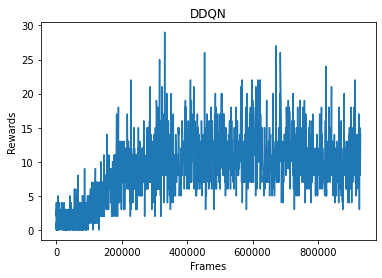

Episode:  1571
Steps:  231500  epsilon:  0.030009116640322086
Episode:  1572
Steps:  231681  epsilon:  0.030009034506941295
Episode:  1573
Steps:  231807  epsilon:  0.03000897776846144
Episode:  1574
Steps:  231981  epsilon:  0.0300089000006563
Episode:  1575
Steps:  232178  epsilon:  0.030008812765985896
Episode:  1576
Steps:  232353  epsilon:  0.030008735990665388
Episode:  1577
Steps:  232539  epsilon:  0.03000865512257169
Episode:  1578
Steps:  232678  epsilon:  0.03000859517801843
Episode:  1579
Steps:  232813  epsilon:  0.030008537355935876
Episode:  1580
Steps:  232916  epsilon:  0.030008493501574713


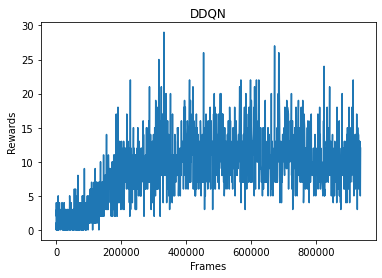

Episode:  1581
Steps:  233094  epsilon:  0.030008418244800102
Episode:  1582
Steps:  233232  epsilon:  0.030008360358847182
Episode:  1583
Steps:  233424  epsilon:  0.030008280483417752
Episode:  1584
Steps:  233547  epsilon:  0.0300082297147185
Episode:  1585
Steps:  233672  epsilon:  0.03000817843940378
Steps:  233872  epsilon:  0.03000809706257204
Episode:  1586
Steps:  233889  epsilon:  0.030008090182993087
Episode:  1587
Steps:  234054  epsilon:  0.030008023713546866
Episode:  1588
Steps:  234179  epsilon:  0.03000797372172438
Episode:  1589
Steps:  234371  epsilon:  0.030007897540251963
Episode:  1590
Steps:  234498  epsilon:  0.03000784754975916


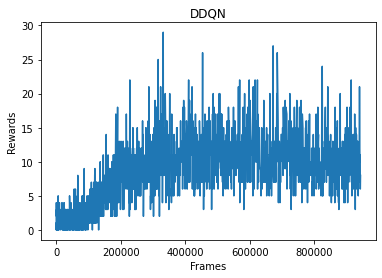

Episode:  1591
Steps:  234677  epsilon:  0.03000777762755741
Steps:  234877  epsilon:  0.03000770023887018
Episode:  1592
Steps:  234890  epsilon:  0.030007695235341234
Episode:  1593
Steps:  235064  epsilon:  0.030007628577177224
Episode:  1594
Steps:  235254  epsilon:  0.03000755644884608
Episode:  1595
Steps:  235434  epsilon:  0.030007488745926597
Steps:  235634  epsilon:  0.030007414231659615
Episode:  1596
Steps:  235657  epsilon:  0.030007405710193988
Episode:  1597
Steps:  235753  epsilon:  0.0300073702479625
Episode:  1598
Steps:  235824  epsilon:  0.030007344129969103
Episode:  1599
Steps:  235953  epsilon:  0.030007296912769963
Steps:  236153  epsilon:  0.030007224307274784
Episode:  1600
Steps:  236197  epsilon:  0.030007208431268792


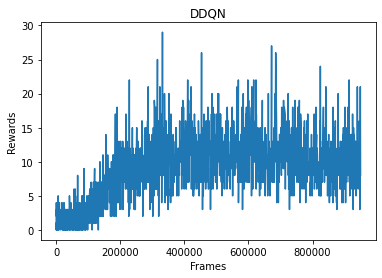

Episode:  1601
Steps:  236359  epsilon:  0.030007150278810915
Steps:  236559  epsilon:  0.030007079132348007
Episode:  1602
Steps:  236569  epsilon:  0.03000707559366658
Episode:  1603
Steps:  236757  epsilon:  0.03000700939470866
Episode:  1604
Steps:  236932  epsilon:  0.030006948330052435
Steps:  237132  epsilon:  0.030006879193013248
Episode:  1605
Steps:  237188  epsilon:  0.030006859958214095
Episode:  1606
Steps:  237274  epsilon:  0.03000683052372328
Steps:  237474  epsilon:  0.030006762558876656
Episode:  1607
Steps:  237628  epsilon:  0.0300067106871358
Episode:  1608
Steps:  237807  epsilon:  0.030006650894457296
Steps:  238007  epsilon:  0.03000658471695173
Episode:  1609
Steps:  238099  epsilon:  0.03000655449681336
Episode:  1610
Steps:  238243  epsilon:  0.03000650747392185
Steps:  238443  epsilon:  0.030006442723474455
Steps:  238643  epsilon:  0.030006378617304777


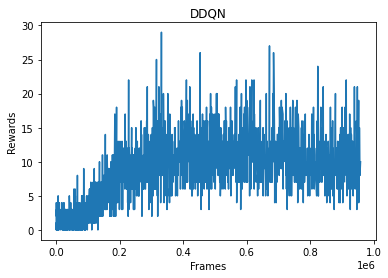

Episode:  1611
Steps:  238686  epsilon:  0.03000636491800959
Episode:  1612
Steps:  238769  epsilon:  0.030006338558334008
Steps:  238969  epsilon:  0.030006275488624796
Episode:  1613
Steps:  239049  epsilon:  0.03000625043680733
Steps:  239249  epsilon:  0.03000618824392196
Episode:  1614
Steps:  239393  epsilon:  0.030006143848580736
Episode:  1615
Steps:  239543  epsilon:  0.030006097942080943
Steps:  239743  epsilon:  0.03000603726654345
Episode:  1616
Steps:  239748  epsilon:  0.03000603575741546
Steps:  239948  epsilon:  0.03000597570062573
Episode:  1617
Steps:  240065  epsilon:  0.030005940844829677
Episode:  1618
Steps:  240264  epsilon:  0.030005882026529925
Episode:  1619
Steps:  240409  epsilon:  0.03000583953605168
Episode:  1620
Steps:  240538  epsilon:  0.03000580199225306
Steps:  240738  epsilon:  0.030005744261465555


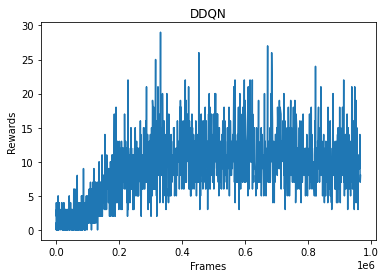

Episode:  1621
Steps:  240787  epsilon:  0.03000573020525086
Episode:  1622
Steps:  240936  epsilon:  0.030005687673847932
Episode:  1623
Steps:  241030  epsilon:  0.0300056610045029
Steps:  241230  epsilon:  0.03000560467656695
Episode:  1624
Steps:  241293  epsilon:  0.030005587049612793
Episode:  1625
Steps:  241447  epsilon:  0.030005544194534564
Steps:  241647  epsilon:  0.03000548902887722
Episode:  1626
Steps:  241688  epsilon:  0.030005477787893964
Episode:  1627
Steps:  241795  epsilon:  0.03000544855998311
Episode:  1628
Steps:  241934  epsilon:  0.030005410823776443
Episode:  1629
Steps:  242119  epsilon:  0.030005361004426225
Episode:  1630
Steps:  242306  epsilon:  0.030005311112642402


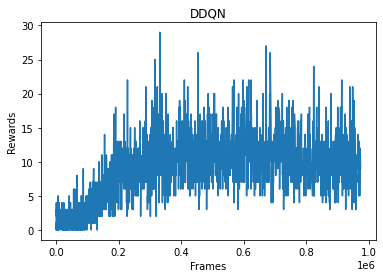

Episode:  1631
Steps:  242464  epsilon:  0.030005269320150227
Steps:  242664  epsilon:  0.0300052168895387
Episode:  1632
Steps:  242703  epsilon:  0.03000520672651627
Steps:  242903  epsilon:  0.03000515491872181
Episode:  1633
Steps:  242963  epsilon:  0.0300051394771396
Steps:  243163  epsilon:  0.030005088338487616
Episode:  1634
Steps:  243177  epsilon:  0.03000508477789703
Steps:  243377  epsilon:  0.030005034183511605
Episode:  1635
Steps:  243456  epsilon:  0.030005014337708
Episode:  1636
Steps:  243608  epsilon:  0.030004976373189326
Episode:  1637
Steps:  243764  epsilon:  0.030004937708466895
Episode:  1638
Steps:  243918  epsilon:  0.030004899834115084
Episode:  1639
Steps:  244055  epsilon:  0.030004866384945594
Episode:  1640
Steps:  244228  epsilon:  0.030004824472249562


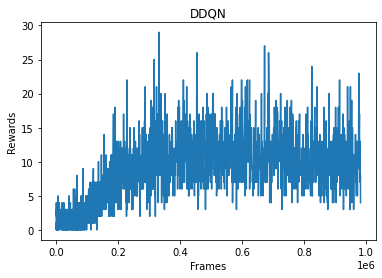

Episode:  1641
Steps:  244319  epsilon:  0.03000480257076449
Steps:  244519  epsilon:  0.03000475478438695
Steps:  244719  epsilon:  0.030004707473491814
Episode:  1642
Steps:  244729  epsilon:  0.030004705120343405
Episode:  1643
Steps:  244917  epsilon:  0.030004661099434587
Steps:  245117  epsilon:  0.030004614720720302
Episode:  1644
Steps:  245226  epsilon:  0.030004589638902412
Steps:  245426  epsilon:  0.0300045439712323
Episode:  1645
Steps:  245446  epsilon:  0.0300045394295323
Steps:  245646  epsilon:  0.030004494261453768
Episode:  1646
Steps:  245787  epsilon:  0.03000446268833653
Episode:  1647
Steps:  245986  epsilon:  0.03000441850476537
Steps:  246186  epsilon:  0.030004374539908375
Episode:  1648
Steps:  246238  epsilon:  0.030004363180877753
Steps:  246438  epsilon:  0.030004319766502634
Episode:  1649
Steps:  246456  epsilon:  0.030004315880461763
Episode:  1650
Steps:  246599  epsilon:  0.030004285131973302
Steps:  246799  epsilon:  0.030004242494197763


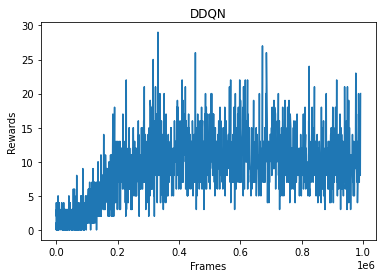

Episode:  1651
Steps:  246812  epsilon:  0.030004239737472568
Episode:  1652
Steps:  246978  epsilon:  0.030004204693286102
Episode:  1653
Steps:  247169  epsilon:  0.03000416472959557
Episode:  1654
Steps:  247299  epsilon:  0.0300041377466428
Episode:  1655
Steps:  247466  epsilon:  0.030004103340304702
Episode:  1656
Steps:  247652  epsilon:  0.030004065356140003
Episode:  1657
Steps:  247827  epsilon:  0.030004029939447775
Episode:  1658
Steps:  247957  epsilon:  0.03000400382978968
Episode:  1659
Steps:  248150  epsilon:  0.03000396537865731
Episode:  1660
Steps:  248264  epsilon:  0.030003942840294322
Steps:  248464  epsilon:  0.03000390360837789


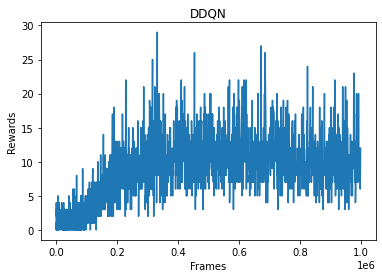

Episode:  1661
Steps:  248467  epsilon:  0.03000390302288055
Episode:  1662
Steps:  248604  epsilon:  0.030003876378534886
Steps:  248804  epsilon:  0.030003837807924014
Episode:  1663
Steps:  248812  epsilon:  0.030003836273107827
Episode:  1664
Steps:  249002  epsilon:  0.03000380000107824
Episode:  1665
Steps:  249188  epsilon:  0.030003764824891012
Episode:  1666
Steps:  249321  epsilon:  0.030003739871866254
Episode:  1667
Steps:  249465  epsilon:  0.030003713041494063
Episode:  1668
Steps:  249629  epsilon:  0.030003682719045757
Episode:  1669
Steps:  249738  epsilon:  0.030003662702820715
Steps:  249938  epsilon:  0.03000362625831872
Episode:  1670
Steps:  250045  epsilon:  0.03000360690964058


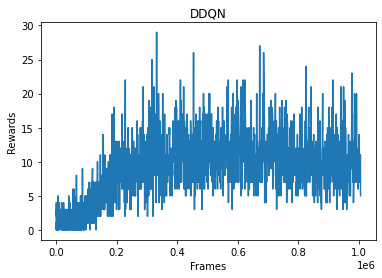

Episode:  1671
Steps:  250146  epsilon:  0.03000358874066218
Episode:  1672
Steps:  250321  epsilon:  0.030003557476163043
Episode:  1673
Steps:  250511  epsilon:  0.03000352384016346
Steps:  250711  epsilon:  0.030003488777367995
Episode:  1674
Steps:  250730  epsilon:  0.030003485464603307
Episode:  1675
Steps:  250858  epsilon:  0.030003463228860123
Episode:  1676
Steps:  251014  epsilon:  0.030003436320753054
Episode:  1677
Steps:  251141  epsilon:  0.030003414569250382
Episode:  1678
Steps:  251284  epsilon:  0.030003390242153254
Episode:  1679
Steps:  251456  epsilon:  0.030003361211083265
Episode:  1680
Steps:  251637  epsilon:  0.030003330929354463


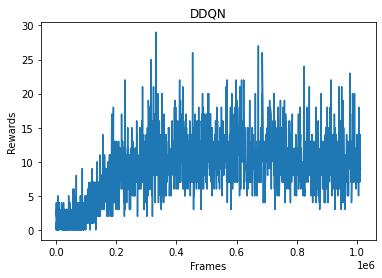

Episode:  1681
Steps:  251802  epsilon:  0.03000330356223189
Episode:  1682
Steps:  251971  epsilon:  0.030003275764740833
Episode:  1683
Steps:  252065  epsilon:  0.030003260404770755
Episode:  1684
Steps:  252246  epsilon:  0.030003231031223362
Episode:  1685
Steps:  252363  epsilon:  0.030003212184870037
Steps:  252563  epsilon:  0.03000318022309655
Episode:  1686
Steps:  252591  epsilon:  0.03000317577389938
Steps:  252791  epsilon:  0.030003144174421105
Episode:  1687
Steps:  252864  epsilon:  0.030003132719103143
Episode:  1688
Steps:  252995  epsilon:  0.030003112266847275
Steps:  253195  epsilon:  0.030003081299274727
Episode:  1689
Steps:  253201  epsilon:  0.03000308037502359
Episode:  1690
Steps:  253359  epsilon:  0.03000305613593138


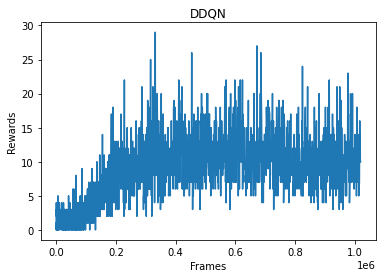

Episode:  1691
Steps:  253532  epsilon:  0.03000302981436049
Episode:  1692
Steps:  253655  epsilon:  0.03000301123818247
Episode:  1693
Steps:  253795  epsilon:  0.030002990233118688
Episode:  1694
Steps:  253957  epsilon:  0.030002966110060703
Steps:  254157  epsilon:  0.03000293659677248
Episode:  1695
Steps:  254213  epsilon:  0.03000292838580224
Episode:  1696
Steps:  254351  epsilon:  0.03000290824949037
Episode:  1697
Steps:  254511  epsilon:  0.030002885076310756
Episode:  1698
Steps:  254670  epsilon:  0.030002862230884976
Steps:  254870  epsilon:  0.030002833751211825
Episode:  1699
Steps:  254907  epsilon:  0.03000282851361835
Episode:  1700
Steps:  255041  epsilon:  0.030002809625921546


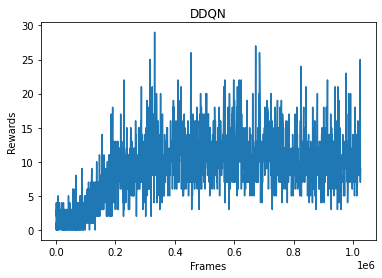

Episode:  1701
Steps:  255197  epsilon:  0.030002787796086394
Steps:  255397  epsilon:  0.03000276005705186
Episode:  1702
Steps:  255494  epsilon:  0.030002746703184462
Steps:  255694  epsilon:  0.030002719373031134
Episode:  1703
Steps:  255698  epsilon:  0.030002718829210913
Episode:  1704
Steps:  255775  epsilon:  0.03000270838184254
Episode:  1705
Steps:  255904  epsilon:  0.030002690968996455
Episode:  1706
Steps:  256100  epsilon:  0.030002664726299533
Episode:  1707
Steps:  256232  epsilon:  0.03000264719701622
Steps:  256432  epsilon:  0.03000262085696581
Episode:  1708
Steps:  256443  epsilon:  0.030002619415890813
Steps:  256643  epsilon:  0.030002593352267216
Episode:  1709
Steps:  256688  epsilon:  0.030002587523784117
Episode:  1710
Steps:  256879  epsilon:  0.03000256293055158


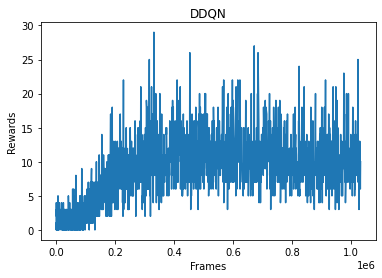

Episode:  1711
Steps:  257054  epsilon:  0.0300025406027359
Episode:  1712
Steps:  257213  epsilon:  0.030002520485018037
Episode:  1713
Steps:  257363  epsilon:  0.030002501652092155
Steps:  257563  epsilon:  0.030002476760237935
Episode:  1714
Steps:  257653  epsilon:  0.03000246563985649
Episode:  1715
Steps:  257774  epsilon:  0.030002450767768786
Episode:  1716
Steps:  257957  epsilon:  0.03000242844552371
Episode:  1717
Steps:  258096  epsilon:  0.03000241162634168
Episode:  1718
Steps:  258239  epsilon:  0.030002394444710864
Episode:  1719
Steps:  258434  epsilon:  0.030002371212316897
Steps:  258634  epsilon:  0.03000234761836013
Episode:  1720
Steps:  258648  epsilon:  0.030002345975602307
Steps:  258848  epsilon:  0.030002322632755044
Steps:  259048  epsilon:  0.030002299522172992
Steps:  259248  epsilon:  0.030002276641545075


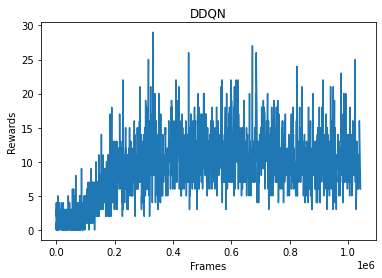

Episode:  1721
Steps:  259433  epsilon:  0.030002255679708736
Episode:  1722
Steps:  259594  epsilon:  0.0300022375943782
Episode:  1723
Steps:  259763  epsilon:  0.030002218766366086
Episode:  1724
Steps:  259949  epsilon:  0.030002198227492678
Episode:  1725
Steps:  260084  epsilon:  0.030002183439422986
Steps:  260284  epsilon:  0.030002161713837728
Episode:  1726
Steps:  260285  epsilon:  0.030002161605754737
Episode:  1727
Steps:  260440  epsilon:  0.03000214491805849
Episode:  1728
Steps:  260555  epsilon:  0.030002132620169965
Steps:  260755  epsilon:  0.030002111400244724
Episode:  1729
Steps:  260792  epsilon:  0.030002107497765176
Episode:  1730
Steps:  260957  epsilon:  0.03000209018243257


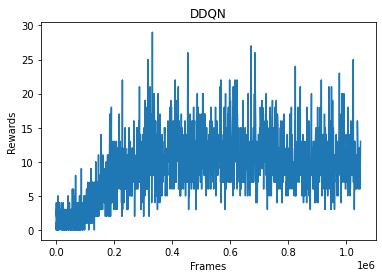

Episode:  1731
Steps:  261132  epsilon:  0.030002071973118216
Episode:  1732
Steps:  261262  epsilon:  0.0300020585489687
Episode:  1733
Steps:  261434  epsilon:  0.03000204092135495
Episode:  1734
Steps:  261624  epsilon:  0.030002021624407706
Steps:  261824  epsilon:  0.030002001508908752
Episode:  1735
Steps:  261854  epsilon:  0.030001998508895962
Steps:  262054  epsilon:  0.030001978623400195
Episode:  1736
Steps:  262072  epsilon:  0.030001976843440237
Steps:  262272  epsilon:  0.030001957173519354
Episode:  1737
Steps:  262275  epsilon:  0.030001956879965343
Episode:  1738
Steps:  262405  epsilon:  0.030001944201495233
Steps:  262605  epsilon:  0.030001924856367133
Episode:  1739
Steps:  262612  epsilon:  0.030001924182785286
Episode:  1740
Steps:  262730  epsilon:  0.030001912863531488


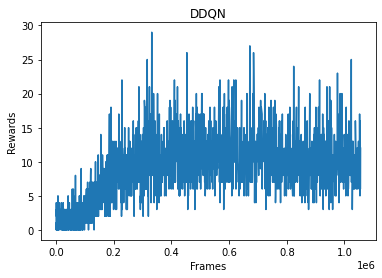

Episode:  1741
Steps:  262885  epsilon:  0.030001898096136688
Episode:  1742
Steps:  263003  epsilon:  0.03000188693034097
Episode:  1743
Steps:  263121  epsilon:  0.030001875830229487
Episode:  1744
Steps:  263259  epsilon:  0.030001862931552513
Episode:  1745
Steps:  263397  epsilon:  0.030001850121570063
Episode:  1746
Steps:  263542  epsilon:  0.030001836756694895
Episode:  1747
Steps:  263732  epsilon:  0.030001819390128096
Episode:  1748
Steps:  263808  epsilon:  0.03000181248956498
Steps:  264008  epsilon:  0.030001794454992483
Episode:  1749
Steps:  264046  epsilon:  0.030001791048764936
Episode:  1750
Steps:  264195  epsilon:  0.03000177775503228


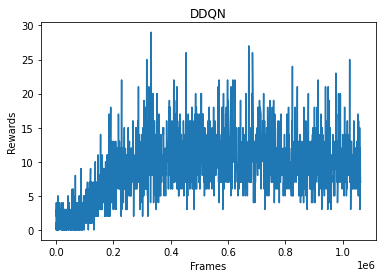

Episode:  1751
Steps:  264331  epsilon:  0.03000176570730675
Episode:  1752
Steps:  264504  epsilon:  0.030001750499805812
Steps:  264704  epsilon:  0.03000173308204172
Episode:  1753
Steps:  264768  epsilon:  0.03000172754504311
Episode:  1754
Steps:  264849  epsilon:  0.030001720562634608
Steps:  265049  epsilon:  0.030001703442750348
Episode:  1755
Steps:  265101  epsilon:  0.030001699019551846
Episode:  1756
Steps:  265265  epsilon:  0.03000168514455675
Episode:  1757
Steps:  265427  epsilon:  0.030001671550018046
Episode:  1758
Steps:  265601  epsilon:  0.030001657070609644
Episode:  1759
Steps:  265756  epsilon:  0.030001644277948013
Episode:  1760
Steps:  265922  epsilon:  0.03000163068692183
Steps:  266122  epsilon:  0.030001614461315853


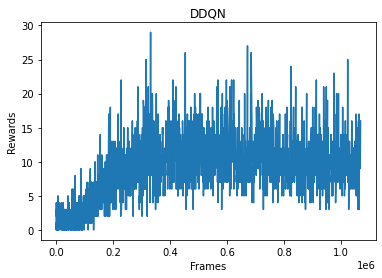

Episode:  1761
Steps:  266133  epsilon:  0.030001613573606273
Episode:  1762
Steps:  266330  epsilon:  0.030001597757926348
Steps:  266530  epsilon:  0.030001581859969352
Episode:  1763
Steps:  266532  epsilon:  0.030001581701791263
Steps:  266732  epsilon:  0.030001565963595482
Episode:  1764
Steps:  266745  epsilon:  0.030001564946049882
Episode:  1765
Steps:  266858  epsilon:  0.030001556129036218
Episode:  1766
Steps:  267057  epsilon:  0.03000154072232779
Episode:  1767
Steps:  267192  epsilon:  0.030001530357472817
Episode:  1768
Steps:  267283  epsilon:  0.03000152341016343
Episode:  1769
Steps:  267427  epsilon:  0.030001512481002447
Steps:  267627  epsilon:  0.030001497431565022
Episode:  1770
Steps:  267770  epsilon:  0.030001486763114493


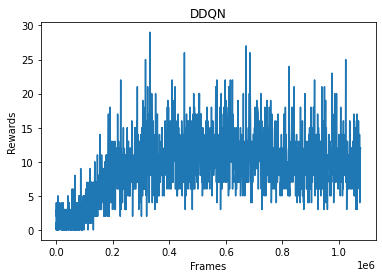

Episode:  1771
Steps:  267959  epsilon:  0.03000147277938027
Steps:  268159  epsilon:  0.030001458124980587
Episode:  1772
Steps:  268178  epsilon:  0.030001456740419624
Episode:  1773
Steps:  268308  epsilon:  0.03000144730231397
Episode:  1774
Steps:  268445  epsilon:  0.03000143742217124
Steps:  268645  epsilon:  0.030001423119581667
Episode:  1775
Steps:  268676  epsilon:  0.030001420915454952
Episode:  1776
Steps:  268771  epsilon:  0.030001414182110893
Episode:  1777
Steps:  268883  epsilon:  0.030001406284824114
Episode:  1778
Steps:  269069  epsilon:  0.03000139326700195
Episode:  1779
Steps:  269208  epsilon:  0.030001383617367608
Episode:  1780
Steps:  269395  epsilon:  0.030001370740836808


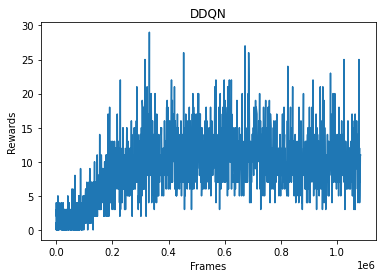

Episode:  1781
Steps:  269574  epsilon:  0.030001358527442786
Steps:  269774  epsilon:  0.030001345009868872
Episode:  1782
Steps:  269781  epsilon:  0.03000134453919779
Episode:  1783
Steps:  269956  epsilon:  0.030001332825800656
Episode:  1784
Steps:  270115  epsilon:  0.030001322271843107
Steps:  270315  epsilon:  0.03000130911501844
Episode:  1785
Steps:  270415  epsilon:  0.030001302585780047
Episode:  1786
Steps:  270514  epsilon:  0.030001296153912442
Episode:  1787
Steps:  270662  epsilon:  0.030001286597774807
Episode:  1788
Steps:  270855  epsilon:  0.03000127424181965
Steps:  271055  epsilon:  0.0300012615629017
Episode:  1789
Steps:  271057  epsilon:  0.030001261436751716
Episode:  1790
Steps:  271212  epsilon:  0.03000125169840174


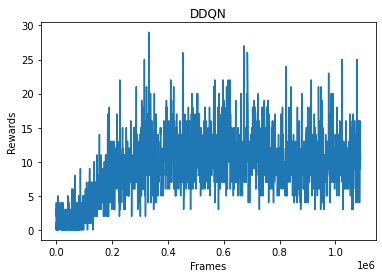

Episode:  1791
Steps:  271399  epsilon:  0.030001240049564858
Episode:  1792
Steps:  271580  epsilon:  0.03000122887774503
Episode:  1793
Steps:  271738  epsilon:  0.030001219207857196
Episode:  1794
Steps:  271913  epsilon:  0.030001208586325413
Episode:  1795
Steps:  272070  epsilon:  0.030001199136063566
Episode:  1796
Steps:  272216  epsilon:  0.030001190414243675
Steps:  272416  epsilon:  0.030001178569424043
Steps:  272616  epsilon:  0.030001166842462335
Episode:  1797
Steps:  272730  epsilon:  0.030001160210379692
Episode:  1798
Steps:  272864  epsilon:  0.03000115246295301
Episode:  1799
Steps:  273026  epsilon:  0.030001143165707768
Steps:  273226  epsilon:  0.03000113179101892
Episode:  1800
Steps:  273276  epsilon:  0.030001128965075275


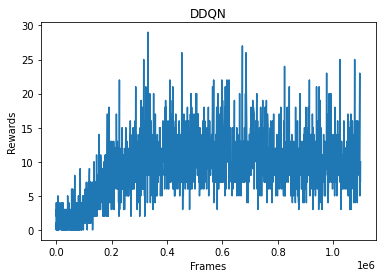

Episode:  1801
Steps:  273434  epsilon:  0.030001120081387948
Episode:  1802
Steps:  273563  epsilon:  0.030001112880112077
Episode:  1803
Steps:  273678  epsilon:  0.03000110649941352
Episode:  1804
Steps:  273790  epsilon:  0.030001100320334376
Episode:  1805
Steps:  273940  epsilon:  0.030001092098801155
Episode:  1806
Steps:  274102  epsilon:  0.03000108328853063
Episode:  1807
Steps:  274236  epsilon:  0.030001076054757676
Episode:  1808
Steps:  274354  epsilon:  0.030001069724726562
Episode:  1809
Steps:  274522  epsilon:  0.030001060776673295
Episode:  1810
Steps:  274712  epsilon:  0.030001050747011225


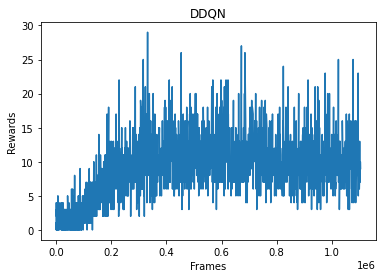

Episode:  1811
Steps:  274889  epsilon:  0.030001041488927623
Steps:  275089  epsilon:  0.030001031125939645
Episode:  1812
Steps:  275093  epsilon:  0.030001030919735078
Steps:  275293  epsilon:  0.030001020661912323
Episode:  1813
Steps:  275316  epsilon:  0.030001019488825775
Steps:  275516  epsilon:  0.03000100934474247
Episode:  1814
Steps:  275523  epsilon:  0.030001008991533625
Episode:  1815
Steps:  275658  epsilon:  0.030001002203775228
Episode:  1816
Steps:  275826  epsilon:  0.030000993820522473
Steps:  276026  epsilon:  0.03000098393184305
Episode:  1817
Steps:  276042  epsilon:  0.03000098314501235
Episode:  1818
Steps:  276183  epsilon:  0.03000097623821508
Steps:  276383  epsilon:  0.03000096652448254
Steps:  276583  epsilon:  0.030000956907403252
Episode:  1819
Steps:  276622  epsilon:  0.030000955043251957
Episode:  1820
Steps:  276791  epsilon:  0.030000947007136878


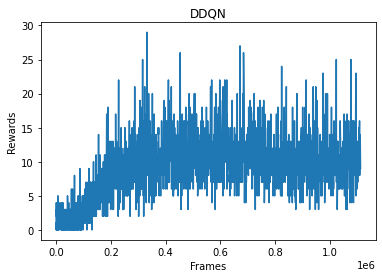

Episode:  1821
Steps:  276958  epsilon:  0.03000093913254944
Episode:  1822
Steps:  277158  epsilon:  0.030000929788024443
Steps:  277358  epsilon:  0.03000092053647902
Episode:  1823
Steps:  277395  epsilon:  0.03000091883506083
Steps:  277595  epsilon:  0.03000090969249922
Episode:  1824
Steps:  277670  epsilon:  0.030000906287540634
Steps:  277870  epsilon:  0.030000897269828936
Episode:  1825
Steps:  277898  epsilon:  0.030000896014530088
Episode:  1826
Steps:  277984  epsilon:  0.030000892169939404
Steps:  278184  epsilon:  0.030000883292700183
Episode:  1827
Steps:  278341  epsilon:  0.030000876385996765
Episode:  1828
Steps:  278508  epsilon:  0.030000869098640744
Episode:  1829
Steps:  278606  epsilon:  0.030000864850473912
Episode:  1830
Steps:  278726  epsilon:  0.03000085967690729


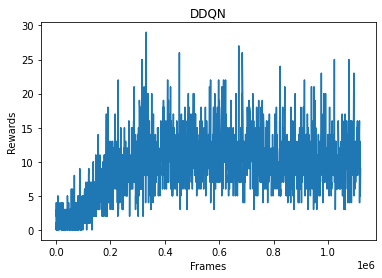

Episode:  1831
Steps:  278885  epsilon:  0.030000852869570892
Steps:  279085  epsilon:  0.03000084438337687
Episode:  1832
Steps:  279167  epsilon:  0.030000840928492378
Episode:  1833
Steps:  279362  epsilon:  0.030000832769280374
Episode:  1834
Steps:  279553  epsilon:  0.030000824854188465
Episode:  1835
Steps:  279694  epsilon:  0.030000819059417008
Steps:  279894  epsilon:  0.03000081090963964
Episode:  1836
Steps:  279924  epsilon:  0.030000809694186996
Steps:  280124  epsilon:  0.030000801637595224
Episode:  1837
Steps:  280244  epsilon:  0.030000796842170312
Episode:  1838
Steps:  280442  epsilon:  0.030000788992353533
Steps:  280642  epsilon:  0.030000781141748447
Episode:  1839
Steps:  280768  epsilon:  0.030000776236024686
Episode:  1840
Steps:  280910  epsilon:  0.030000770744267716


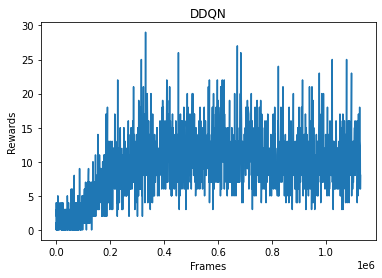

Episode:  1841
Steps:  281057  epsilon:  0.030000765100065205
Episode:  1842
Steps:  281221  epsilon:  0.03000075885189717
Episode:  1843
Steps:  281409  epsilon:  0.03000075175211061
Episode:  1844
Steps:  281507  epsilon:  0.03000074807753533
Episode:  1845
Steps:  281640  epsilon:  0.030000743119324044
Episode:  1846
Steps:  281778  epsilon:  0.030000738009450047
Episode:  1847
Steps:  281894  epsilon:  0.03000073374138459
Episode:  1848
Steps:  282020  epsilon:  0.030000729133344436
Steps:  282220  epsilon:  0.03000072187834644
Episode:  1849
Steps:  282304  epsilon:  0.030000718852815446
Episode:  1850
Steps:  282447  epsilon:  0.03000071373134888


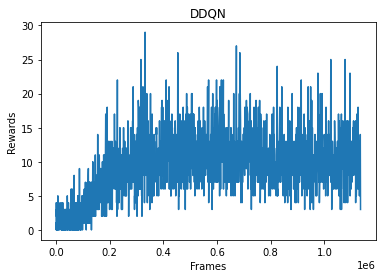

Episode:  1851
Steps:  282528  epsilon:  0.03000071084658251
Episode:  1852
Steps:  282714  epsilon:  0.030000704266354778
Steps:  282914  epsilon:  0.030000697258787463
Steps:  283114  epsilon:  0.03000069032094661
Episode:  1853
Steps:  283282  epsilon:  0.03000068454653713
Episode:  1854
Steps:  283440  epsilon:  0.03000067915992462
Episode:  1855
Steps:  283614  epsilon:  0.03000067327686171
Episode:  1856
Steps:  283775  epsilon:  0.030000667878739565
Episode:  1857
Steps:  283870  epsilon:  0.03000066471383814
Steps:  284070  epsilon:  0.030000658099824943
Episode:  1858
Steps:  284074  epsilon:  0.03000065796821814
Episode:  1859
Steps:  284255  epsilon:  0.030000652040469287
Episode:  1860
Steps:  284375  epsilon:  0.030000648139939762


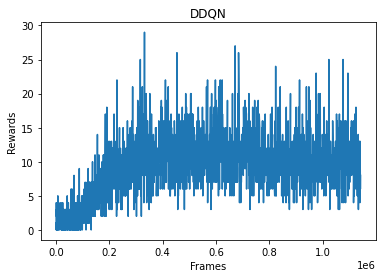

Episode:  1861
Steps:  284513  epsilon:  0.030000643683167724
Episode:  1862
Steps:  284632  epsilon:  0.03000063986462431
Steps:  284832  epsilon:  0.030000633497864918
Episode:  1863
Steps:  284849  epsilon:  0.030000632959620518
Steps:  285049  epsilon:  0.030000626661567064
Episode:  1864
Steps:  285069  epsilon:  0.030000626035218723
Steps:  285269  epsilon:  0.030000619806064218
Episode:  1865
Steps:  285292  epsilon:  0.030000619093696935
Episode:  1866
Steps:  285466  epsilon:  0.030000613730943575
Episode:  1867
Steps:  285661  epsilon:  0.030000607776143697
Episode:  1868
Steps:  285792  epsilon:  0.030000603808219093
Steps:  285992  epsilon:  0.03000059780022693
Steps:  286192  epsilon:  0.030000591852015288
Episode:  1869
Steps:  286347  epsilon:  0.030000587282890397
Episode:  1870
Steps:  286470  epsilon:  0.030000583682184143


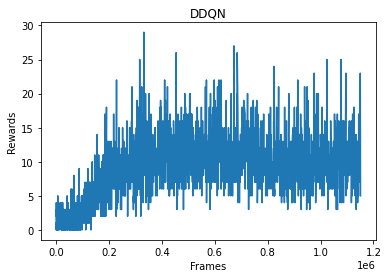

Episode:  1871
Steps:  286586  epsilon:  0.030000580306626057
Steps:  286786  epsilon:  0.03000057453247865
Episode:  1872
Steps:  286949  epsilon:  0.03000056986906816
Episode:  1873
Steps:  287084  epsilon:  0.03000056603540512
Episode:  1874
Steps:  287201  epsilon:  0.030000562733764714
Episode:  1875
Steps:  287312  epsilon:  0.03000055961924311
Steps:  287512  epsilon:  0.030000554050938603
Episode:  1876
Steps:  287563  epsilon:  0.03000055263990854
Episode:  1877
Steps:  287756  epsilon:  0.030000547332582457
Episode:  1878
Steps:  287875  epsilon:  0.030000544085622874
Episode:  1879
Steps:  287994  epsilon:  0.03000054085792534
Steps:  288194  epsilon:  0.030000535476299064
Episode:  1880
Steps:  288345  epsilon:  0.030000531448676416


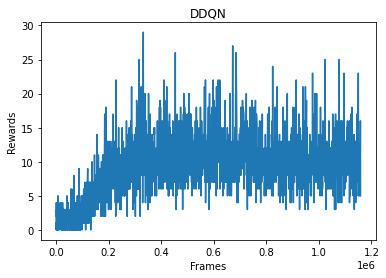

Episode:  1881
Steps:  288446  epsilon:  0.03000052877162584
Episode:  1882
Steps:  288577  epsilon:  0.03000052531948978
Steps:  288777  epsilon:  0.03000052009247352
Episode:  1883
Steps:  288781  epsilon:  0.030000519988465427
Episode:  1884
Steps:  288906  epsilon:  0.030000516748672417
Steps:  289106  epsilon:  0.030000511606937216
Episode:  1885
Steps:  289128  epsilon:  0.030000511044478994
Episode:  1886
Steps:  289295  epsilon:  0.030000506795023762
Episode:  1887
Steps:  289438  epsilon:  0.030000503184362835
Steps:  289638  epsilon:  0.030000498177594773
Episode:  1888
Steps:  289640  epsilon:  0.030000498127779503
Steps:  289840  epsilon:  0.030000493171325283
Episode:  1889
Steps:  289930  epsilon:  0.0300004909570402
Steps:  290130  epsilon:  0.030000486071936026
Episode:  1890
Steps:  290208  epsilon:  0.03000048417994725
Steps:  290408  epsilon:  0.030000479362276282


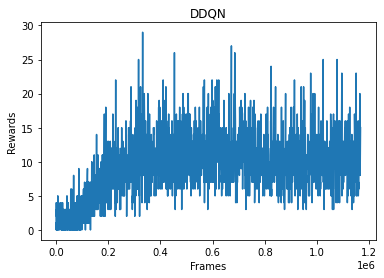

Episode:  1891
Steps:  290583  epsilon:  0.030000475186153543
Episode:  1892
Steps:  290772  epsilon:  0.03000047071679537
Steps:  290972  epsilon:  0.030000466033085
Episode:  1893
Steps:  291158  epsilon:  0.030000461719068578
Episode:  1894
Steps:  291240  epsilon:  0.030000459829895847
Episode:  1895
Steps:  291432  epsilon:  0.030000455436650166
Steps:  291632  epsilon:  0.03000045090497978
Episode:  1896
Steps:  291659  epsilon:  0.03000045029666876
Episode:  1897
Steps:  291807  epsilon:  0.03000044697677218
Episode:  1898
Steps:  291938  epsilon:  0.03000044405864163
Steps:  292138  epsilon:  0.030000439640184322
Episode:  1899
Steps:  292146  epsilon:  0.030000439464363416
Episode:  1900
Steps:  292308  epsilon:  0.030000435919079853


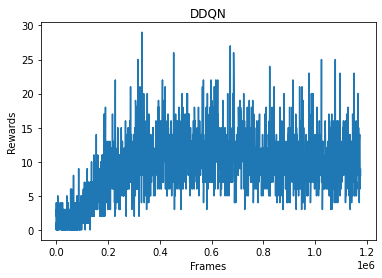

Episode:  1901
Steps:  292453  epsilon:  0.030000432770095387
Episode:  1902
Steps:  292574  epsilon:  0.030000430159740594
Episode:  1903
Steps:  292723  epsilon:  0.03000042696695841
Episode:  1904
Steps:  292843  epsilon:  0.030000424412826715
Steps:  293043  epsilon:  0.030000420189848533
Episode:  1905
Steps:  293067  epsilon:  0.030000419685923128
Steps:  293267  epsilon:  0.03000041550997842
Episode:  1906
Steps:  293310  epsilon:  0.030000414617591627
Episode:  1907
Steps:  293445  epsilon:  0.030000411828347173
Episode:  1908
Steps:  293610  epsilon:  0.03000040844473988
Episode:  1909
Steps:  293765  epsilon:  0.030000405291527626
Steps:  293965  epsilon:  0.030000401258809546
Episode:  1910
Steps:  294004  epsilon:  0.030000400477117266


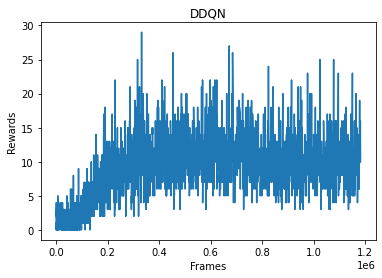

Episode:  1911
Steps:  294182  epsilon:  0.030000396928684867
Episode:  1912
Steps:  294343  epsilon:  0.0300003937462355
Steps:  294543  epsilon:  0.030000389828394997
Episode:  1913
Steps:  294566  epsilon:  0.030000389380350018
Steps:  294766  epsilon:  0.0300003855059508
Episode:  1914
Steps:  294793  epsilon:  0.030000384985868902
Episode:  1915
Steps:  294950  epsilon:  0.030000381975560746
Episode:  1916
Steps:  295140  epsilon:  0.030000378363975115
Steps:  295340  epsilon:  0.03000037459919066
Steps:  295540  epsilon:  0.030000370871866435
Episode:  1917
Steps:  295554  epsilon:  0.03000037061234697
Episode:  1918
Steps:  295714  epsilon:  0.030000367659276227
Episode:  1919
Steps:  295873  epsilon:  0.030000364747972744
Steps:  296073  epsilon:  0.03000036111866978
Episode:  1920
Steps:  296078  epsilon:  0.030000361028401392


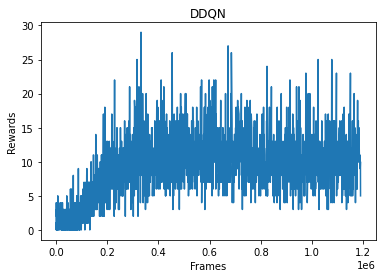

Episode:  1921
Steps:  296176  epsilon:  0.030000359263689304
Steps:  296376  epsilon:  0.030000355688955867
Episode:  1922
Steps:  296433  epsilon:  0.030000354676685513
Steps:  296633  epsilon:  0.030000351147593526
Episode:  1923
Steps:  296650  epsilon:  0.030000350849244888
Steps:  296850  epsilon:  0.030000347358236572
Episode:  1924
Steps:  296889  epsilon:  0.030000346681547996
Episode:  1925
Steps:  297016  epsilon:  0.03000034448709493
Steps:  297216  epsilon:  0.03000034105939106
Episode:  1926
Steps:  297237  epsilon:  0.030000340701466646
Steps:  297437  epsilon:  0.03000033731143041
Episode:  1927
Steps:  297501  epsilon:  0.03000033623375903
Episode:  1928
Steps:  297598  epsilon:  0.03000033460697344
Episode:  1929
Steps:  297729  epsilon:  0.030000332422459856
Episode:  1930
Steps:  297874  epsilon:  0.030000330021112423


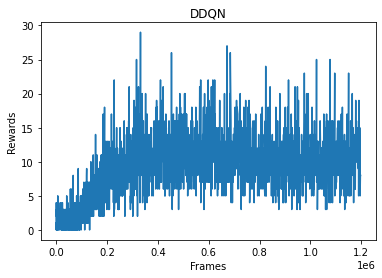

Episode:  1931
Steps:  298017  epsilon:  0.030000327669877154
Steps:  298217  epsilon:  0.030000324409507402
Episode:  1932
Steps:  298241  epsilon:  0.030000324020449474
Steps:  298441  epsilon:  0.030000320796392133
Episode:  1933
Steps:  298481  epsilon:  0.03000032015544051
Episode:  1934
Steps:  298655  epsilon:  0.030000317382169402
Episode:  1935
Steps:  298818  epsilon:  0.030000314806016802
Episode:  1936
Steps:  299010  epsilon:  0.030000311798338994
Episode:  1937
Steps:  299192  epsilon:  0.03000030897384505
Episode:  1938
Steps:  299348  epsilon:  0.03000030657322365
Episode:  1939
Steps:  299449  epsilon:  0.03000030502893149
Episode:  1940
Steps:  299631  epsilon:  0.030000302265759716
Steps:  299831  epsilon:  0.030000299258165154


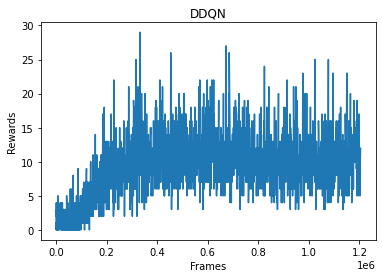

Episode:  1941
Steps:  299880  epsilon:  0.030000298525880063
Episode:  1942
Steps:  300040  epsilon:  0.030000296147200428
Episode:  1943
Steps:  300205  epsilon:  0.030000293714036626
Episode:  1944
Steps:  300396  epsilon:  0.03000029092241877
Steps:  300596  epsilon:  0.030000288027692334
Episode:  1945
Steps:  300717  epsilon:  0.03000028629038545
Episode:  1946
Steps:  300829  epsilon:  0.030000284691639956
Steps:  301029  epsilon:  0.030000281858910807
Episode:  1947
Steps:  301073  epsilon:  0.030000281239502803
Episode:  1948
Steps:  301251  epsilon:  0.03000027874757675
Steps:  301451  epsilon:  0.03000027597399202
Episode:  1949
Steps:  301486  epsilon:  0.03000027549145987
Episode:  1950
Steps:  301662  epsilon:  0.030000273077770832


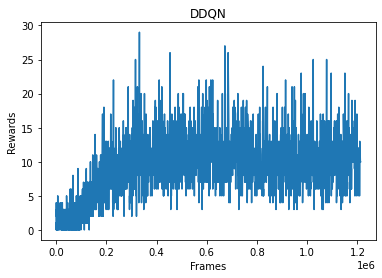

Episode:  1951
Steps:  301825  epsilon:  0.030000270861231665
Steps:  302025  epsilon:  0.03000026816611738
Episode:  1952
Steps:  302052  epsilon:  0.03000026780433738
Steps:  302252  epsilon:  0.030000265139639697
Episode:  1953
Steps:  302409  epsilon:  0.030000263066441477
Episode:  1954
Steps:  302556  epsilon:  0.030000261139991508
Episode:  1955
Steps:  302691  epsilon:  0.030000259383232298
Episode:  1956
Steps:  302823  epsilon:  0.030000257676939923
Episode:  1957
Steps:  303022  epsilon:  0.0300002551257675
Episode:  1958
Steps:  303202  epsilon:  0.03000025283993726
Episode:  1959
Steps:  303338  epsilon:  0.030000251126458117
Episode:  1960
Steps:  303498  epsilon:  0.030000249125461113


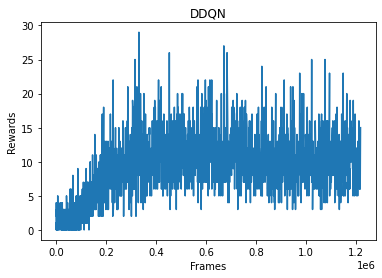

Episode:  1961
Steps:  303675  epsilon:  0.030000246930428128
Steps:  303875  epsilon:  0.030000244473429315
Episode:  1962
Steps:  304062  epsilon:  0.030000242198255762
Steps:  304262  epsilon:  0.030000239788342854
Episode:  1963
Steps:  304304  epsilon:  0.030000239285315696
Episode:  1964
Steps:  304446  epsilon:  0.030000237592406893
Steps:  304646  epsilon:  0.030000235228322944
Episode:  1965
Steps:  304703  epsilon:  0.030000234558876637
Episode:  1966
Steps:  304903  epsilon:  0.03000023222497682
Episode:  1967
Steps:  305071  epsilon:  0.03000023028245702
Episode:  1968
Steps:  305240  epsilon:  0.030000228344768523
Steps:  305440  epsilon:  0.03000022607270011
Episode:  1969
Steps:  305460  epsilon:  0.030000225846740412
Episode:  1970
Steps:  305587  epsilon:  0.03000022441715734


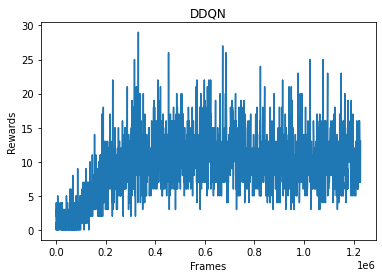

Episode:  1971
Steps:  305785  epsilon:  0.030000222206388844
Episode:  1972
Steps:  305865  epsilon:  0.03000022131933857
Episode:  1973
Steps:  306037  epsilon:  0.030000219424153235
Steps:  306237  epsilon:  0.030000217240846432
Steps:  306437  epsilon:  0.030000215079263894
Steps:  306637  epsilon:  0.03000021293918946
Episode:  1974
Steps:  306758  epsilon:  0.03000021165479657
Episode:  1975
Steps:  306902  epsilon:  0.030000210136354986
Steps:  307102  epsilon:  0.030000208045463318
Episode:  1976
Steps:  307233  epsilon:  0.03000020668721864
Episode:  1977
Steps:  307404  epsilon:  0.030000204927576112
Episode:  1978
Steps:  307546  epsilon:  0.030000203477743317
Steps:  307746  epsilon:  0.030000201453105942
Episode:  1979
Steps:  307750  epsilon:  0.030000201412819352
Episode:  1980
Steps:  307878  epsilon:  0.030000200127893457
Steps:  308078  epsilon:  0.030000198136587646
Steps:  308278  epsilon:  0.030000196165095656


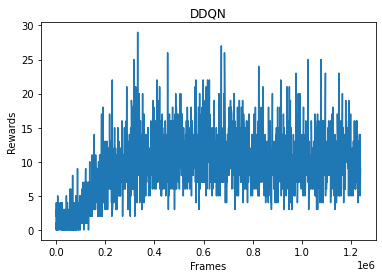

Episode:  1981
Steps:  308315  epsilon:  0.03000019580252571
Episode:  1982
Steps:  308498  epsilon:  0.030000194019104198
Episode:  1983
Steps:  308606  epsilon:  0.030000192974224748
Episode:  1984
Steps:  308787  epsilon:  0.030000191235686764
Episode:  1985
Steps:  308934  epsilon:  0.03000018983525735
Episode:  1986
Steps:  309127  epsilon:  0.03000018801215772
Episode:  1987
Steps:  309289  epsilon:  0.03000018649541036
Steps:  309489  epsilon:  0.030000184639750023
Episode:  1988
Steps:  309509  epsilon:  0.030000184455202562
Episode:  1989
Steps:  309654  epsilon:  0.03000018312273836
Episode:  1990
Steps:  309811  epsilon:  0.030000181690852373


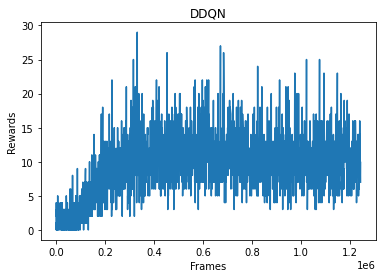

Episode:  1991
Steps:  309941  epsilon:  0.030000180513691747
Episode:  1992
Steps:  310062  epsilon:  0.030000179424880886
Steps:  310262  epsilon:  0.03000017763957349
Episode:  1993
Steps:  310346  epsilon:  0.030000176895051873
Episode:  1994
Steps:  310479  epsilon:  0.030000175722602492
Episode:  1995
Steps:  310645  epsilon:  0.030000174270140945
Steps:  310845  epsilon:  0.03000017253612407
Episode:  1996
Steps:  310999  epsilon:  0.030000171212697647
Episode:  1997
Steps:  311195  epsilon:  0.030000169543008052
Steps:  311395  epsilon:  0.030000167856026935
Episode:  1998
Steps:  311437  epsilon:  0.030000167503899142
Steps:  311637  epsilon:  0.030000165837207497
Episode:  1999
Steps:  311678  epsilon:  0.03000016549758945
Episode:  2000
Steps:  311841  epsilon:  0.030000164154265575


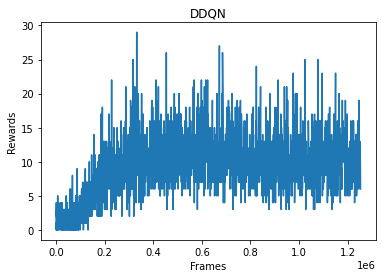

Episode:  2001
Steps:  311960  epsilon:  0.030000163180447677
Episode:  2002
Steps:  312129  epsilon:  0.030000161807382266
Episode:  2003
Steps:  312309  epsilon:  0.030000160357649408
Steps:  312509  epsilon:  0.030000158762064136
Episode:  2004
Steps:  312650  epsilon:  0.030000157646727765
Steps:  312850  epsilon:  0.030000156078116617
Episode:  2005
Steps:  312927  epsilon:  0.030000155478371118
Episode:  2006
Steps:  313099  epsilon:  0.03000015414699027
Steps:  313299  epsilon:  0.03000015261320209
Episode:  2007
Steps:  313319  epsilon:  0.030000152460665168
Episode:  2008
Steps:  313512  epsilon:  0.03000015099649573
Steps:  313712  epsilon:  0.030000149494055495
Episode:  2009
Steps:  313725  epsilon:  0.03000014939691593
Steps:  313925  epsilon:  0.03000014791039178
Episode:  2010
Steps:  313958  epsilon:  0.030000147666540865


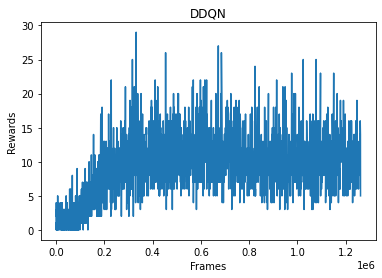

Episode:  2011
Steps:  314050  epsilon:  0.030000146988834697
Episode:  2012
Steps:  314235  epsilon:  0.030000145635457
Episode:  2013
Steps:  314374  epsilon:  0.030000144626799716
Episode:  2014
Steps:  314529  epsilon:  0.030000143510274142
Episode:  2015
Steps:  314651  epsilon:  0.03000014263752606
Steps:  314851  epsilon:  0.03000014121825896
Episode:  2016
Steps:  314872  epsilon:  0.03000014107005761
Episode:  2017
Steps:  315037  epsilon:  0.03000013991101725
Steps:  315237  epsilon:  0.030000138518879366
Episode:  2018
Steps:  315247  epsilon:  0.03000013844963724
Episode:  2019
Steps:  315396  epsilon:  0.030000137422020068
Episode:  2020
Steps:  315549  epsilon:  0.03000013637475252


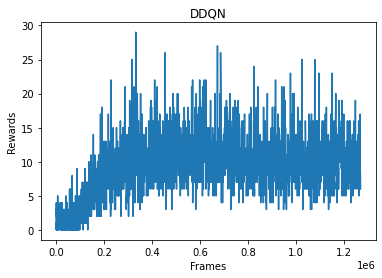

Episode:  2021
Steps:  315672  epsilon:  0.03000013553862153
Episode:  2022
Steps:  315872  epsilon:  0.030000134189989713
Episode:  2023
Steps:  316036  epsilon:  0.030000133094130958
Steps:  316236  epsilon:  0.03000013176982223
Episode:  2024
Steps:  316362  epsilon:  0.03000013094228184
Episode:  2025
Steps:  316548  epsilon:  0.030000129730163704
Episode:  2026
Steps:  316727  epsilon:  0.030000128574259127
Steps:  316927  epsilon:  0.03000012729492387
Episode:  2027
Steps:  316997  epsilon:  0.03000012685017041
Steps:  317197  epsilon:  0.030000125587990128
Steps:  317397  epsilon:  0.030000124338368746
Steps:  317597  epsilon:  0.030000123101181306
Episode:  2028
Steps:  317652  epsilon:  0.030000122763118107
Episode:  2029
Steps:  317791  epsilon:  0.030000121912872463
Episode:  2030
Steps:  317946  epsilon:  0.030000120971699455
Steps:  318146  epsilon:  0.030000119768010935


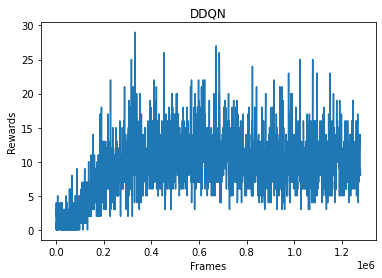

Episode:  2031
Steps:  318224  epsilon:  0.030000119301825345
Episode:  2032
Steps:  318410  epsilon:  0.03000011819746162
Steps:  318610  epsilon:  0.030000117021377226
Episode:  2033
Steps:  318668  epsilon:  0.030000116682506833
Episode:  2034
Steps:  318821  epsilon:  0.030000115793291243
Episode:  2035
Steps:  318975  epsilon:  0.030000114905106796
Episode:  2036
Steps:  319171  epsilon:  0.030000113784536514
Episode:  2037
Steps:  319315  epsilon:  0.030000112968230082
Episode:  2038
Steps:  319465  epsilon:  0.030000112124137657
Episode:  2039
Steps:  319596  epsilon:  0.030000111392124516
Steps:  319796  epsilon:  0.03000011028375436
Episode:  2040
Steps:  319821  epsilon:  0.03000011014598579


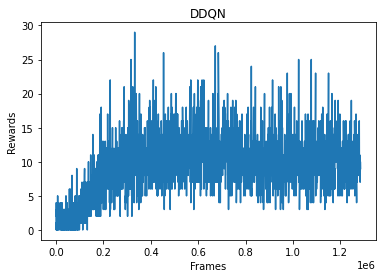

Episode:  2041
Steps:  320000  epsilon:  0.030000109164577567
Episode:  2042
Steps:  320132  epsilon:  0.03000010844646374
Episode:  2043
Steps:  320329  epsilon:  0.030000107383509715
Steps:  320529  epsilon:  0.03000010631502594
Episode:  2044
Steps:  320674  epsilon:  0.030000105547029355
Episode:  2045
Steps:  320816  epsilon:  0.030000104800299472
Episode:  2046
Steps:  320995  epsilon:  0.03000010386652168
Steps:  321195  epsilon:  0.030000102833032522
Steps:  321395  epsilon:  0.030000101809826752
Episode:  2047
Steps:  321431  epsilon:  0.0300001016267339
Episode:  2048
Steps:  321609  epsilon:  0.03000010072626898
Episode:  2049
Steps:  321738  epsilon:  0.03000010007867528
Steps:  321938  epsilon:  0.030000099082875823
Episode:  2050
Steps:  322077  epsilon:  0.030000098396637274


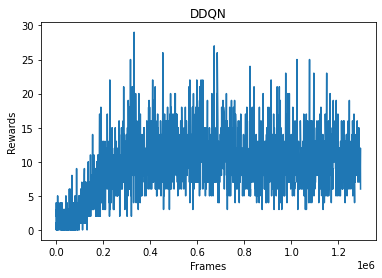

Episode:  2051
Steps:  322193  epsilon:  0.030000097827588616
Episode:  2052
Steps:  322311  epsilon:  0.030000097252105187
Steps:  322511  epsilon:  0.030000096284430573
Episode:  2053
Steps:  322607  epsilon:  0.030000095823372732
Episode:  2054
Steps:  322792  epsilon:  0.030000094941093368
Steps:  322992  epsilon:  0.030000093996413704
Episode:  2055
Steps:  323074  epsilon:  0.03000009361181737
Episode:  2056
Steps:  323250  epsilon:  0.030000092791647417
Episode:  2057
Steps:  323405  epsilon:  0.030000092075291612
Episode:  2058
Steps:  323569  epsilon:  0.030000091323361348
Episode:  2059
Steps:  323716  epsilon:  0.030000090654595368
Episode:  2060
Steps:  323878  epsilon:  0.030000089923259057
Steps:  324078  epsilon:  0.03000008902850768


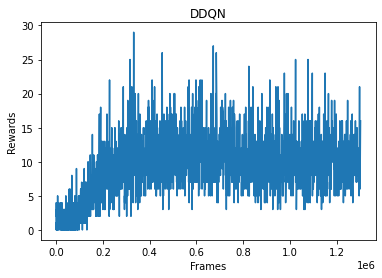

Episode:  2061
Steps:  324109  epsilon:  0.030000088890620384
Episode:  2062
Steps:  324289  epsilon:  0.030000088094194095
Episode:  2063
Steps:  324451  epsilon:  0.030000087383513264
Episode:  2064
Steps:  324587  epsilon:  0.030000086791321108
Episode:  2065
Steps:  324712  epsilon:  0.03000008625056697
Steps:  324912  epsilon:  0.030000085392359488
Steps:  325112  epsilon:  0.030000084542691315
Episode:  2066
Steps:  325130  epsilon:  0.03000008446663712
Episode:  2067
Steps:  325309  epsilon:  0.030000083714033645
Episode:  2068
Steps:  325499  epsilon:  0.030000082922515988
Episode:  2069
Steps:  325680  epsilon:  0.030000082175452778
Episode:  2070
Steps:  325867  epsilon:  0.030000081410693116
Steps:  326067  epsilon:  0.030000080600643186


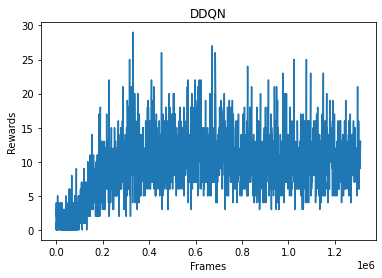

Episode:  2071
Steps:  326227  epsilon:  0.030000079958410395
Steps:  326427  epsilon:  0.03000007916281092
Episode:  2072
Steps:  326493  epsilon:  0.03000007890200421
Episode:  2073
Steps:  326636  epsilon:  0.030000078339866915
Steps:  326836  epsilon:  0.030000077560372217
Episode:  2074
Steps:  326956  epsilon:  0.03000007709640328
Episode:  2075
Steps:  327135  epsilon:  0.030000076409469088
Episode:  2076
Steps:  327265  epsilon:  0.0300000759144182
Episode:  2077
Steps:  327379  epsilon:  0.030000075482936903
Episode:  2078
Steps:  327535  epsilon:  0.03000007489646023
Episode:  2079
Steps:  327690  epsilon:  0.030000074318256097
Episode:  2080
Steps:  327890  epsilon:  0.030000073578777094


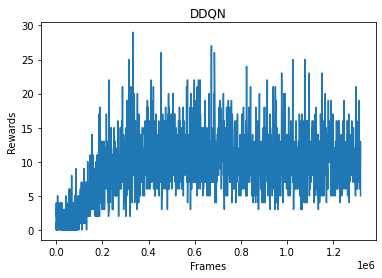

Episode:  2081
Steps:  327996  epsilon:  0.030000073189841166
Episode:  2082
Steps:  328115  epsilon:  0.030000072755654597
Steps:  328315  epsilon:  0.030000072031723737
Episode:  2083
Steps:  328334  epsilon:  0.030000071963326096
Episode:  2084
Steps:  328530  epsilon:  0.030000071261529915
Steps:  328730  epsilon:  0.030000070552465848
Episode:  2085
Steps:  328769  epsilon:  0.03000007041502259
Episode:  2086
Steps:  328946  epsilon:  0.03000006979459906
Episode:  2087
Steps:  329102  epsilon:  0.030000069252318833
Episode:  2088
Steps:  329234  epsilon:  0.030000068796758532
Steps:  329434  epsilon:  0.030000068112219346
Episode:  2089
Steps:  329475  epsilon:  0.03000006797273232
Steps:  329675  epsilon:  0.030000067296392333
Steps:  329875  epsilon:  0.03000006662678204
Episode:  2090
Steps:  329908  epsilon:  0.030000066516938494


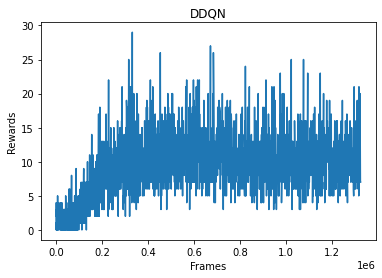

Episode:  2091
Steps:  330037  epsilon:  0.030000066089284908
Episode:  2092
Steps:  330169  epsilon:  0.03000006565453189
Episode:  2093
Steps:  330311  epsilon:  0.030000065190035625
Episode:  2094
Steps:  330468  epsilon:  0.030000064680297187
Episode:  2095
Steps:  330603  epsilon:  0.03000006424517537
Steps:  330803  epsilon:  0.030000063605925196
Episode:  2096
Steps:  330830  epsilon:  0.030000063520115132
Episode:  2097
Steps:  330957  epsilon:  0.03000006311804034
Steps:  331157  epsilon:  0.030000062490005343
Episode:  2098
Steps:  331176  epsilon:  0.030000062430668026
Steps:  331376  epsilon:  0.0300000618094725
Episode:  2099
Steps:  331378  epsilon:  0.030000061803291865
Episode:  2100
Steps:  331559  epsilon:  0.030000061246495378
Steps:  331759  epsilon:  0.030000060637082566


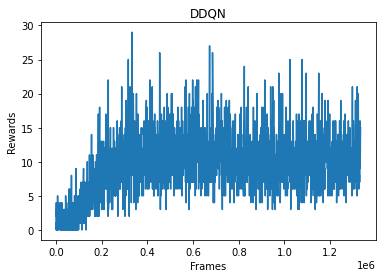

Episode:  2101
Steps:  331948  epsilon:  0.030000060066761147
Episode:  2102
Steps:  332110  epsilon:  0.030000059582185563
Steps:  332310  epsilon:  0.03000005898933291
Episode:  2103
Steps:  332340  epsilon:  0.03000005890091524
Episode:  2104
Steps:  332453  epsilon:  0.030000058569063435
Steps:  332653  epsilon:  0.030000057986291517
Episode:  2105
Steps:  332657  epsilon:  0.030000057974695418
Episode:  2106
Steps:  332828  epsilon:  0.030000057481124793
Episode:  2107
Steps:  332991  epsilon:  0.03000005701455747
Steps:  333191  epsilon:  0.030000056447253145
Episode:  2108
Steps:  333198  epsilon:  0.030000056427500064
Episode:  2109
Steps:  333364  epsilon:  0.03000005596109009
Episode:  2110
Steps:  333530  epsilon:  0.0300000554985353


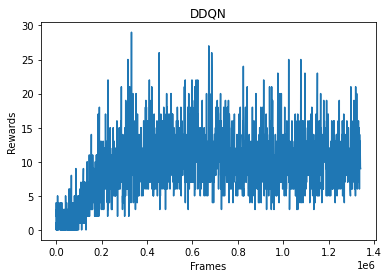

Episode:  2111
Steps:  333672  epsilon:  0.030000055105891238
Episode:  2112
Steps:  333845  epsilon:  0.030000054631280925
Episode:  2113
Steps:  334005  epsilon:  0.030000054195974228
Episode:  2114
Steps:  334121  epsilon:  0.030000053882547395
Episode:  2115
Steps:  334265  epsilon:  0.03000005349598634
Episode:  2116
Steps:  334420  epsilon:  0.030000053082994856
Episode:  2117
Steps:  334573  epsilon:  0.030000052678459267
Episode:  2118
Steps:  334668  epsilon:  0.030000052428829926
Episode:  2119
Steps:  334799  epsilon:  0.030000052086543303
Steps:  334999  epsilon:  0.030000051568273536
Episode:  2120
Steps:  335167  epsilon:  0.030000051136914285


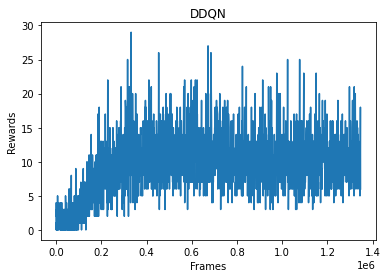

Episode:  2121
Steps:  335280  epsilon:  0.03000005084880539
Episode:  2122
Steps:  335394  epsilon:  0.03000005055979167
Steps:  335594  epsilon:  0.03000005005671334
Steps:  335794  epsilon:  0.03000004955864072
Episode:  2123
Steps:  335867  epsilon:  0.030000049378081404
Steps:  336067  epsilon:  0.030000048886761284
Episode:  2124
Steps:  336085  epsilon:  0.03000004884278299
Episode:  2125
Steps:  336270  epsilon:  0.030000048393070376
Episode:  2126
Steps:  336460  epsilon:  0.030000047935513047
Steps:  336660  epsilon:  0.030000047458546723
Episode:  2127
Steps:  336804  epsilon:  0.030000047118072366
Steps:  337004  epsilon:  0.03000004664923971
Episode:  2128
Steps:  337165  epsilon:  0.03000004627522078
Episode:  2129
Steps:  337344  epsilon:  0.030000045862905417
Episode:  2130
Steps:  337539  epsilon:  0.03000004541791494


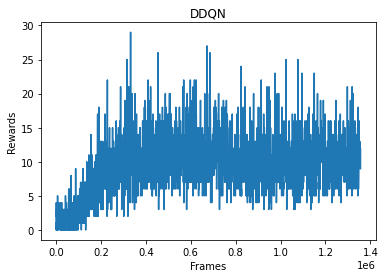

Episode:  2131
Steps:  337697  epsilon:  0.030000045060526954
Episode:  2132
Steps:  337869  epsilon:  0.030000044674667995
Episode:  2133
Steps:  338028  epsilon:  0.030000044320912425
Episode:  2134
Steps:  338154  epsilon:  0.030000044042568383
Steps:  338354  epsilon:  0.030000043604337504
Episode:  2135
Steps:  338358  epsilon:  0.030000043595617507
Episode:  2136
Steps:  338527  epsilon:  0.030000043228786584
Episode:  2137
Steps:  338697  epsilon:  0.03000004286289912
Episode:  2138
Steps:  338846  epsilon:  0.030000042544757074
Episode:  2139
Steps:  338965  epsilon:  0.030000042292367374
Episode:  2140
Steps:  339062  epsilon:  0.030000042087746
Steps:  339262  epsilon:  0.03000004166896593


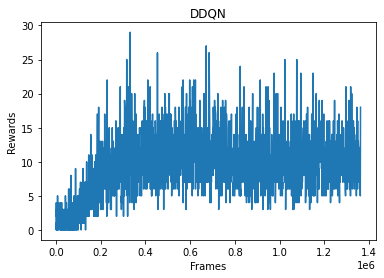

Episode:  2141
Steps:  339319  epsilon:  0.030000041550378446
Steps:  339519  epsilon:  0.030000041136945273
Episode:  2142
Steps:  339524  epsilon:  0.03000004112666232
Steps:  339724  epsilon:  0.030000040717445192
Steps:  339924  epsilon:  0.030000040312299844
Episode:  2143
Steps:  339956  epsilon:  0.030000040247851738
Steps:  340156  epsilon:  0.03000003984737892
Steps:  340356  epsilon:  0.030000039450890876
Episode:  2144
Steps:  340404  epsilon:  0.030000039356322266
Steps:  340604  epsilon:  0.030000038964720317
Episode:  2145
Steps:  340615  epsilon:  0.03000003894329561
Steps:  340815  epsilon:  0.030000038555803347
Episode:  2146
Steps:  340886  epsilon:  0.030000038419172908
Steps:  341086  epsilon:  0.03000003803689575
Episode:  2147
Steps:  341117  epsilon:  0.03000003797798423
Episode:  2148
Steps:  341291  epsilon:  0.030000037649008885
Steps:  341491  epsilon:  0.030000037274394986
Episode:  2149
Steps:  341519  epsilon:  0.030000037222247346
Episode:  2150
Steps:  3

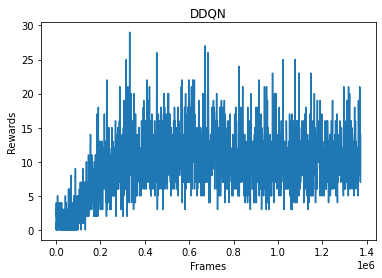

Episode:  2151
Steps:  341797  epsilon:  0.030000036708437358
Steps:  341997  epsilon:  0.030000036343182306
Episode:  2152
Steps:  342137  epsilon:  0.030000036089668364
Steps:  342337  epsilon:  0.03000003573057016
Episode:  2153
Steps:  342366  epsilon:  0.03000003567879838
Steps:  342566  epsilon:  0.030000035323788404
Episode:  2154
Steps:  342605  epsilon:  0.030000035254974133
Steps:  342805  epsilon:  0.030000034904181277
Steps:  343005  epsilon:  0.03000003455687887
Episode:  2155
Steps:  343066  epsilon:  0.03000003445164096
Episode:  2156
Steps:  343182  epsilon:  0.0300000342523998
Episode:  2157
Steps:  343311  epsilon:  0.030000034032182786
Episode:  2158
Steps:  343495  epsilon:  0.03000003372052254
Episode:  2159
Steps:  343659  epsilon:  0.030000033445144847
Episode:  2160
Steps:  343802  epsilon:  0.030000033206864927


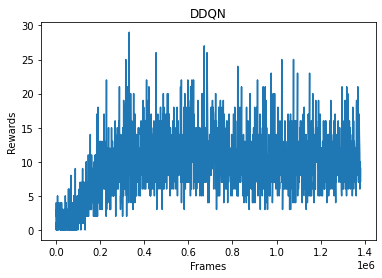

Episode:  2161
Steps:  343944  epsilon:  0.030000032971931188
Episode:  2162
Steps:  344063  epsilon:  0.030000032776330683
Steps:  344263  epsilon:  0.030000032450200744
Episode:  2163
Steps:  344270  epsilon:  0.03000003243884516
Steps:  344470  epsilon:  0.03000003211607326
Episode:  2164
Steps:  344576  epsilon:  0.030000031946308348


In [0]:
EPSILON = 1
MIN_EPSILON = 0.03
DECAY = 20000
env = gym.make("Breakout-v0")
n_actions = env.action_space.n
agent = Agent(num_frames, n_actions)
durations = []
Rewards=[]
frames=[]
frame_cnt=0
steps_done=0

def TrainAgent(episodes):
    global frame_cnt
    global R
    global steps_done
    for episode in range(episodes):
        print("Episode: ", episode)
        env.reset()
        states = [i for i in range(num_frames)]
        actions = [i for i in range(num_frames-1)]
        done = [False for i in range(num_frames-1)]
        for i in range(num_frames-1):
            states[i] = get_preprocessed_state()
            actions[i] = get_variable(torch.tensor([[random.randrange(n_actions)]]))
            _, _, done[i], _ = env.step(actions[i].item())
            
        states[num_frames-1] = get_preprocessed_state()
        state = get_variable( Variable(torch.cat([states[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0)))
        Reward = 0.0
        frame_cnt += num_frames
        
        if(sum(done) != 0):
            print("reward loop 1: ", Reward)
            Rewards.append(Reward)
            frames.append(frame_cnt)
        else:
            for steps in count():
                epsilon = decay_epsilon(steps_done)
                steps_done +=1
                if random.random() > epsilon:
                    with torch.no_grad():
                        action = get_variable(agent.model(state).max(1)[1].view(1, 1))
                else:
                    action = get_variable(torch.tensor([[random.randrange(n_actions)]], dtype=torch.long))
                re = 0.0
                s = [i for i in range(num_frames)]
                ended = [False for i in range(num_frames)]
                for i in range(num_frames):
                    _, r, ended[i], _ = env.step(action.item())
                    frame_cnt += 1
                    re += r
                    s[i] = get_preprocessed_state()
                    if ended[i]:
                        break
                reward = get_variable(torch.tensor([re]))
                
                #print output!!
                if steps % 200 == 0:
                    print("Steps: ", steps_done, " epsilon: ", epsilon)
                
                if sum(ended) == 0:
                    next_state = get_variable(torch.cat([s[i].squeeze(0) for i in range(num_frames)]).unsqueeze(0))
                    
                else:
                    next_state = None
                # Add each transition into the replay memory
                agent.memory.add(state, action, next_state, reward)
                
                state = Variable(next_state)
                Reward += re
                
                
                agent.train()
                if(sum(ended) != 0):
                    Rewards.append(Reward)
                    frames.append(frame_cnt)
                    break
                    
                if frame_cnt % TARGET_UPDATE_FREQUENCY == 0:
                    agent.target_model.load_state_dict(agent.model.state_dict())
                    
            if episode % 10 == 0:
                plt.plot(frames, Rewards)
                plt.xlabel('Frames')
                plt.ylabel('Rewards')
                plt.title("DDQN")
                plt.show()
        
    torch.save(agent.model.state_dict(), path)

TrainAgent(episodes)

## References

1. https://github.com/adamtiger/DQN/tree/f4aa6e9fb31ac72568f20509097c9981c77b73e4
2. https://pytorch.org/tutorials/beginner/saving_loading_models.html
3. https://pytorch.org/docs/stable/nn.html
4. https://pytorch.org/cppdocs/api/classtorch_1_1nn_1_1_conv2d.html
5. https://discuss.pytorch.org/t/how-to-convert-array-to-tensor/28809
6. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
7. https://github.com/chaitanya100100/RL-Algorithms-Pytorch/tree/master/DQN_DDQN
8. https://www.neuralnet.ai/coding-a-deep-q-network-in-pytorch/